# Data


In [104]:
print("test")

test


In [105]:
# pip install openml

In [106]:
# pip install category_encoders

In [107]:
#pip install imbalanced-learn

In [108]:
#Data
import openml

#Basics
import copy
import math
import numpy as np
import pandas as pd
import random

#Analyzis
from category_encoders import TargetEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from itertools import combinations
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency, mannwhitneyu, pearsonr, pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Machine learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, IsolationForest, RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectKBest
from sklearn.impute import IterativeImputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import  cross_val_score, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVC

#Graphik
import matplotlib.pyplot as plt
import seaborn as sns


# Warum Random Forest Regeressor ?


In [109]:
dataset = openml.datasets.get_dataset(42742)

X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

df = pd.DataFrame(X)
df['target'] = y
X = pd.DataFrame(X)

C:\Users\Dennis\AppData\Local\Temp\ipykernel_15572\2563754152.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(42742)


In [110]:
pd.set_option('display.max_columns',None)

    Values of -1 indicate that the feature was missing from the observation.
    target columns signifies whether or not a claim was filed for that policy holder.
    Ind is related to individual or driver
    reg is related to region
    car is related to car itself
    calc is an calculated feature

# Metadata

In [111]:
def categorize_column(col):
    if 'cat' in col:
        return 'categorical'
    elif df[col].nunique() == 2:
        return 'binary'
    elif col == 'target' or 'bin' in col:
        return 'binary'
    elif df[col].dtype == np.uint8:
        return 'continuous'
    elif df[col].dtype in [np.float64, np.int64]:
        return 'continuous'
    else:
        return 'other'

def feature_context(col):
    if 'ind' in col:
        return 'ind'
    elif 'reg' in col:
        return 'reg'
    elif 'car' in col:
        return 'car'
    elif 'calc' in col:
        return 'cal'
    elif col == 'target':
        return 'target'
    else:
        return 'other'

metadata = [(col, df[col].dtype, categorize_column(col), feature_context(col)) for col in df.columns]
metadata_df = pd.DataFrame(metadata, columns=['Feature Name', 'Data Type', 'Category', 'Context'])

In [112]:
metadata = [(col, df[col].dtype, categorize_column(col), feature_context(col), df[col].isna().any(), df[col].isna().sum()) for col in df.columns]
metadata_df = pd.DataFrame(metadata, columns=['Feature Name', 'Data Type', 'Category', 'Context', 'NAs', 'NAs_n'])


In [113]:
metadata = [(col, df[col].dtype, categorize_column(col), feature_context(col), df[col].isna().any(), df[col].isna().sum(), df[col].min(), df[col].max()) for col in df.columns]
metadata_df = pd.DataFrame(metadata, columns=['Feature Name', 'Data Type', 'Category', 'Context', 'NAs', 'NAs_n', 'Min', 'Max'])

In [114]:
categorical_cols = metadata_df[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
binary_cols = metadata_df[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
continuous_cols = metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()

##**Variablen Feature Category**##

In [115]:
target_variable = 'target'
categorical_features = df[metadata_df[metadata_df['Data Type'] == 'category']['Feature Name']]
categorical_features = categorical_features.drop(columns=[target_variable], errors='ignore')
continuous_int_features  = df[list(metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Data Type'] == 'uint8')]['Feature Name'])]
continuous_float_features  = df[list(metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Data Type'] == 'float64')]['Feature Name'])]
continuous_columns = metadata_df[metadata_df['Category'] == 'continuous']['Feature Name']
categorical_features_with_nas = metadata_df[(metadata_df['Category'] == 'categorical') & (metadata_df['NAs'] == True)]
binary_cols = metadata_df[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()

# EDA I: Data Profiling

In [ ]:
df.info()
# Dtype: uint8, float64, category
# missing values exists
# index starts at 2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ps_ind_01       595212 non-null  uint8   
 1   ps_ind_02_cat   594996 non-null  category
 2   ps_ind_03       595212 non-null  uint8   
 3   ps_ind_04_cat   595129 non-null  category
 4   ps_ind_05_cat   589403 non-null  category
 5   ps_ind_06_bin   595212 non-null  category
 6   ps_ind_07_bin   595212 non-null  category
 7   ps_ind_08_bin   595212 non-null  category
 8   ps_ind_09_bin   595212 non-null  category
 9   ps_ind_10_bin   595212 non-null  category
 10  ps_ind_11_bin   595212 non-null  category
 11  ps_ind_12_bin   595212 non-null  category
 12  ps_ind_13_bin   595212 non-null  category
 13  ps_ind_14       595212 non-null  uint8   
 14  ps_ind_15       595212 non-null  uint8   
 15  ps_ind_16_bin   595212 non-null  category
 16  ps_ind_17_bin   595212 non-null  categ

In [ ]:
X.describe(include='category')
# ps_ind_04_cat, ps_ind_05_cat ,ps_ind_06_cat top category 0
# ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin, ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin, ps_ind_17_bin, ps_ind_18_bin,
# ps_car_04_cat, ps_calc_15_bin, ps_calc_18_bin, ps_calc_19_bin, ps_calc_20_bin

ps_ind_02_cat ps_ind_04_cat ps_ind_05_cat ps_ind_06_bin ps_ind_07_bin  \
count         594996        595129        589403        595212        595212   
unique             4             2             7             2             2   
top                1             0             0             0             0   
freq          431859        346965        528009        360852        442223   

       ps_ind_08_bin ps_ind_09_bin ps_ind_10_bin ps_ind_11_bin ps_ind_12_bin  \
count         595212        595212        595212        595212        595212   
unique             2             2             2             2             2   
top                0             0             0             0             0   
freq          497644        484917        594990        594205        589594   

       ps_ind_13_bin ps_ind_16_bin ps_ind_17_bin ps_ind_18_bin ps_car_01_cat  \
count         595212        595212        595212        595212        595105   
unique             2             2             2             2            12   
top                0             1             0             0            11   
freq          594648        393330        523143        503879        207573   

       ps_car_02_cat ps_car_03_cat ps_car_04_cat ps_car_05_cat ps_car_06_cat  \
count         595207        183981        595212        328661        595212   
unique             2             2            10             2            18   
top                1             1             0             1            11   
freq          493990        110709        496581        172667        131527   

       ps_car_07_cat ps_car_08_cat ps_car_09_cat ps_car_10_cat ps_car_11_cat  \
count         583723        595212        594643        595212        595212   
unique             2             2             5             3           104   
top                1             1             2             1           104   
freq          553148        495264        353482        590179         85083   

       ps_calc_15_bin ps_calc_16_bin ps_calc_17_bin ps_calc_18_bin  \
count          595212         595212         595212         595212   
unique              2              2              2              2   
top                 0              1              1              0   
freq           522342         373698         329856         424278   

       ps_calc_19_bin ps_calc_20_bin  
count          595212         595212  
unique              2              2  
top                 0              0  
freq           387469         503955

In [ ]:
X.describe()


ps_ind_01      ps_ind_03      ps_ind_14      ps_ind_15  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        1.900378       4.423318       0.012451       7.299922   
std         1.983789       2.699902       0.127545       3.546042   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       2.000000       0.000000       5.000000   
50%         1.000000       4.000000       0.000000       7.000000   
75%         3.000000       6.000000       0.000000      10.000000   
max         7.000000      11.000000       4.000000      13.000000   

           ps_reg_01      ps_reg_02      ps_reg_03      ps_car_11  \
count  595212.000000  595212.000000  487440.000000  595207.000000   
mean        0.610991       0.439184       0.894047       2.346100   
std         0.287643       0.404264       0.345413       0.832495   
min         0.000000       0.000000       0.061237       0.000000   
25%         0.400000       0.200000       0.633443       2.000000   
50%         0.700000       0.300000       0.801561       3.000000   
75%         0.900000       0.600000       1.083974       3.000000   
max         0.900000       1.800000       4.037945       3.000000   

           ps_car_12      ps_car_13      ps_car_14      ps_car_15  \
count  595211.000000  595212.000000  552592.000000  595212.000000   
mean        0.379947       0.813265       0.374691       3.065899   
std         0.058300       0.224588       0.045610       0.731366   
min         0.100000       0.250619       0.109545       0.000000   
25%         0.316228       0.670867       0.350428       2.828427   
50%         0.374166       0.765811       0.373497       3.316625   
75%         0.400000       0.906190       0.398121       3.605551   
max         1.264911       3.720626       0.636396       3.741657   

          ps_calc_01     ps_calc_02     ps_calc_03     ps_calc_04  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.449756       0.449589       0.449849       2.372081   
std         0.287198       0.286893       0.287153       1.117219   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.200000       0.200000       0.200000       2.000000   
50%         0.500000       0.400000       0.500000       2.000000   
75%         0.700000       0.700000       0.700000       3.000000   
max         0.900000       0.900000       0.900000       5.000000   

          ps_calc_05     ps_calc_06     ps_calc_07     ps_calc_08  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        1.885886       7.689445       3.005823       9.225904   
std         1.134927       1.334312       1.414564       1.459672   
min         0.000000       0.000000       0.000000       2.000000   
25%         1.000000       7.000000       2.000000       8.000000   
50%         2.000000       8.000000       3.000000       9.000000   
75%         3.000000       9.000000       4.000000      10.000000   
max         6.000000      10.000000       9.000000      12.000000   

          ps_calc_09     ps_calc_10     ps_calc_11     ps_calc_12  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        2.339034       8.433590       5.441382       1.441918   
std         1.246949       2.904597       2.332871       1.202963   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       6.000000       4.000000       1.000000   
50%         2.000000       8.000000       5.000000       1.000000   
75%         3.000000      10.000000       7.000000       2.000000   
max         7.000000      25.000000      19.000000      10.000000   

          ps_calc_13     ps_calc_14  
count  595212.000000  595212.000000  
mean        2.872288       7.539026  
std         1.694887       2.746652  
min         0.000000       0.000000  
25%         2.000000       6.000000  
50%         3.000000       7.000000  
75%         4

In [ ]:
y.describe()

count     595212
unique         2
top            0
freq      573518
Name: target, dtype: object

##**Kategorien untersuchen**

In [ ]:
print(metadata_df)

      Feature Name Data Type     Category Context    NAs   NAs_n       Min  \
0        ps_ind_01     uint8   continuous     ind  False       0         0   
1    ps_ind_02_cat  category  categorical     ind   True     216         1   
2        ps_ind_03     uint8   continuous     ind  False       0         0   
3    ps_ind_04_cat  category  categorical     ind   True      83         0   
4    ps_ind_05_cat  category  categorical     ind   True    5809         0   
5    ps_ind_06_bin  category       binary     ind  False       0         0   
6    ps_ind_07_bin  category       binary     ind  False       0         0   
7    ps_ind_08_bin  category       binary     ind  False       0         0   
8    ps_ind_09_bin  category       binary     ind  False       0         0   
9    ps_ind_10_bin  category       binary     ind  False       0         0   
10   ps_ind_11_bin  category       binary     ind  False       0         0   
11   ps_ind_12_bin  category       binary     ind  False       0

C:\Users\Home\AppData\Local\Temp\ipykernel_22124\16781526.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(category_counts.index, rotation=45)
C:\Users\Home\AppData\Local\Temp\ipykernel_22124\16781526.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(context_counts.index, rotation=45)


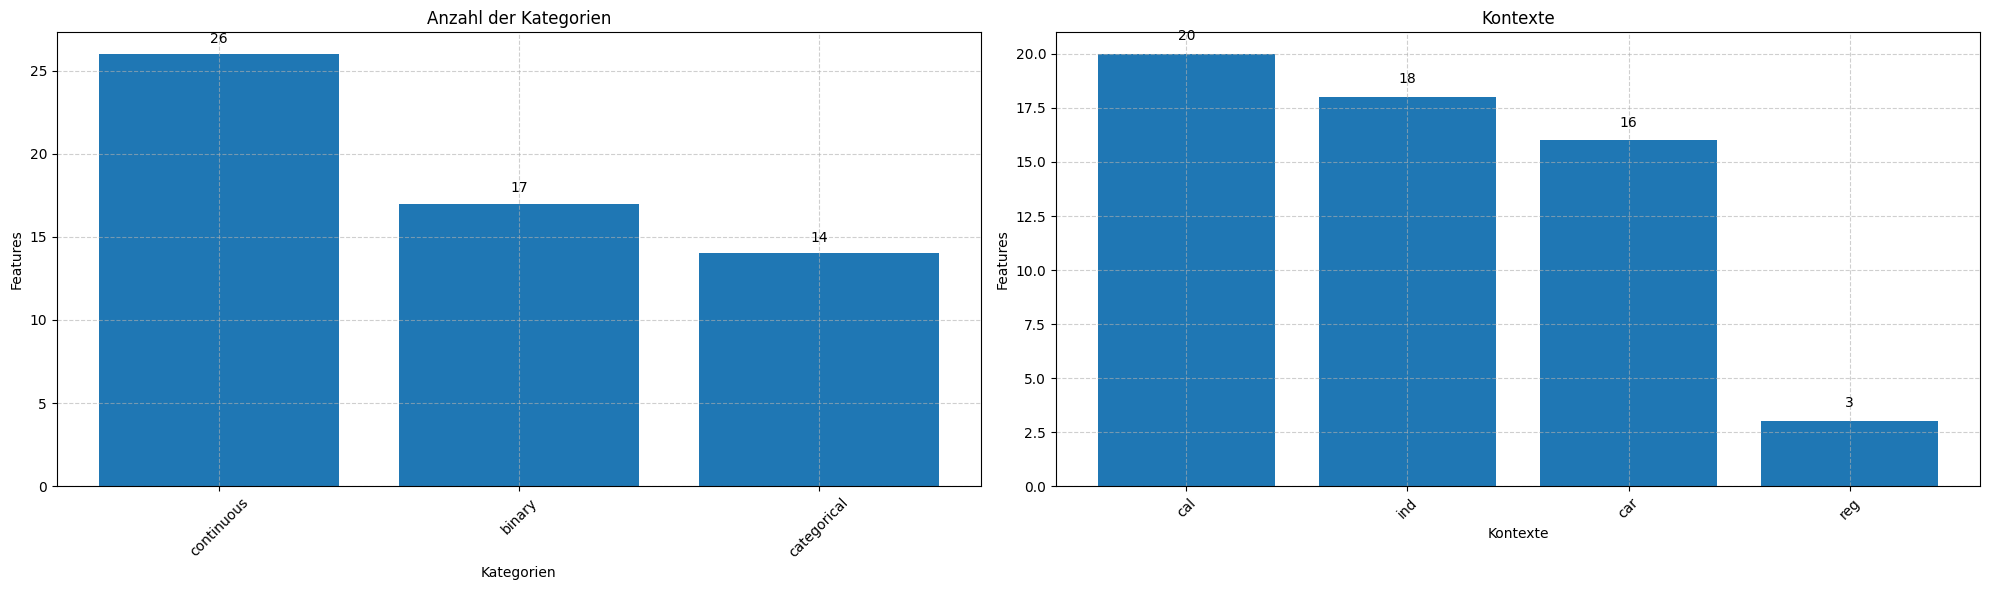

In [ ]:
filtered_metadata_df = metadata_df[metadata_df['Feature Name'] != 'target']

category_counts = filtered_metadata_df['Category'].value_counts()
context_counts = filtered_metadata_df['Context'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

bars1 = ax1.bar(category_counts.index, category_counts.values)
ax1.set_title('Anzahl der Kategorien')
ax1.set_xlabel('Kategorien')
ax1.set_ylabel('Features')
ax1.set_xticklabels(category_counts.index, rotation=45)
ax1.grid(True, linestyle='--', alpha=0.6)

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())),
             ha='center', va='bottom')

bars2 = ax2.bar(context_counts.index, context_counts.values)
ax2.set_title('Kontexte')
ax2.set_xlabel('Kontexte')
ax2.set_ylabel('Features')
ax2.set_xticklabels(context_counts.index, rotation=45)
ax2.grid(True, linestyle='--', alpha=0.6)

for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())),
             ha='center', va='bottom')

plt.tight_layout()

plt.show()


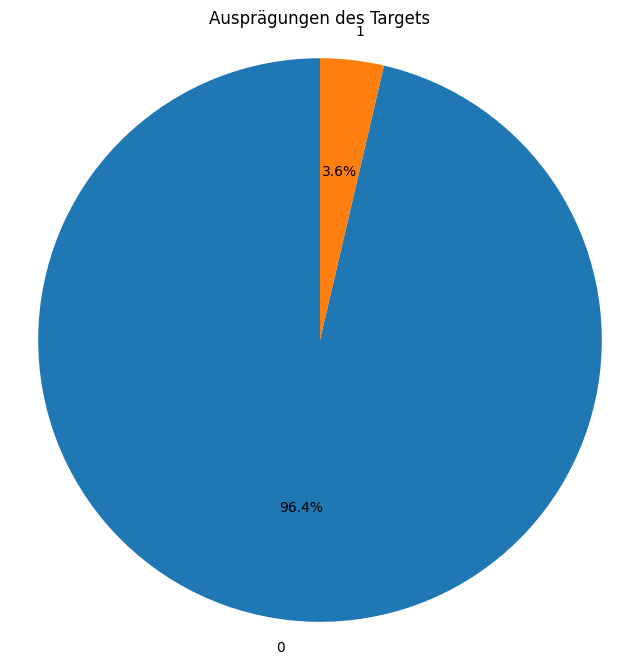

In [ ]:
target_counts = df['target'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Ausprägungen des Targets')
plt.axis('equal')

plt.show()


No NAs in Target

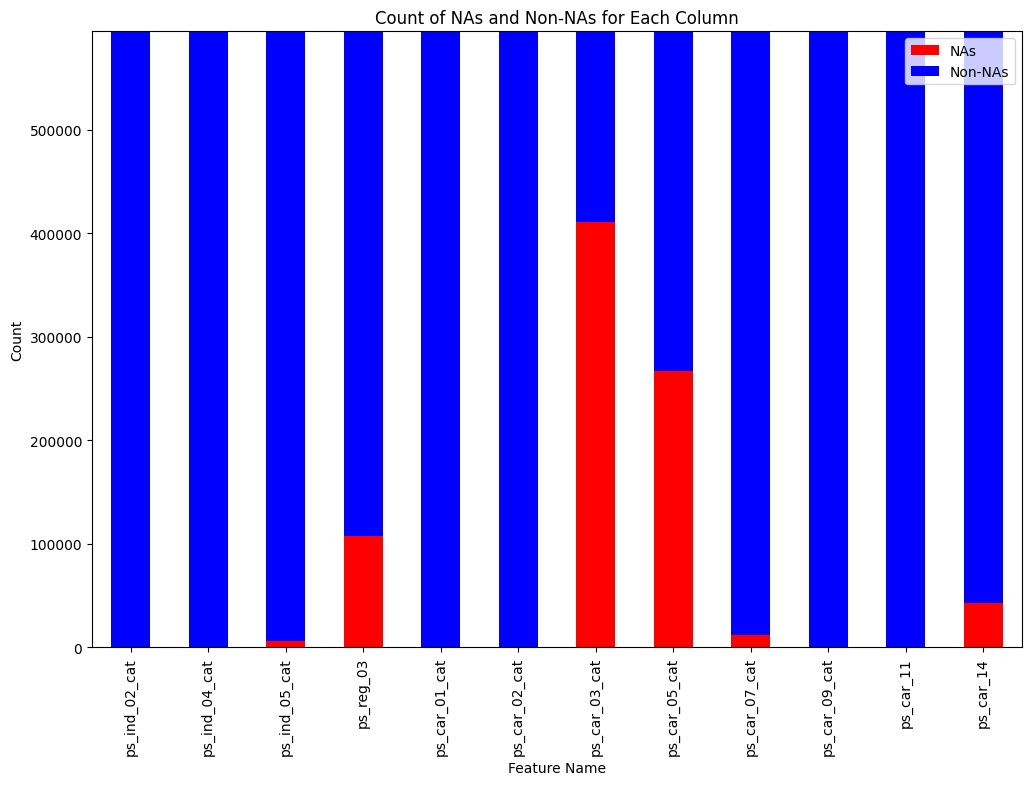

In [ ]:
num_rows = len(df)
na_counts = metadata_df.set_index('Feature Name')['NAs_n']
na_counts_filtered = na_counts[na_counts>1]
non_na_counts = num_rows - na_counts_filtered

fig, ax = plt.subplots(figsize=(12, 8))

na_counts_filtered.plot(kind='bar', ax=ax, color='red', label='NAs')
non_na_counts.plot(kind='bar', ax=ax, color='blue', bottom=na_counts_filtered, label='Non-NAs')

ax.set_ylim(0, num_rows)
ax.set_ylabel('Count')
ax.set_title('Count of NAs and Non-NAs for Each Column')
ax.legend()
plt.show()

##**Duplicates**

In [ ]:
metadata_df.columns

Index(['Feature Name', 'Data Type', 'Category', 'Context', 'NAs', 'NAs_n',
       'Min', 'Max'],
      dtype='object')

##Univariate Categorial

In [ ]:
categorical_features = df[metadata_df[metadata_df['Data Type'] == 'category']['Feature Name']]


Visualization without NAs

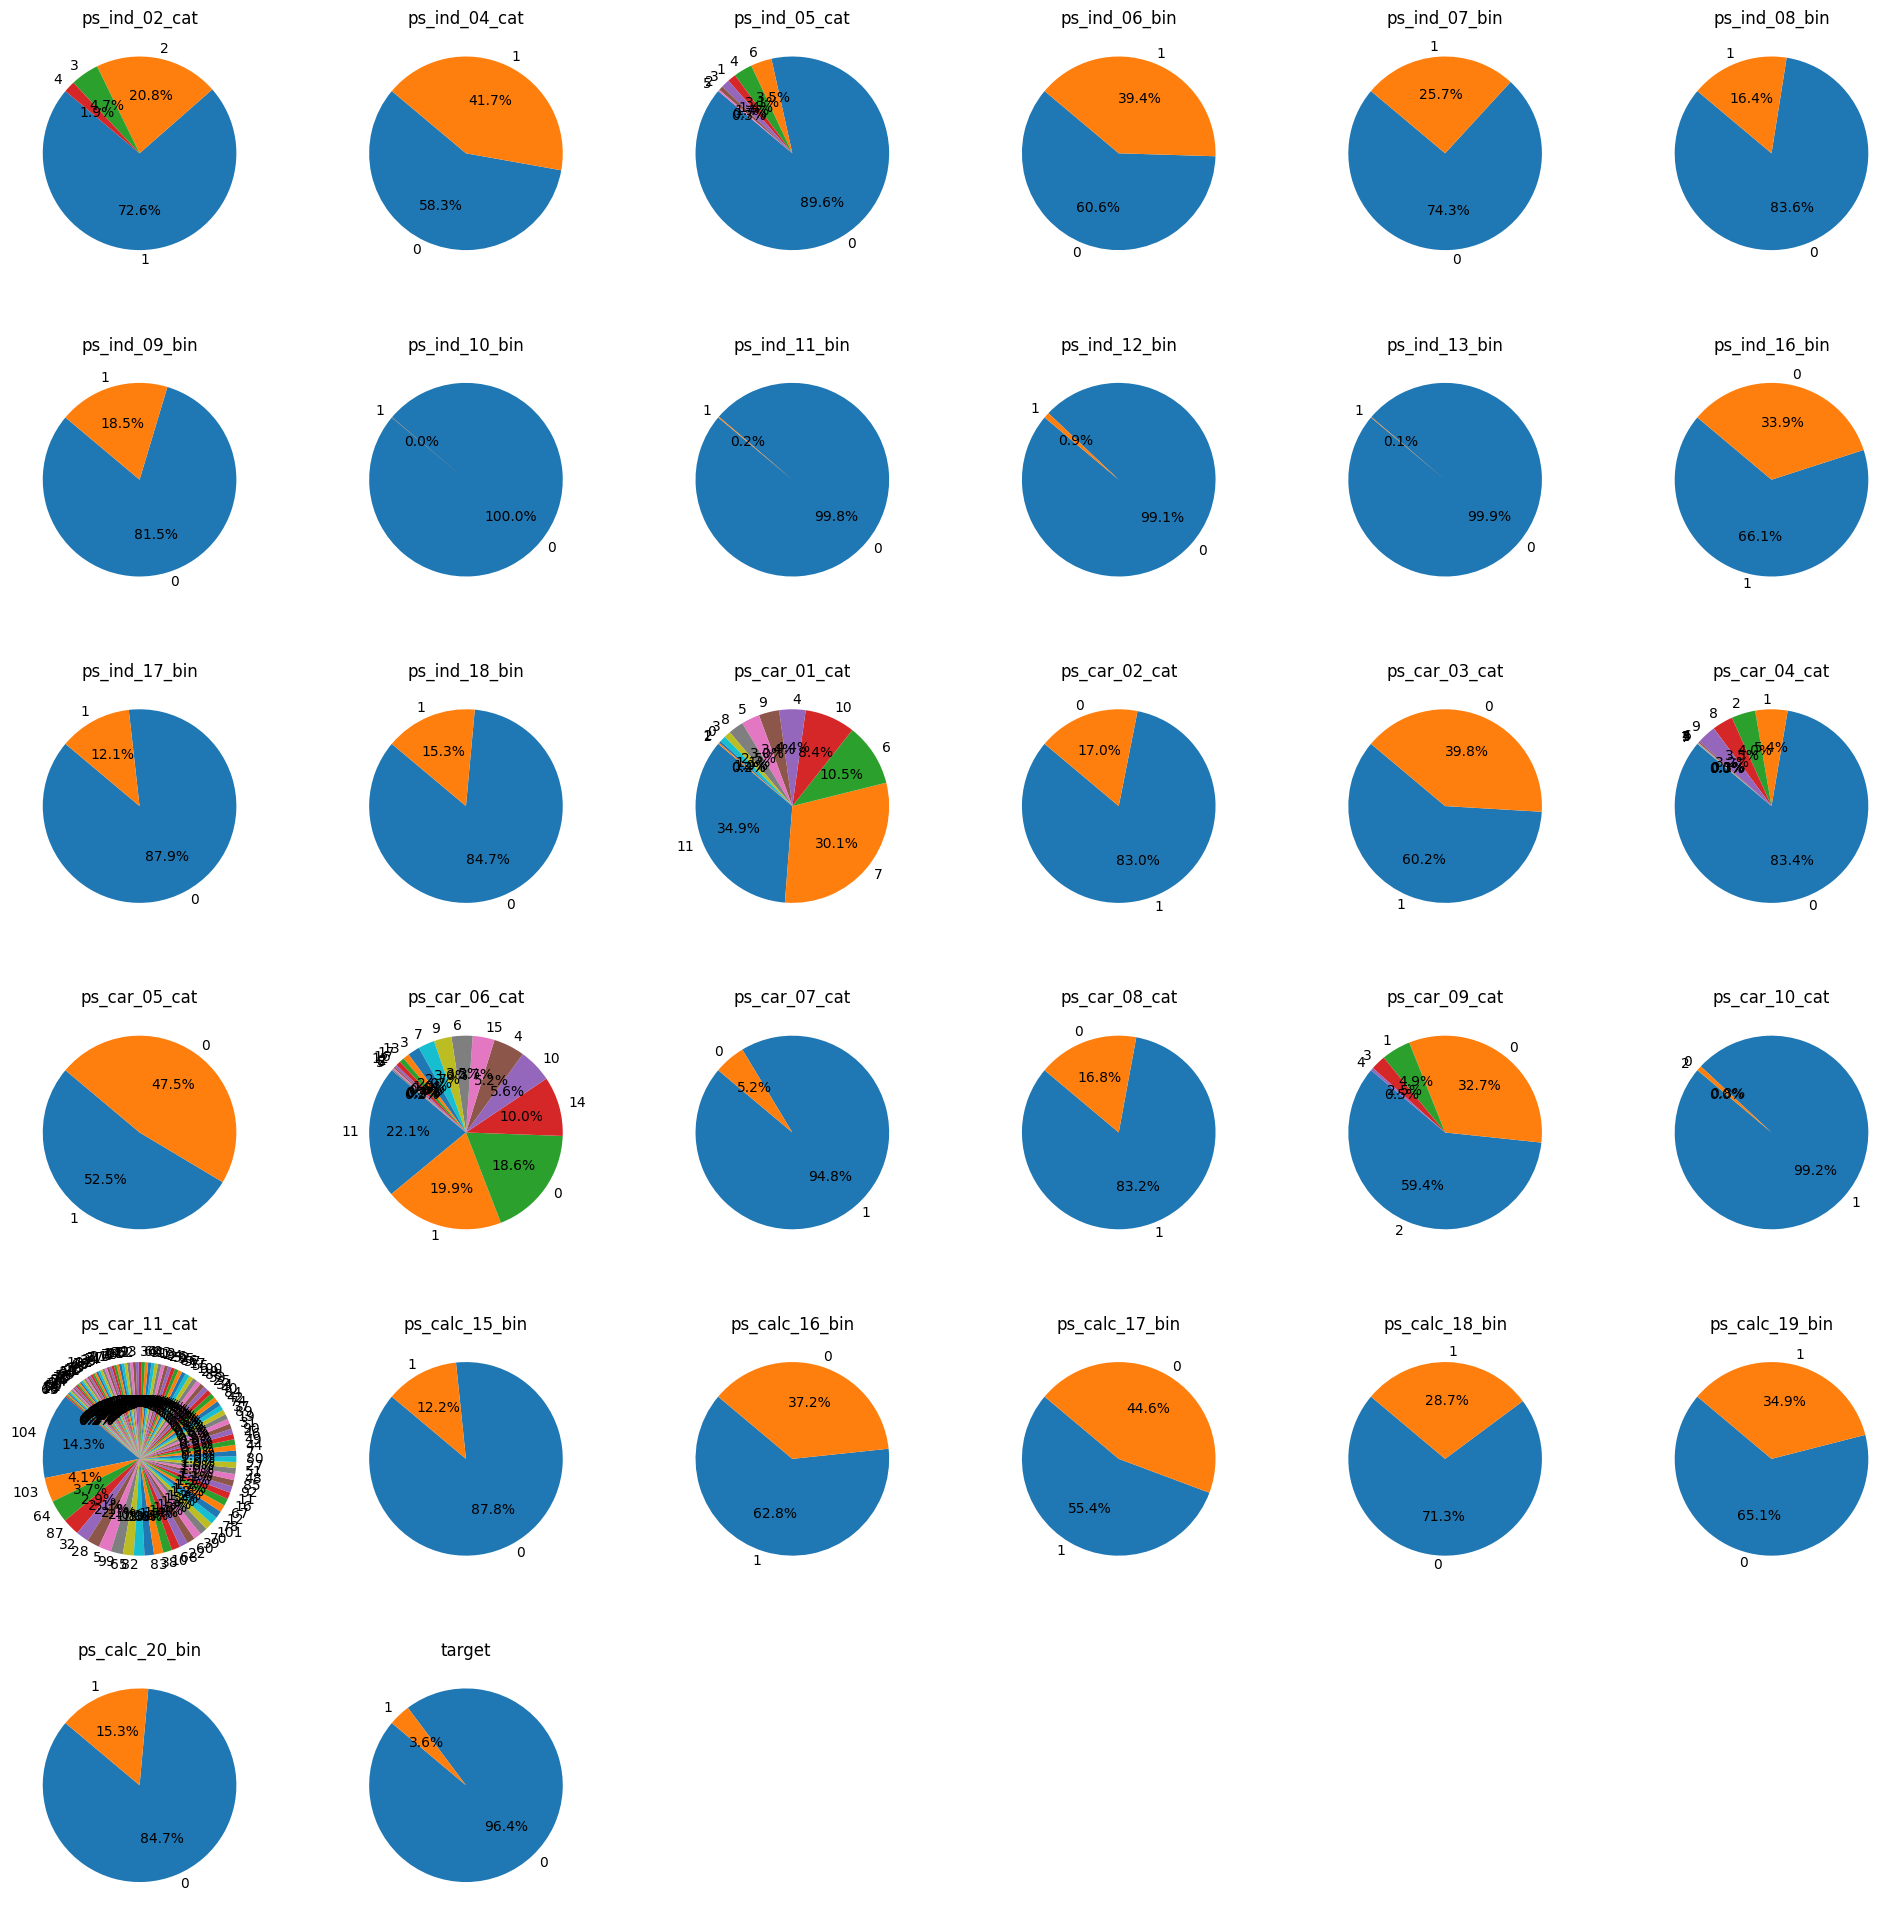

In [ ]:
length_categorical = len(categorical_features.columns)

rows = 6
cols = 6

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
fig.tight_layout(pad=3.0)
axes = axes.flatten()

for i, feature in enumerate(categorical_features.columns):
    counts = df[feature].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(feature)

for j in range(length_categorical, len(axes)):
    axes[j].axis('off')

plt.show()


In [ ]:
categorical_features_with_nas_df = metadata_df[(metadata_df['NAs']==True) & (metadata_df['Data Type']=='category')]['Feature Name']
categorical_features_with_nas_df

1     ps_ind_02_cat
3     ps_ind_04_cat
4     ps_ind_05_cat
21    ps_car_01_cat
22    ps_car_02_cat
23    ps_car_03_cat
25    ps_car_05_cat
27    ps_car_07_cat
29    ps_car_09_cat
Name: Feature Name, dtype: object

**Visualization** with NAs

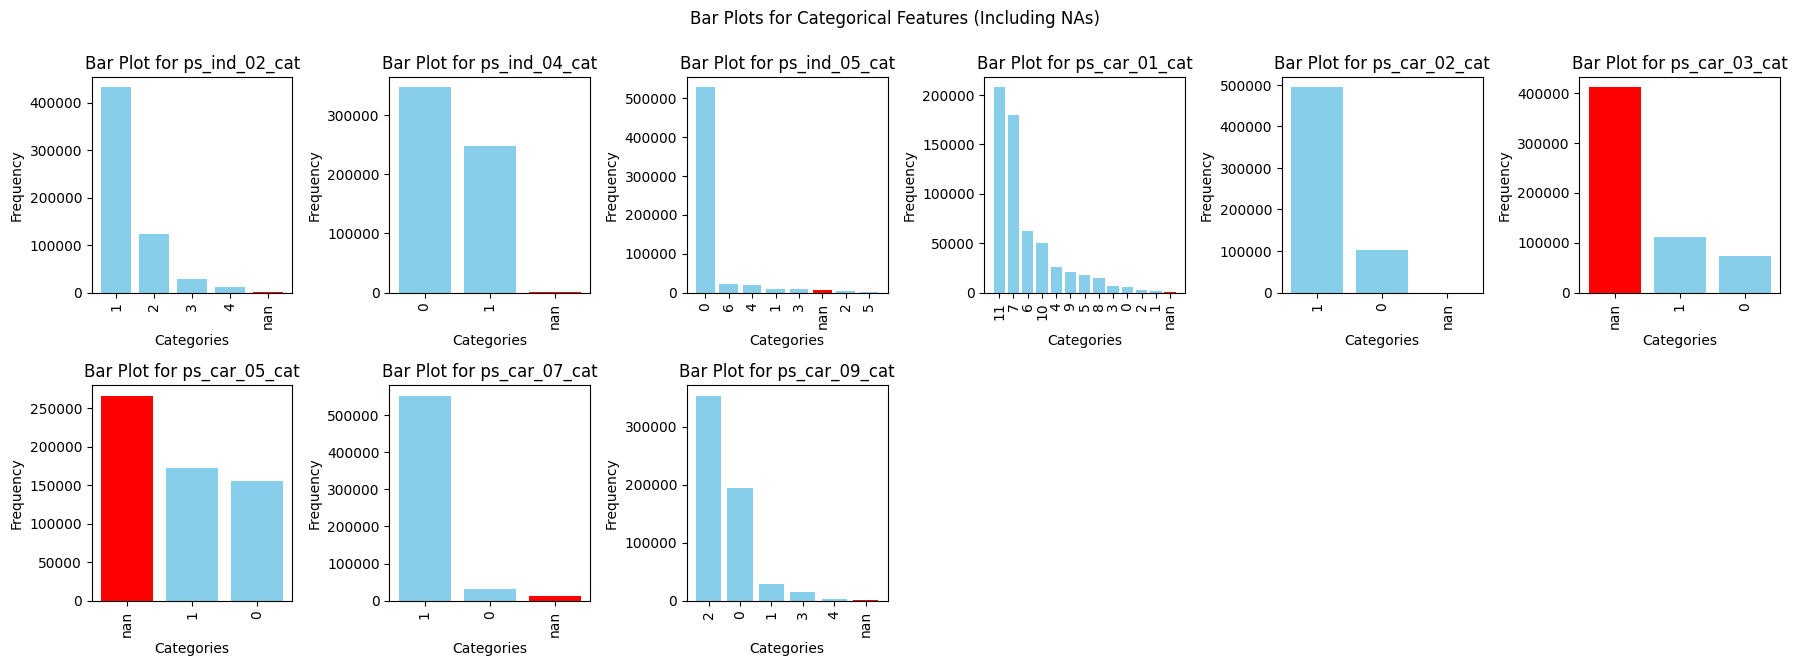

In [ ]:
length_categorical_with_NAs = len(categorical_features_with_nas_df)
num_rows = 5
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(categorical_features_with_nas_df):
    if idx < len(axes):
        data = df[col].value_counts(dropna=False)
        colors = ['skyblue' if not pd.isna(value) else 'red' for value in data.index]
        axes[idx].bar(data.index.astype(str), data.values, color=colors)
        axes[idx].set_title(f'Bar Plot for {col}')
        axes[idx].set_xlabel('Categories')
        axes[idx].set_ylabel('Frequency')
        axes[idx].tick_params(axis='x', rotation=90)


for ax in axes[length_categorical_with_NAs:]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle('Bar Plots for Categorical Features (Including NAs)', y=1.02)
plt.show()

##Univariat Continous

In [ ]:
continuous_int_features  = df[list(metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Data Type'] == 'uint8')]['Feature Name'])]
continuous_float_features  = df[list(metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Data Type'] == 'float64')]['Feature Name'])]

In [ ]:
continuous_float_features.describe()

ps_reg_01      ps_reg_02      ps_reg_03      ps_car_11  \
count  595212.000000  595212.000000  487440.000000  595207.000000   
mean        0.610991       0.439184       0.894047       2.346100   
std         0.287643       0.404264       0.345413       0.832495   
min         0.000000       0.000000       0.061237       0.000000   
25%         0.400000       0.200000       0.633443       2.000000   
50%         0.700000       0.300000       0.801561       3.000000   
75%         0.900000       0.600000       1.083974       3.000000   
max         0.900000       1.800000       4.037945       3.000000   

           ps_car_12      ps_car_13      ps_car_14      ps_car_15  \
count  595211.000000  595212.000000  552592.000000  595212.000000   
mean        0.379947       0.813265       0.374691       3.065899   
std         0.058300       0.224588       0.045610       0.731366   
min         0.100000       0.250619       0.109545       0.000000   
25%         0.316228       0.670867       0.350428       2.828427   
50%         0.374166       0.765811       0.373497       3.316625   
75%         0.400000       0.906190       0.398121       3.605551   
max         1.264911       3.720626       0.636396       3.741657   

          ps_calc_01     ps_calc_02     ps_calc_03  
count  595212.000000  595212.000000  595212.000000  
mean        0.449756       0.449589       0.449849  
std         0.287198       0.286893       0.287153  
min         0.000000       0.000000       0.000000  
25%         0.200000       0.200000       0.200000  
50%         0.500000       0.400000       0.500000  
75%         0.700000       0.700000       0.700000  
max         0.900000       0.900000       0.900000

In [ ]:
continuous_int_features.describe()

ps_ind_01      ps_ind_03      ps_ind_14      ps_ind_15  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        1.900378       4.423318       0.012451       7.299922   
std         1.983789       2.699902       0.127545       3.546042   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       2.000000       0.000000       5.000000   
50%         1.000000       4.000000       0.000000       7.000000   
75%         3.000000       6.000000       0.000000      10.000000   
max         7.000000      11.000000       4.000000      13.000000   

          ps_calc_04     ps_calc_05     ps_calc_06     ps_calc_07  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        2.372081       1.885886       7.689445       3.005823   
std         1.117219       1.134927       1.334312       1.414564   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       1.000000       7.000000       2.000000   
50%         2.000000       2.000000       8.000000       3.000000   
75%         3.000000       3.000000       9.000000       4.000000   
max         5.000000       6.000000      10.000000       9.000000   

          ps_calc_08     ps_calc_09     ps_calc_10     ps_calc_11  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        9.225904       2.339034       8.433590       5.441382   
std         1.459672       1.246949       2.904597       2.332871   
min         2.000000       0.000000       0.000000       0.000000   
25%         8.000000       1.000000       6.000000       4.000000   
50%         9.000000       2.000000       8.000000       5.000000   
75%        10.000000       3.000000      10.000000       7.000000   
max        12.000000       7.000000      25.000000      19.000000   

          ps_calc_12     ps_calc_13     ps_calc_14  
count  595212.000000  595212.000000  595212.000000  
mean        1.441918       2.872288       7.539026  
std         1.202963       1.694887       2.746652  
min         0.000000       0.000000       0.000000  
25%         1.000000       2.000000       6.000000  
50%         1.000000       3.000000       7.000000  
75%         2.000000       4.000000       9.000000  
max        10.000000      13.000000      23.000000

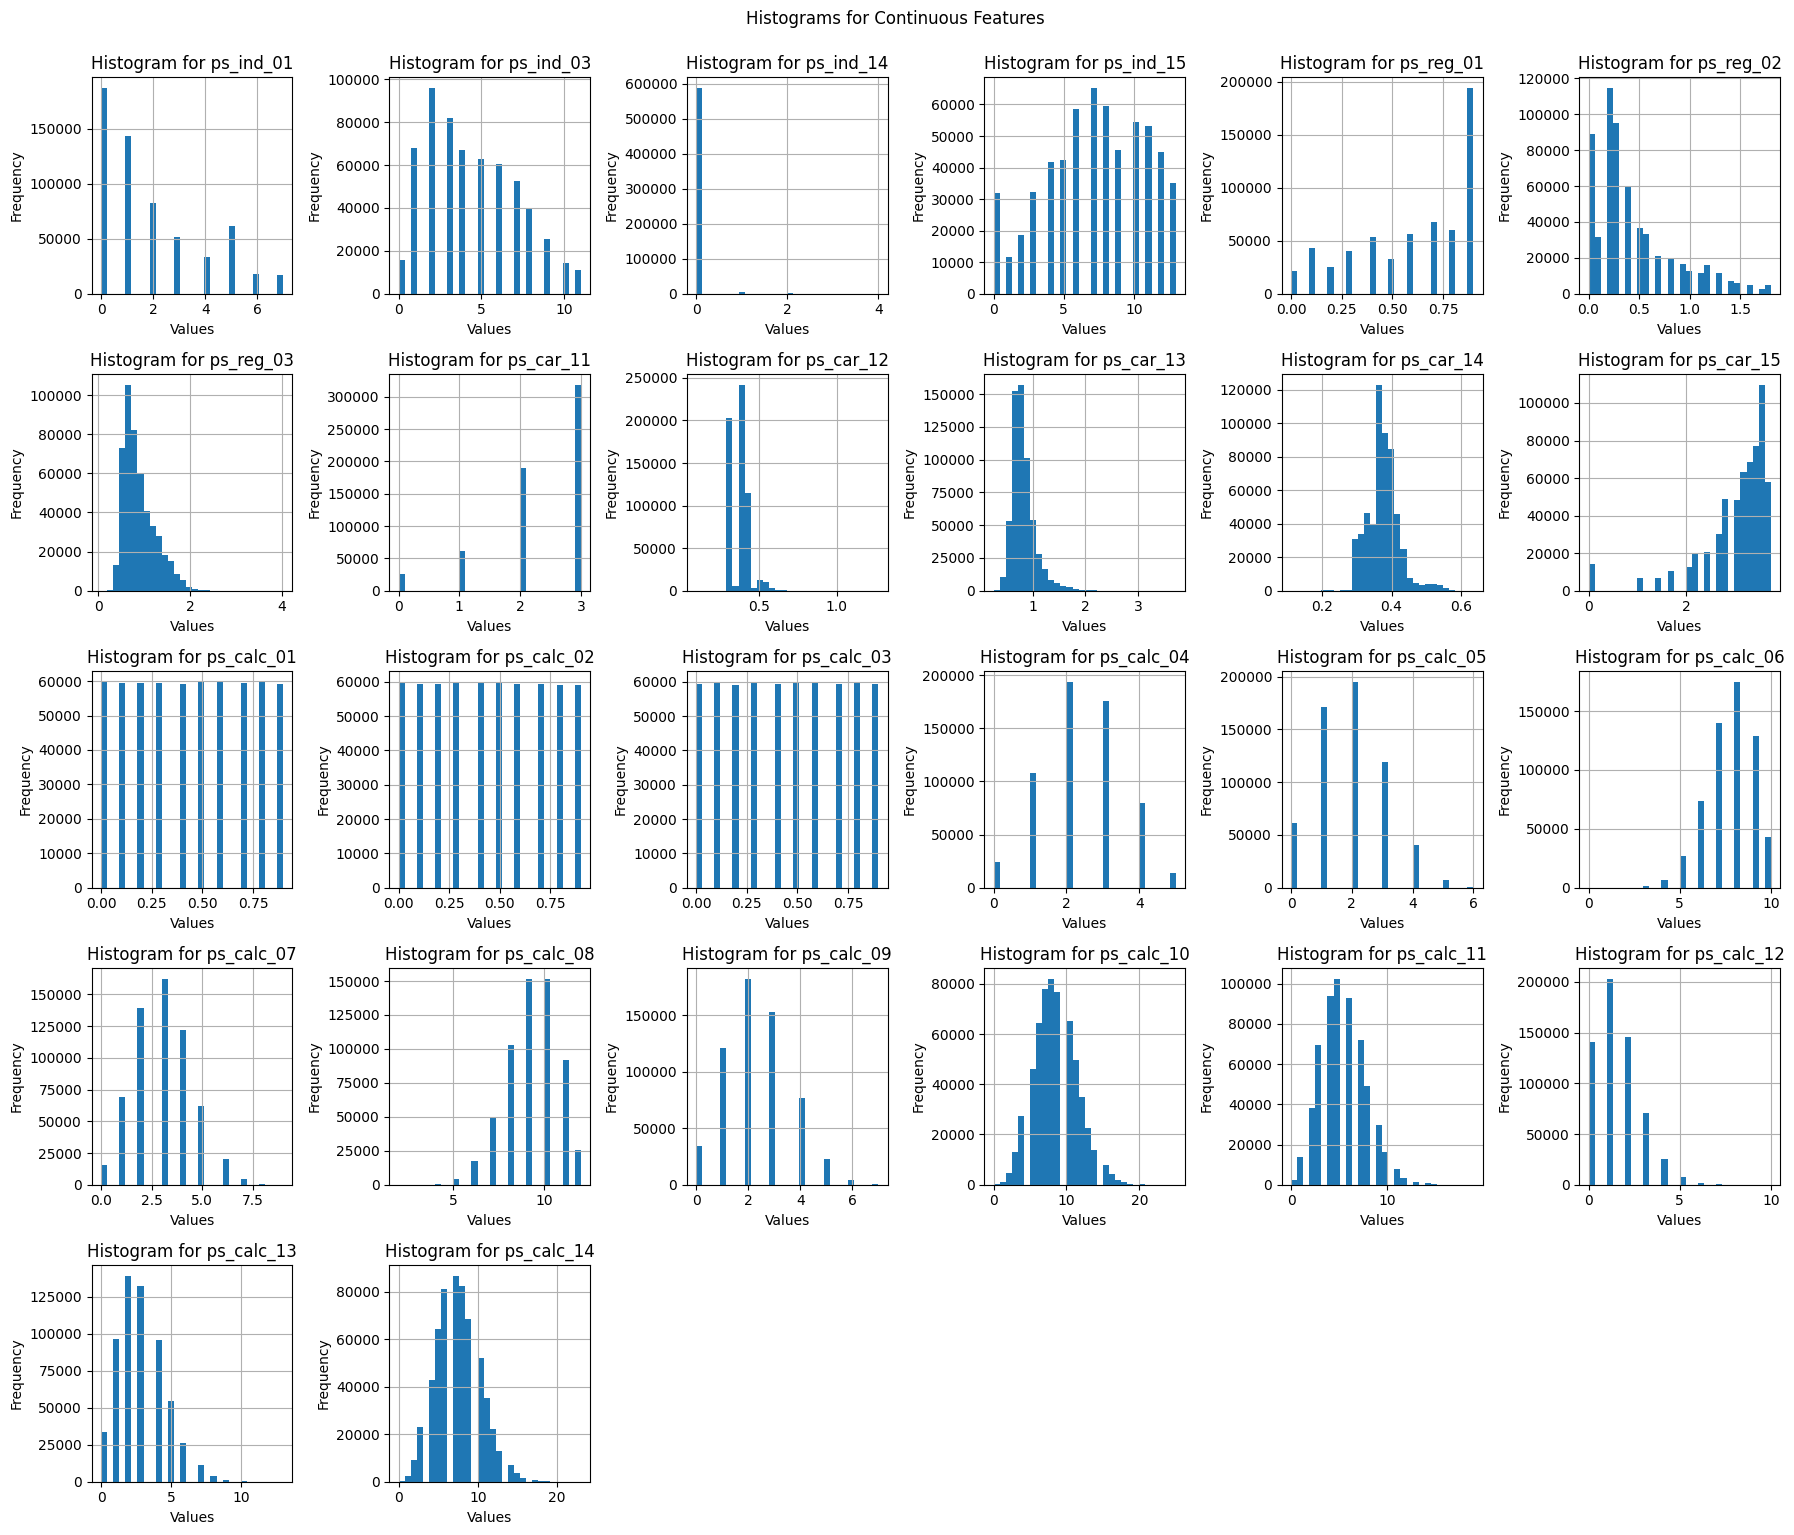

In [ ]:
continuous_columns = metadata_df[metadata_df['Category'] == 'continuous']['Feature Name']


num_plots = len(continuous_columns)
num_rows = 5
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(continuous_columns):
    if idx < len(axes):
        df[col].hist(bins=30, ax=axes[idx])
        axes[idx].set_title(f'Histogram for {col}')
        axes[idx].set_xlabel('Values')
        axes[idx].set_ylabel('Frequency')

for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle('Histograms for Continuous Features', y=1.02)
plt.show()

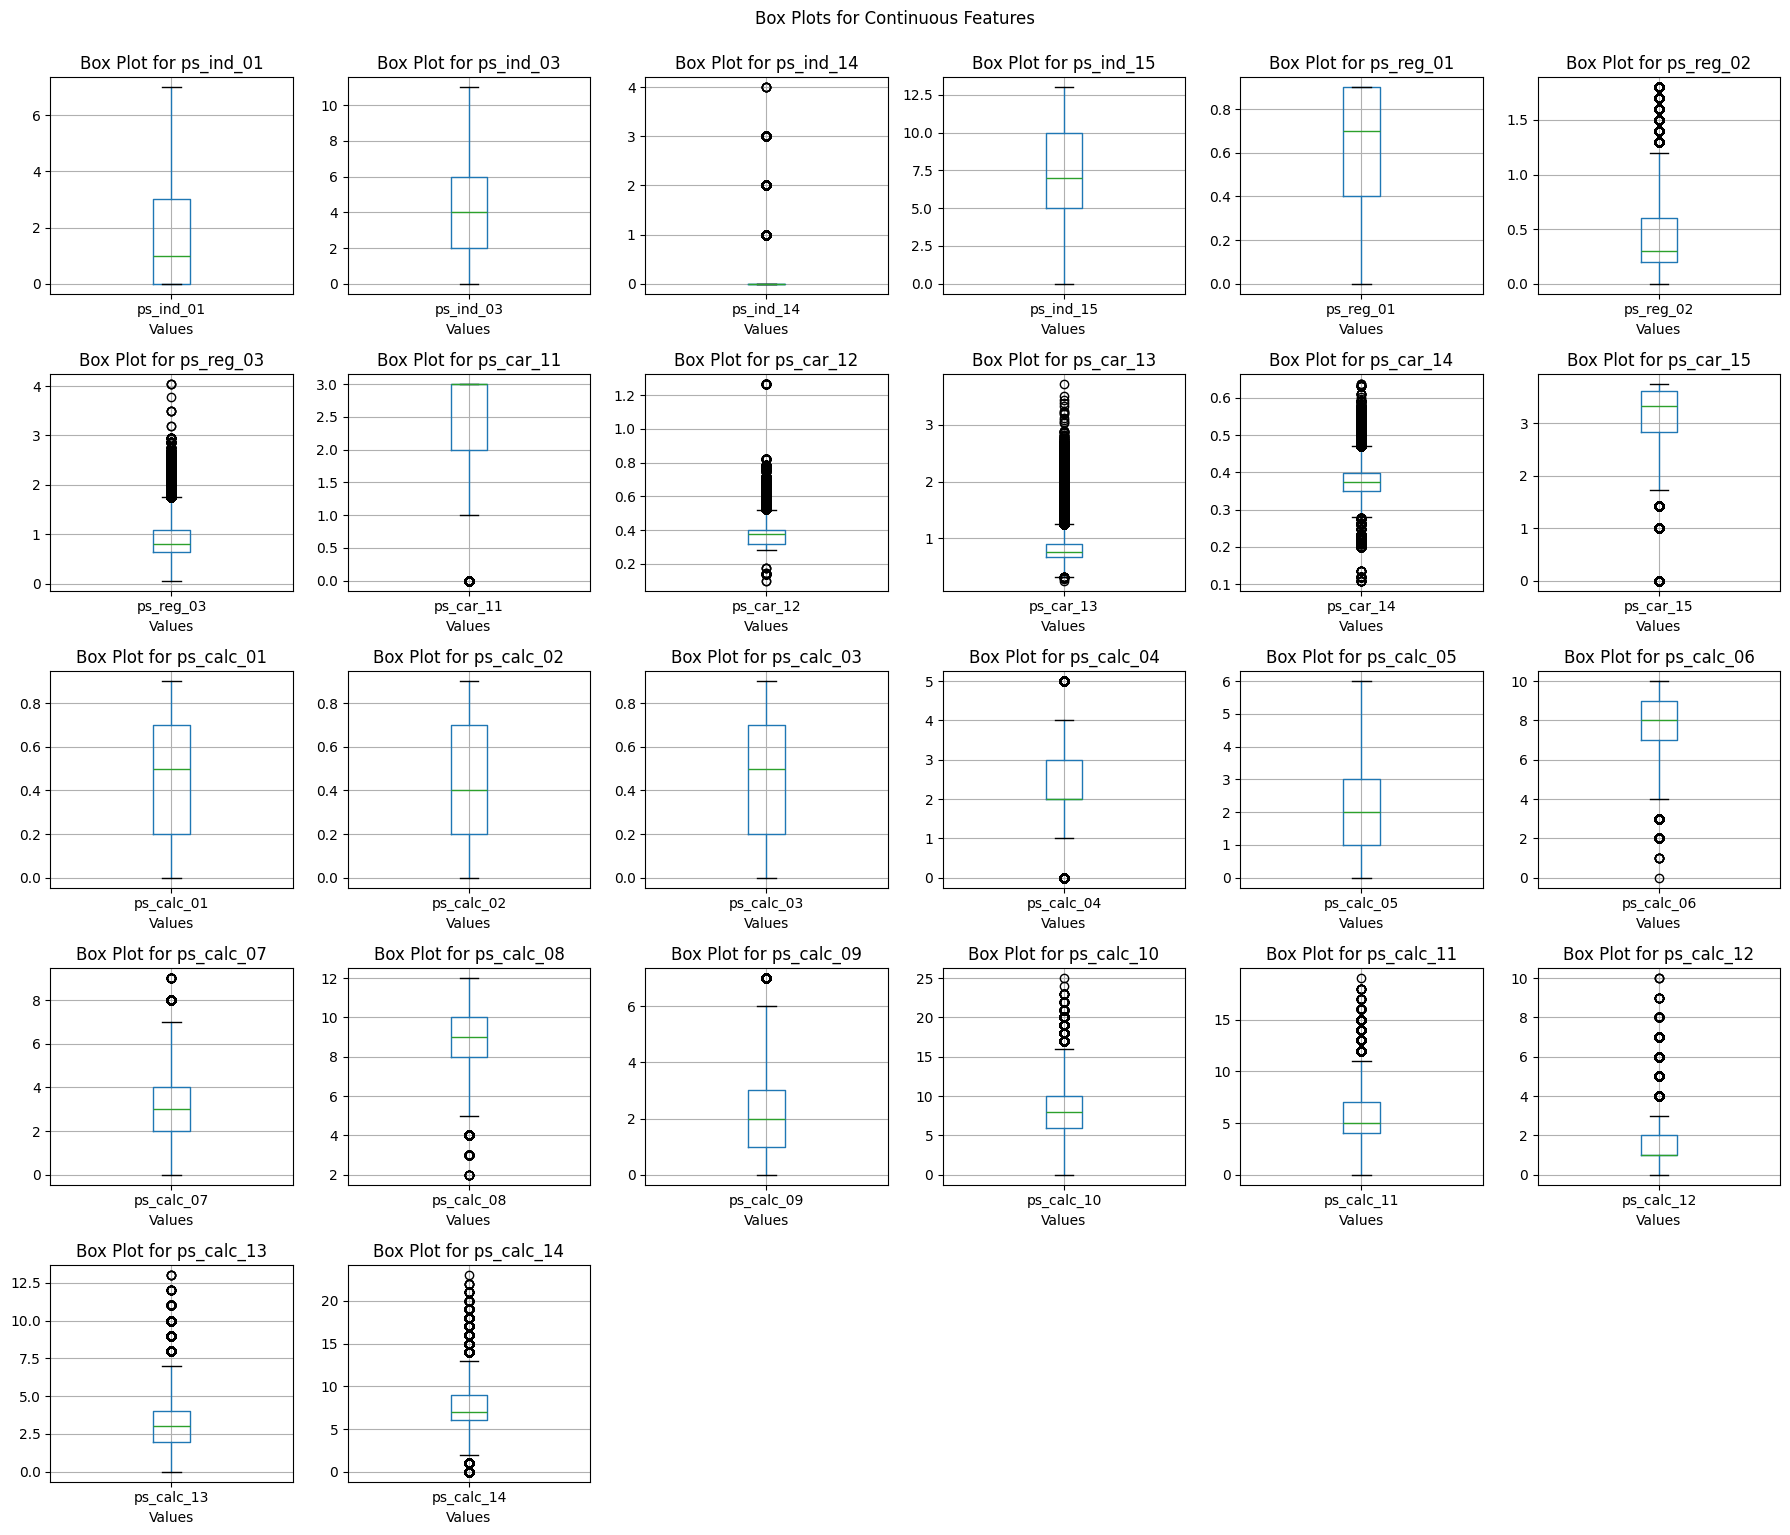

In [ ]:
continuous_columns = metadata_df[metadata_df['Category'] == 'continuous']['Feature Name']

num_plots = len(continuous_columns)
num_rows = 5
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(continuous_columns):
    if idx < len(axes):
        df.boxplot(column=col, ax=axes[idx])
        axes[idx].set_title(f'Box Plot for {col}')
        axes[idx].set_xlabel('Values')

for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle('Box Plots for Continuous Features', y=1.02)
plt.show()

# Splitting

In [116]:
random_state = 42

# 70 - 30 with stratify
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['target'], random_state=42)
X_train = train_df

# 15 - 15 with stratify
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['target'], random_state=42)

X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_val = val_df.drop(columns=['target'])
y_val = val_df['target']

X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

train_target_dist = train_df['target'].value_counts(normalize=True)
val_target_dist = val_df['target'].value_counts(normalize=True)
test_target_dist = test_df['target'].value_counts(normalize=True)

print("Train target distribution:\n", train_target_dist)
print("Validation target distribution:\n", val_target_dist)
print("Test target distribution:\n", test_target_dist)


Train target distribution:
 target
0    0.963552
1    0.036448
Name: proportion, dtype: float64
Validation target distribution:
 target
0    0.963554
1    0.036446
Name: proportion, dtype: float64
Test target distribution:
 target
0    0.963554
1    0.036446
Name: proportion, dtype: float64


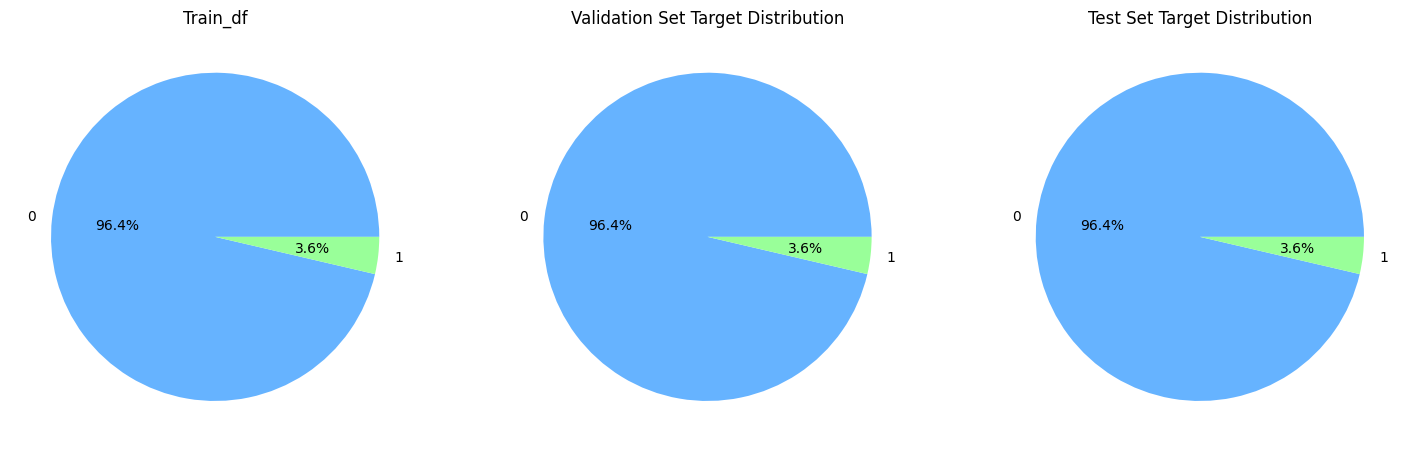

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].pie(train_target_dist, labels=train_target_dist.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
axs[0].set_title('Train_df')

axs[1].pie(val_target_dist, labels=val_target_dist.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
axs[1].set_title('Validation Set Target Distribution')

axs[2].pie(test_target_dist, labels=test_target_dist.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
axs[2].set_title('Test Set Target Distribution')

plt.show()

# Ausreißer einfügen
# orginal als X_train_orginal
# Ausreißer als X_train

Überprüfen der Verteilungen der Features in Trainings-, Validierungs- und Testdatensatz

# EDA II

## NA Imputation, Encoder, Scaler (Aanlyse)

In [ ]:
# Pipelines für Encoder und Scaler testen
encoders = [
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
]

scalers = [
    ('minmax', MinMaxScaler()),
    ('standard', StandardScaler())
]

# Mögliche NA-Imputationsmethoden für kategoriale und numerische Daten
cat_imputation_methods = ['most_frequent', 'constant', 'forward_fill', 'backward_fill']
num_imputation_methods = ['mean', 'median', 'forward_fill', 'backward_fill']

best_roc_auc = 0
best_params = None
total_runs = 0  # Zählvariable für die Gesamtanzahl der Läufe
report_interval = 5  # Anzahl der Läufe nach denen Zwischenergebnisse ausgegeben werden

# Schleife über alle Kombinationen von Encoder, Scaler und Imputation
for encoder_name, encoder in encoders:
    for scaler_name, scaler in scalers:
        for cat_imputer in cat_imputation_methods:
            for num_imputer in num_imputation_methods:
                total_runs += 1  # Inkrementiere die Anzahl der Läufe

                print(f"\n\nTesting combination: Encoder = {encoder_name}, Scaler = {scaler_name}, "
                      f"Categorical Imputer = {cat_imputer}, Numerical Imputer = {num_imputer}")

                # Pipeline für Kategoriale und Numerische Daten
                categorical_transformer = Pipeline(steps=[
                    ('imputer', CustomCategoricalImputer(method=cat_imputer)),  # Kategoriale Imputation
                    ('encoder', encoder)  # Encoder (OneHot oder Ordinal)
                ])

                numerical_transformer = Pipeline(steps=[
                    ('imputer', CustomNumericalImputer(method=num_imputer)),  # Numerische Imputation
                    ('scaler', scaler)  # Scaler (Standard oder MinMax)
                ])

                # ColumnTransformer: Kombiniere kategoriale und numerische Pipelines
                preprocessor = ColumnTransformer(
                    transformers=[
                        ('num', numerical_transformer, continuous_cols),
                        ('cat', categorical_transformer, categorical_cols),
                        ('bin', 'passthrough', binary_cols)
                    ]
                )

                # Finaler Random Forest Classifier mit deinen spezifischen Hyperparametern
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', RandomForestClassifier(
                        n_estimators=100,
                        max_depth=10,
                        min_samples_split=10,
                        min_samples_leaf=4,
                        max_features='sqrt',
                        random_state=42,
                        n_jobs=4
                    ))
                ])

                # Training des Modells auf den Trainingsdaten
                print("Fitting the model...")
                pipeline.fit(X_train_categorical, y_train)

                # Vorhersage auf den Validierungsdaten
                y_pred = pipeline.predict(X_val_categorical)
                y_prob = pipeline.predict_proba(X_val_categorical)[:, 1]

                # Berechnung der ROC AUC
                roc_auc = roc_auc_score(y_val, y_prob)
                print(f"ROC AUC Score for {encoder_name}-{scaler_name}, Categorical Imputer = {cat_imputer}, "
                      f"Numerical Imputer = {num_imputer}: {roc_auc}\n")

                # Speichere die beste Konfiguration
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_params = (encoder_name, scaler_name, cat_imputer, num_imputer)

                # Fortschritt und Zwischenergebnisse anzeigen
                if total_runs % report_interval == 0:  # Zwischenergebnisse nach jeder 'report_interval' Anzahl von Läufen
                    print(f"\n\n--- Intermediate Results after {total_runs} runs ---")
                    print(f"Current Best AUC Score: {best_roc_auc}")
                    print(f"Best combination so far: {best_params}\n")

# Endergebnis ausgeben
print(f"\n\nBest Encoder-Scaler-NA Imputer Combination: {best_params} with ROC AUC: {best_roc_auc}")




Testing combination: Encoder = onehot, Scaler = minmax, Categorical Imputer = most_frequent, Numerical Imputer = mean
Fitting the model...
ROC AUC Score for onehot-minmax, Categorical Imputer = most_frequent, Numerical Imputer = mean: 0.6297268811352253



Testing combination: Encoder = onehot, Scaler = minmax, Categorical Imputer = most_frequent, Numerical Imputer = median
Fitting the model...
ROC AUC Score for onehot-minmax, Categorical Imputer = most_frequent, Numerical Imputer = median: 0.6299333754173717



Testing combination: Encoder = onehot, Scaler = minmax, Categorical Imputer = most_frequent, Numerical Imputer = forward_fill
Fitting the model...
ROC AUC Score for onehot-minmax, Categorical Imputer = most_frequent, Numerical Imputer = forward_fill: 0.62941600909285



Testing combination: Encoder = onehot, Scaler = minmax, Categorical Imputer = most_frequent, Numerical Imputer = backward_fill
Fitting the model...
ROC AUC Score for onehot-minmax, Categorical Imputer = most_f

1. Ordinal: Best Encoder-Scaler-NA Imputer Combination: ('ordinal', 'standard', 'most_frequent', 'forward_fill') with ROC AUC: 0.6321892481997756
2. One-Hot: ('onehot', 'minmax', 'constant', 'median') Current Best AUC Score: 0.6317929420729473


Best Hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'} with ROC AUC: 0.6335571580602579

1. Ordinal: Best Encoder-Scaler-NA Imputer Combination: ('ordinal', 'standard', 'most_frequent', 'forward_fill') with ROC AUC: 0.6321892481997756
2. One-Hot: ('onehot', 'minmax', 'constant', 'median') Current Best AUC Score: 0.6317929420729473
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'} with ROC AUC: 0.6335571580602579

## Kategoriale Analyse

In [ ]:
categorical_features_above_10 = []

for col in categorical_features.columns:
    unique_values_count = df[col].nunique()

    if unique_values_count > 10:
        categorical_features_above_10.append(col)
        categorical_features_above_10.append(unique_values_count)


print("Kategorische Features mit mehr als 10 verschiedenen Ausprägungen:")
print(categorical_features_above_10)


Kategorische Features mit mehr als 10 verschiedenen Ausprägungen:
['ps_car_01_cat', 12, 'ps_car_06_cat', 18, 'ps_car_11_cat', 104]


ps_car_11_cat
104    85083
103    24262
64     22278
87     17106
32     12578
       ...  
58      1464
81      1433
56      1272
18      1233
63      1103
Name: count, Length: 104, dtype: int64

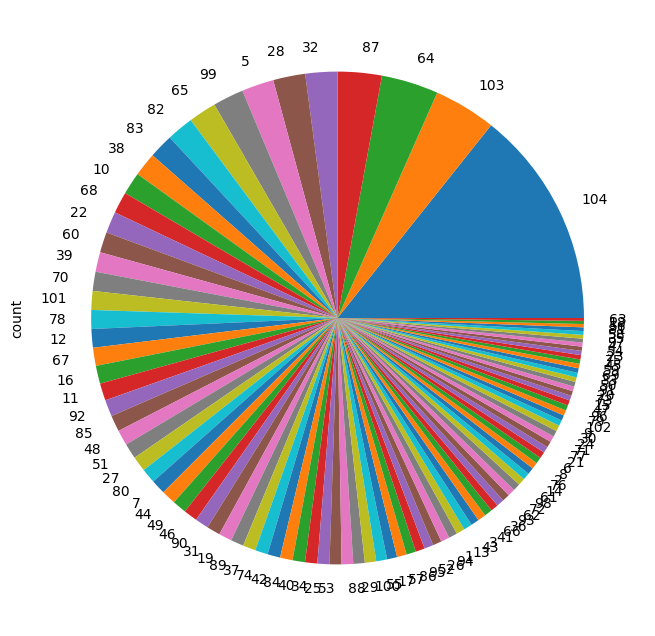

In [ ]:
df['ps_car_11_cat'].value_counts().plot.pie(figsize=(8, 8))
df['ps_car_11_cat'].value_counts()

Hyperparmeter Suche bester Schwellenwert

In [ ]:
# Liste der Schwellenwerte, die getestet werden sollen
threshold_values = np.arange(0.015, 0.02, 0.001)
best_roc_auc = 0
best_threshold = None

# Loop über verschiedene Schwellenwerte
for relative_threshold in threshold_values:
    print(f"Testing threshold: {relative_threshold}")

    # Tiefe Kopien der ursprünglichen Datensätze erstellen
    X_train_categorical = copy.deepcopy(X_train)
    X_val_categorical = copy.deepcopy(X_val)

    # Zähle die Kategorien in den Trainingsdaten
    train_category_counts = X_train_categorical['ps_car_11_cat'].value_counts()

    # Berechne den Schwellenwert für seltene Kategorien im Trainingsdatensatz
    train_threshold_count = relative_threshold * len(X_train_categorical)

    # Identifiziere seltene Kategorien im Trainingsdatensatz
    train_rare_categories = train_category_counts[train_category_counts < train_threshold_count].index

    # Ersetze die ursprüngliche Spalte 'ps_car_11_cat' durch die aggregierte Version im Trainings- und Validierungsdatensatz
    X_train_categorical['ps_car_11_cat'] = X_train_categorical['ps_car_11_cat'].apply(
        lambda x: 'Other' if x in train_rare_categories else x
    )

    X_val_categorical['ps_car_11_cat'] = X_val_categorical['ps_car_11_cat'].apply(
        lambda x: 'Other' if x in train_rare_categories else x  # Gleiche seltene Kategorien wie im Training verwenden
    )

    # Trainiere das Modell
    pipeline_RF_2.fit(X_train_categorical, y_train)

    # Vorhersagen für die Validierungsdaten treffen
    y_pred_RF = pipeline_RF_2.predict(X_val_categorical)
    y_prob_RF = pipeline_RF_2.predict_proba(X_val_categorical)[:, 1]

    # Berechne die ROC AUC für die aktuelle Konfiguration
    roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
    print(f"ROC AUC for threshold {relative_threshold}: {roc_auc_RF}")

    # Speichere die beste Konfiguration
    if roc_auc_RF > best_roc_auc:
        best_roc_auc = roc_auc_RF
        best_threshold = relative_threshold

# Beste Ergebnisse ausgeben
print(f"\nBest threshold: {best_threshold} with ROC AUC: {best_roc_auc}")


Testing threshold: 0.015
ROC AUC for threshold 0.015: 0.63006211596636
Testing threshold: 0.016
ROC AUC for threshold 0.016: 0.6307295992222655
Testing threshold: 0.017


KeyboardInterrupt: 

## Verteilung Test

Continuous Features überprüfen: Mann-Whitney-u

In [ ]:
for col in X_train.select_dtypes(include=["float64", "uint8"]).columns:
    plt.figure(figsize=(4, 2))
    sns.kdeplot(X_train[col], label='Training')
    sns.kdeplot(X_val[col], label='Validation')
    sns.kdeplot(X_test[col], label='Test')
    plt.title(f'Verteilung von {col}')
    plt.legend()
    plt.show()

In [ ]:
# Überprüfen der Continuous Features

results_train_val = []
results_train_test = []

for col in X_train.select_dtypes(include=["float64","uint8"]).columns:
    u_stat_train_val, p_value_train_val = mannwhitneyu(X_train[col], X_val[col], alternative='two-sided')
    u_stat_train_test, p_value_train_test = mannwhitneyu(X_train[col], X_test[col], alternative='two-sided')
    results_train_val.append((col, p_value_train_val))
    results_train_test.append((col, p_value_train_test))

df_results = pd.DataFrame({
    "Feature": [col for col, _ in results_train_val],
    "p-Wert (Train vs Validation)": [p_val for _, p_val in results_train_val],
    "p-Wert (Train vs Test)": [p_val for _, p_val in results_train_test]
})

print(df_results)


In [ ]:
p_val_signifikant = []
p_test_signifikant = []


for col, p_val in results_train_val:
    if p_val < 0.05:
        p_val_signifikant.append([col,p_val])
for col, p_test in results_train_test:
    if p_test < 0.05:
        p_test_signifikant.append([col,p_test])

if p_val_signifikant == []:
    print("Keine signifikanten Abweichungen zwischen Trainings- und Validierungsdaten.")
else:
    print(f"Folgende Features müssen überprüft werden zwischen Trainings- und Validierungsdaten: {p_val_signifikant}")

if p_test_signifikant == []:
    print("Keine signifikanten Abweichungen zwischen Trainings- und Testdaten.")
else:
    print(f"Folgende Features müssen überprüft werden zwischen Trainings- und Testdaten: {p_test_signifikant}")

if p_val_signifikant == [] and p_test_signifikant == []:
    print("Erfolgreich überprüft!")

Kategoriale Features überprüfen

In [ ]:
# DataFrame zur Speicherung der relativen Häufigkeiten
relative_freq_train_val = []
relative_freq_train_test = []
problematic_columns = []

# Vergleich der relativen Häufigkeiten für jede kategoriale Variable
for col in X_train.select_dtypes(include=["object", "category"]).columns:
    freq_train = X_train[col].value_counts(normalize=True)
    freq_val = X_val[col].value_counts(normalize=True)
    freq_test = X_test[col].value_counts(normalize=True)

    # Zusammenführen der Frequenzen in einem DataFrame
    combined = pd.DataFrame({
        'Train': freq_train,
        'Validation': freq_val,
        'Test': freq_test
    }).fillna(0)

    # Berechnen der absoluten Unterschiede
    diff_val = (combined['Train'] - combined['Validation']).abs().sum()
    diff_test = (combined['Train'] - combined['Test']).abs().sum()

    # Ergebnisse speichern
    relative_freq_train_val.append((col, diff_val))
    relative_freq_train_test.append((col, diff_test))

    # Überprüfung, ob der Unterschied größer als 0,1 ist
    if diff_val > 0.1 or diff_test > 0.1:
        problematic_columns.append(col)

# Erstellen des DataFrames für die Ergebnisse
df_relative_freq = pd.DataFrame({
    "Feature": [col for col, _ in relative_freq_train_val],
    "Absoluter Unterschied (Train vs Validation)": [diff for _, diff in relative_freq_train_val],
    "Absoluter Unterschied (Train vs Test)": [diff for _, diff in relative_freq_train_test]
})

# Ausgabe des DataFrames
print(df_relative_freq)

# Ausgabe der Spalten mit Problemen
if problematic_columns:
    print("\nDie folgenden Spalten haben einen Unterschied größer als 0,1:")
    for col in problematic_columns:
        print(col)
else:
    print("\nAlle Unterschiede sind kleiner oder gleich 0.1.")


In [ ]:
# Anzahl der getesteten numerischen Spalten (floats,uints)
num_floats_tested = len(X_train.select_dtypes(include=["float64","uint8"]).columns)

# Anzahl der getesteten kategorialen Spalten
num_categorical_tested = len(X_train.select_dtypes(include=["object", "category"]).columns)

# Berechnung der Gesamtsumme der getesteten Spalten
total_columns_tested = num_floats_tested + num_categorical_tested

# Gesamtanzahl der Spalten im Datensatz X
total_columns_X = X_train.shape[1]

# Ausgabe der Anzahl der getesteten Spalten, der Gesamtsumme und Vergleich mit Gesamtanzahl
print(f"Anzahl der getesteten numerischen Spalten: {num_floats_tested}")
print(f"Anzahl der getesteten kategorialen Spalten: {num_categorical_tested}")
print(f"Gesamtanzahl der getesteten Spalten: {total_columns_tested}")
print(f"Gesamtanzahl der Spalten im Datensatz: {total_columns_X}")

# Überprüfung, ob alle Spalten getestet wurden
if total_columns_tested == total_columns_X:
    print("Alle Spalten wurden getestet.")
else:
    print("Nicht alle Spalten wurden getestet.")

## Duplicates

In [ ]:
duplicates = X_train.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

0

## NA Imputation

Categorical Features:

    Last Observation Carried Forward (LOCF): Forward filling
    Next Observation Carried Backward (NOCB): Backward filling

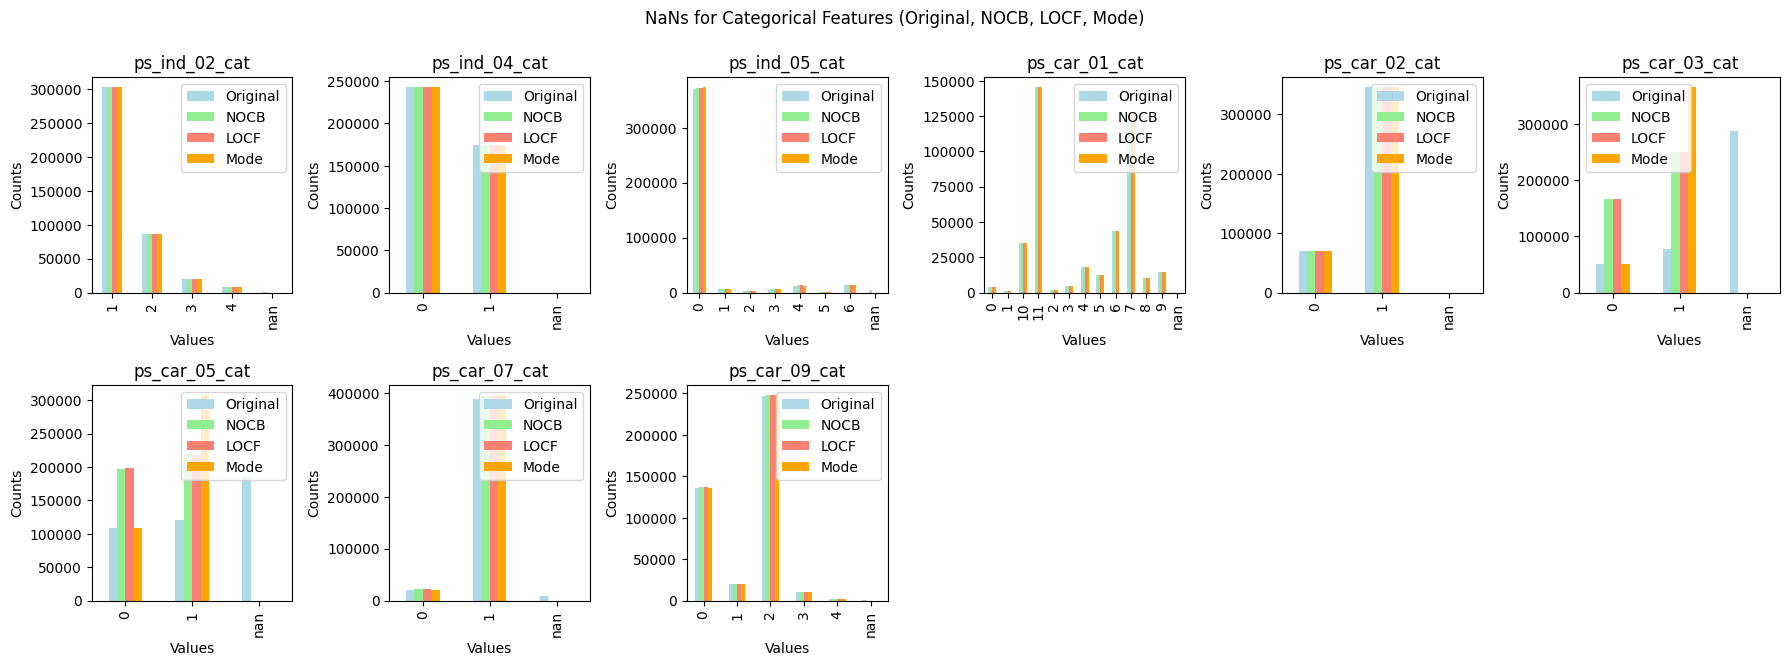

In [ ]:
# Filter mithilfe von Metadaten
categorical_features_with_nas = metadata_df[
    (metadata_df['Category'] == 'categorical') &
    (metadata_df['NAs'] == True)
]['Feature Name'].tolist()

num_plots = len(categorical_features_with_nas)
num_rows = 5
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features_with_nas):
    if idx < len(axes):
        X_train[feature] = X_train[feature].astype(str).replace('nan', np.nan)

        X_train = X_train.assign(
            original=X_train[feature],
            nocb=X_train[feature].bfill(),
            locf=X_train[feature].ffill(),
            mode=X_train[feature].fillna(X_train[feature].mode()[0])
        )

        counts_original = X_train['original'].value_counts(dropna=False).sort_index()
        counts_nocb = X_train['nocb'].value_counts(dropna=False).sort_index()
        counts_locf = X_train['locf'].value_counts(dropna=False).sort_index()
        counts_mode = X_train['mode'].value_counts(dropna=False).sort_index()

        counts = pd.DataFrame({
            'Original': counts_original,
            'NOCB': counts_nocb,
            'LOCF': counts_locf,
            'Mode': counts_mode
        }).fillna(0)

        counts.plot(kind='bar', ax=axes[idx], color=['lightblue', 'lightgreen', 'salmon', 'orange'])
        axes[idx].set_title(f'{feature}')
        axes[idx].set_xlabel('Values')
        axes[idx].set_ylabel('Counts')

for ax in axes[num_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle('NaNs for Categorical Features (Original, NOCB, LOCF, Mode)', y=1.02)
plt.show()

==> Ist das überhaupt Sinvoll? müssen es dann im Pipeline prüfen

Continous Features:

    Last Observation Carried Forward (LOCF): Forward filling
    Next Observation Carried Backward (NOCB): Backward filling
    Linear interpolation
    Spline interpolation

In [ ]:
metadata_df[(metadata_df['NAs']==True) & (metadata_df['Category']=='continuous')]

Feature Name Data Type    Category Context   NAs   NAs_n       Min  \
20    ps_reg_03   float64  continuous     reg  True  107772  0.061237   
32    ps_car_11   float64  continuous     car  True       5       0.0   
33    ps_car_12   float64  continuous     car  True       1       0.1   
35    ps_car_14   float64  continuous     car  True   42620  0.109545   

         Max  
20  4.037945  
32       3.0  
33  1.264911  
35  0.636396

ps_reg_03

In [ ]:
X_train['ps_reg_03'].isna().sum()

75462

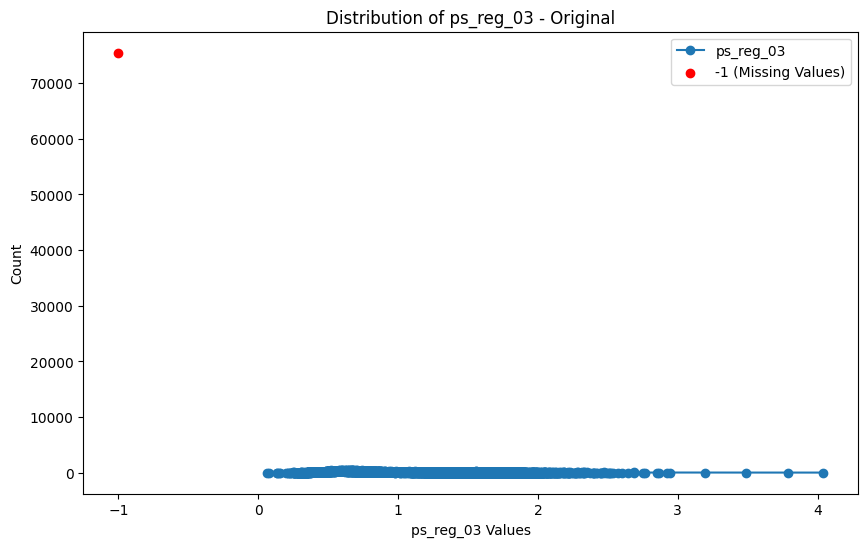

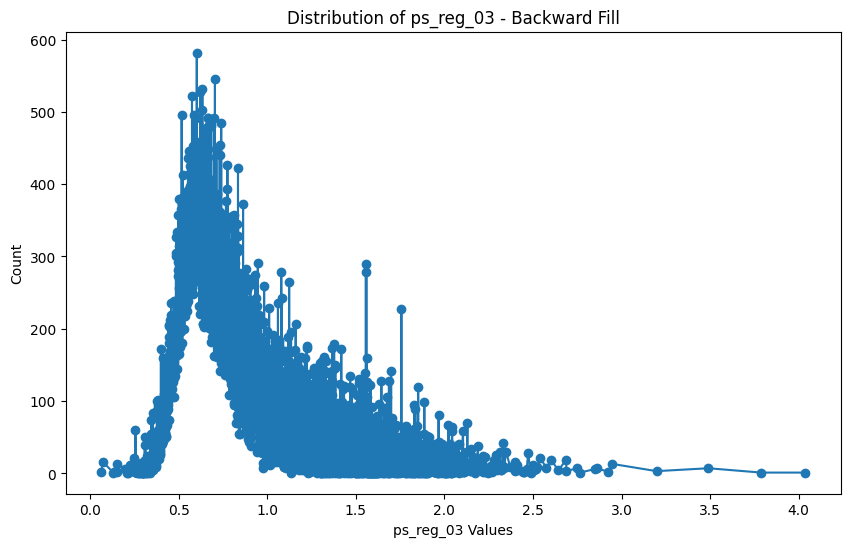

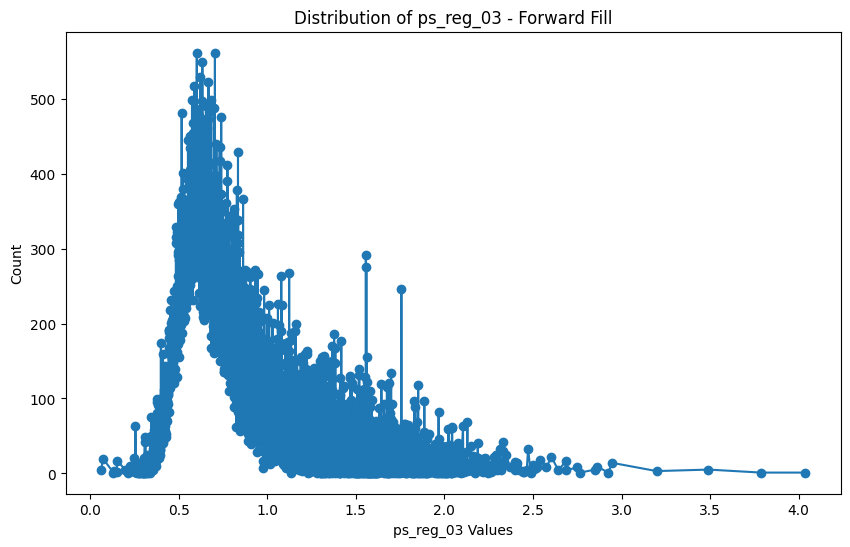

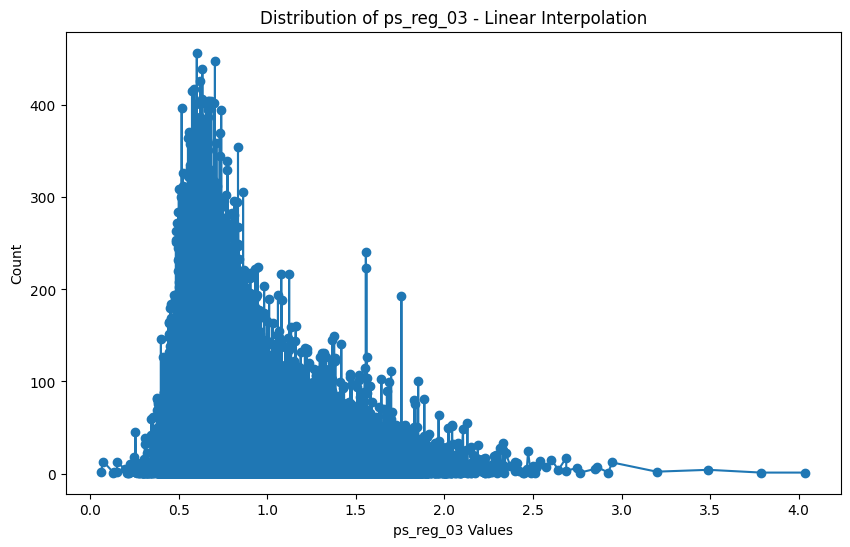

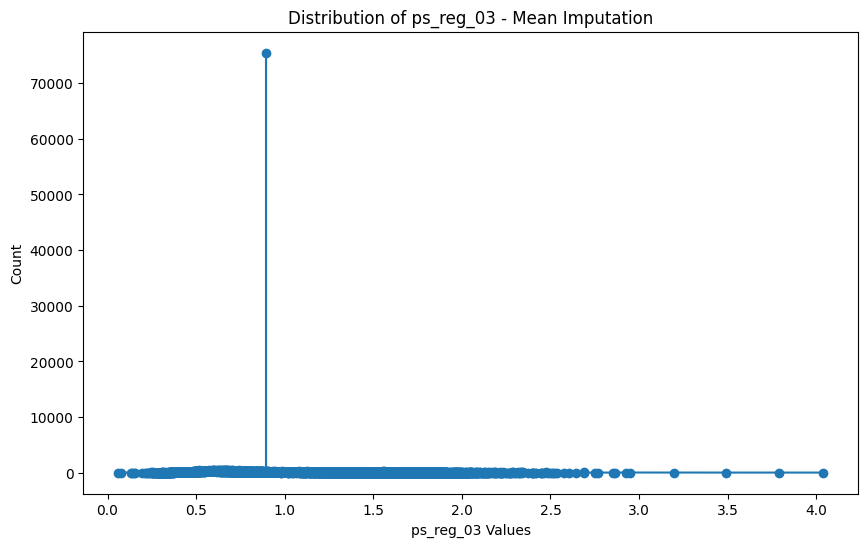

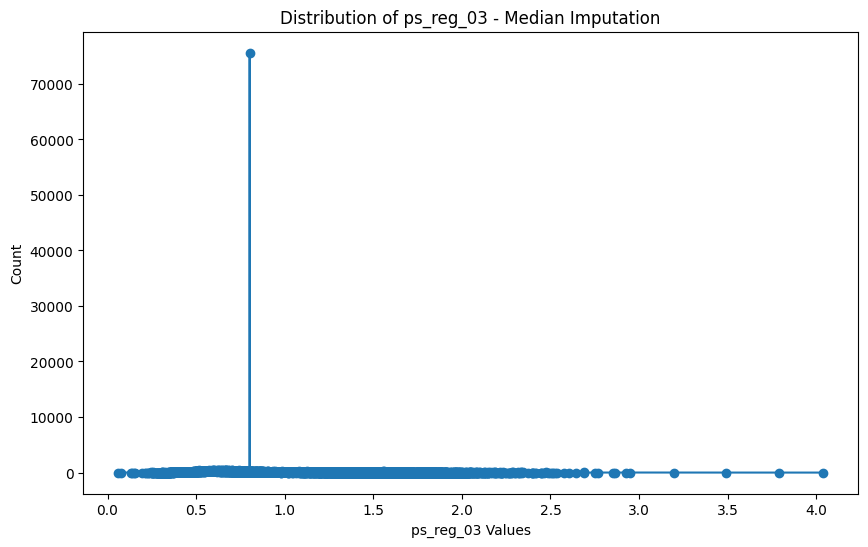

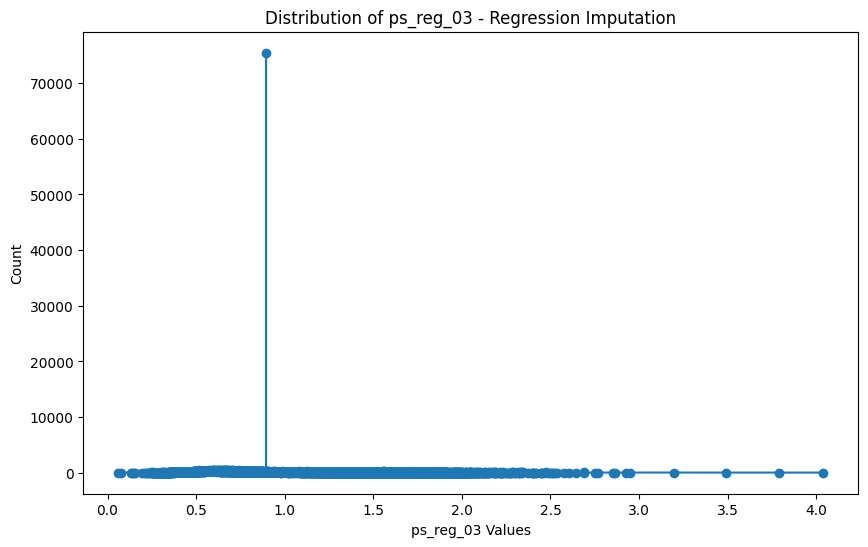

In [ ]:
X_train_replaced = X_train.replace(np.nan, -1)

replaced_value_counts = X_train_replaced["ps_reg_03"].value_counts().sort_index()

negative_one_count = replaced_value_counts.loc[-1] if -1 in replaced_value_counts.index else 0
replaced_value_counts_without_negative_one = replaced_value_counts.drop(-1, errors='ignore')

plt.figure(figsize=(10, 6))
plt.plot(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values, marker="o", linestyle="-", label="ps_reg_03")

if negative_one_count > 0:
    plt.scatter([-1], [negative_one_count], color='red', label="-1 (Missing Values)", zorder=5)

plt.title("Distribution of ps_reg_03 - Original")
plt.xlabel("ps_reg_03 Values")
plt.ylabel("Count")
plt.legend()
plt.show()

regression_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)

methods = {
    "Backward Fill": lambda df_: df_["ps_reg_03"].replace(-1, np.nan).bfill(),
    "Forward Fill": lambda df_: df_["ps_reg_03"].replace(-1, np.nan).ffill(),
    "Linear Interpolation": lambda df_: df_["ps_reg_03"].replace(-1, np.nan).interpolate(method="linear"),
    "Mean Imputation": lambda df_: df_["ps_reg_03"].replace(-1, df_["ps_reg_03"].replace(-1, np.nan).mean()),
    "Median Imputation": lambda df_: df_["ps_reg_03"].replace(-1, df_["ps_reg_03"].replace(-1, np.nan).median()),
    "Regression Imputation": lambda df_: regression_imputer.fit_transform(df_[["ps_reg_03"]].replace(-1 , np.nan)).flatten()
}

for method_name, method_func in methods.items():
    plt.figure(figsize=(10, 6))
    ps_reg_03_method = method_func(X_train_replaced)
    value_counts = pd.Series(ps_reg_03_method).value_counts().sort_index()

    plt.plot(value_counts.index, value_counts.values, marker="o", linestyle="-")
    plt.title(f"Distribution of ps_reg_03 - {method_name}")
    plt.xlabel("ps_reg_03 Values")
    plt.ylabel("Count")
    plt.show()


In [ ]:
X_train['ps_reg_03'].describe()

count    341186.000000
mean          0.894577
std           0.345604
min           0.061237
25%           0.633936
50%           0.802340
75%           1.085127
max           4.037945
Name: ps_reg_03, dtype: float64

ps_car_11

In [ ]:
X_train['ps_car_11'].isna().sum()

3

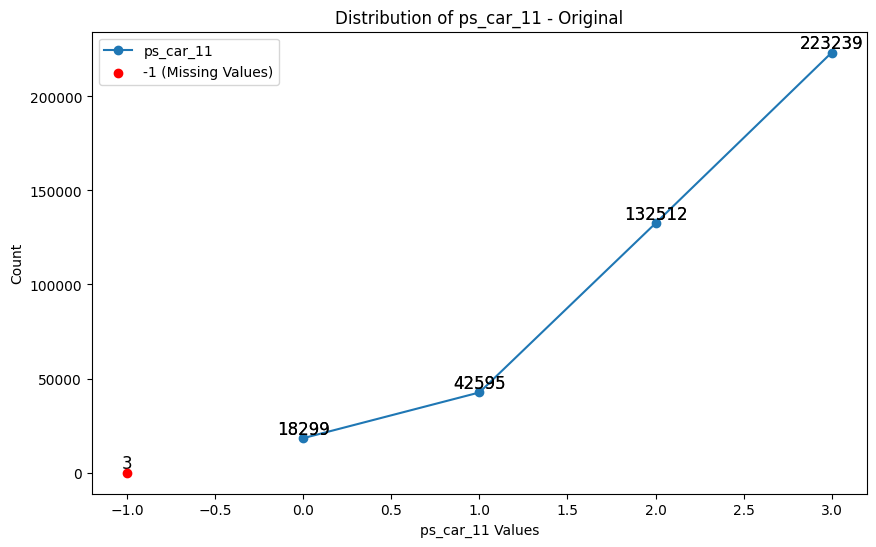

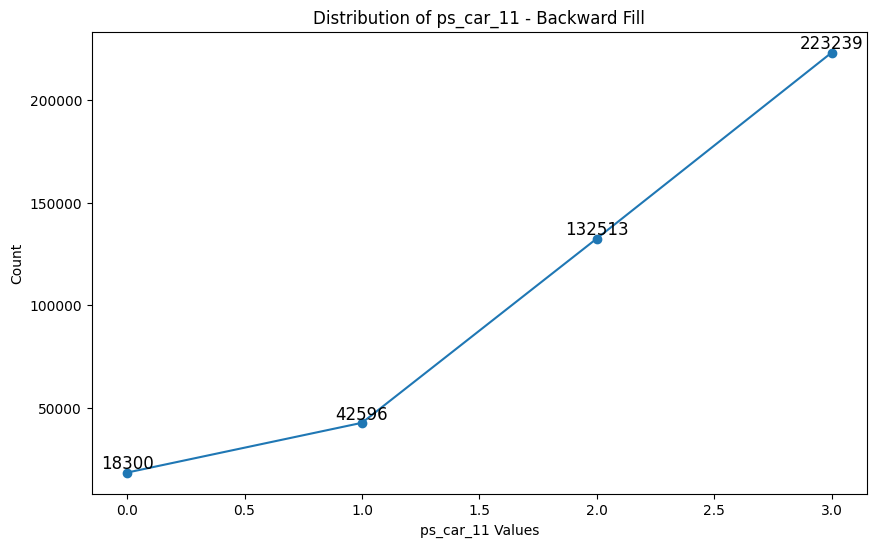

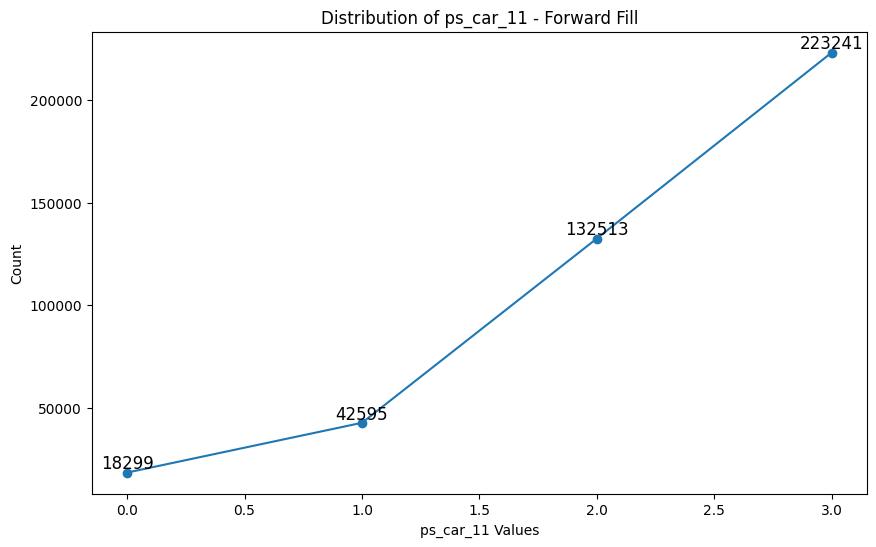

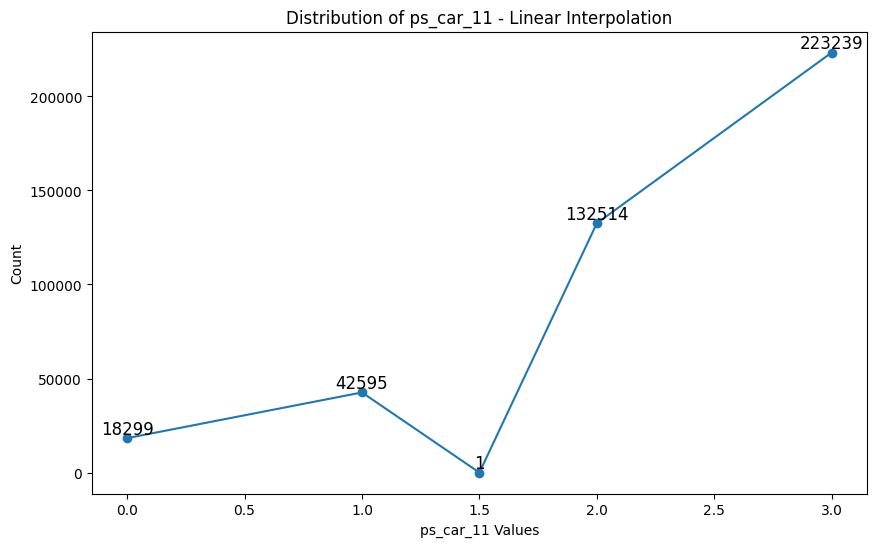

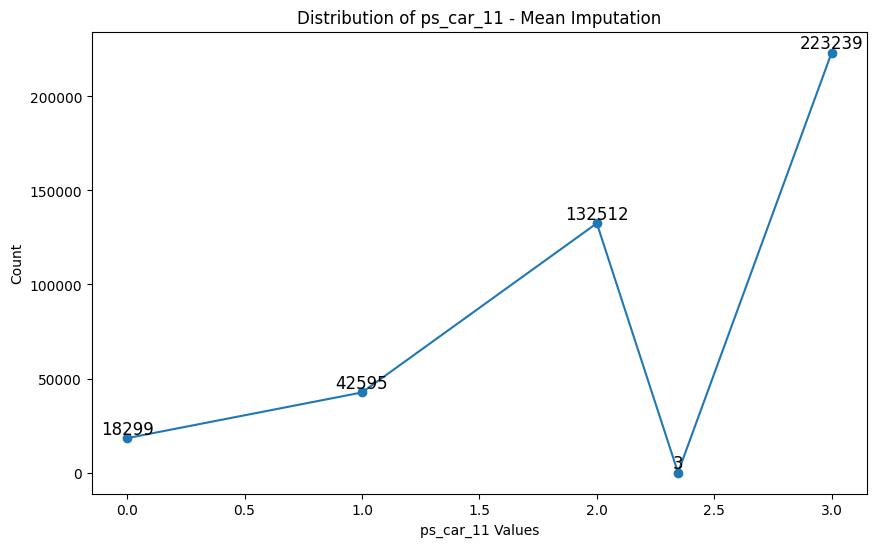

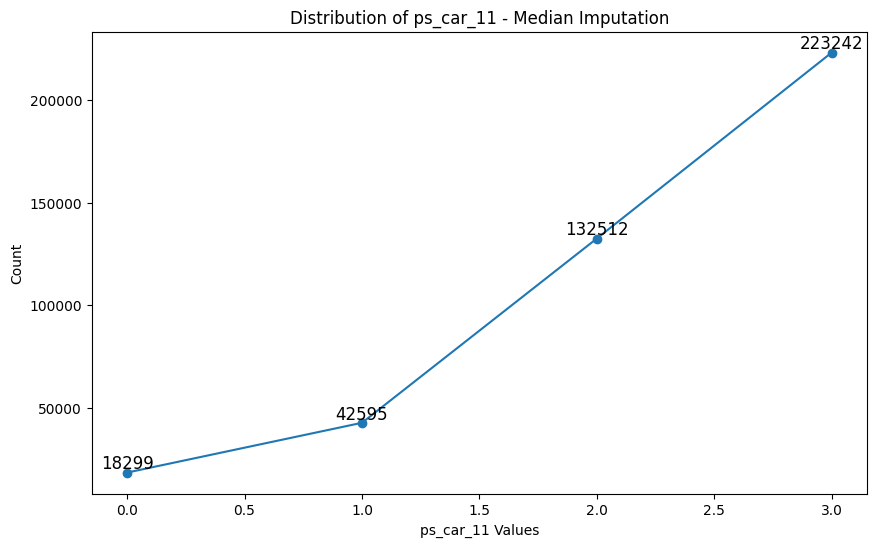

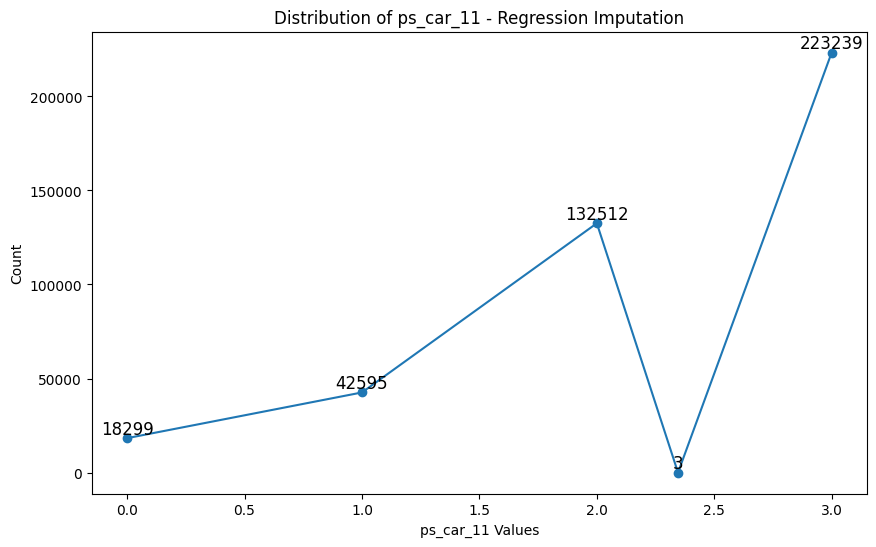

In [ ]:
X_train_replaced = X_train.replace(np.nan, -1)

replaced_value_counts = X_train_replaced["ps_car_11"].value_counts().sort_index()

negative_one_count = replaced_value_counts.loc[-1] if -1 in replaced_value_counts.index else 0
replaced_value_counts_without_negative_one = replaced_value_counts.drop(-1, errors='ignore')

plt.figure(figsize=(10, 6))
plt.plot(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values, marker="o", linestyle="-", label="ps_car_11")

# Neuer Code: Anzahlen auf den x-Werten anzeigen
for i, (x, y) in enumerate(zip(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values)):
    plt.text(x, y, str(y), fontsize=12, ha='center', va='bottom')

for i, (x, y) in enumerate(zip(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values)):
    plt.text(x, y, str(y), fontsize=12, ha='center', va='bottom')

if negative_one_count > 0:
    plt.scatter([-1], [negative_one_count], color='red', label="-1 (Missing Values)", zorder=5)
    # Neuer Code: Anzahl der -1-Werte anzeigen
    plt.text(-1, negative_one_count, str(negative_one_count), fontsize=12, ha='center', va='bottom')

plt.title("Distribution of ps_car_11 - Original")
plt.xlabel("ps_car_11 Values")
plt.ylabel("Count")
plt.legend()
plt.show()

regression_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)

methods = {
    "Backward Fill": lambda df_: df_["ps_car_11"].replace(-1, np.nan).bfill(),
    "Forward Fill": lambda df_: df_["ps_car_11"].replace(-1, np.nan).ffill(),
    "Linear Interpolation": lambda df_: df_["ps_car_11"].replace(-1, np.nan).interpolate(method="linear"),
    "Mean Imputation": lambda df_: df_["ps_car_11"].replace(-1, df_["ps_car_11"].replace(-1, np.nan).mean()),
    "Median Imputation": lambda df_: df_["ps_car_11"].replace(-1, df_["ps_car_11"].replace(-1, np.nan).median()),
    "Regression Imputation": lambda df_: regression_imputer.fit_transform(df_[["ps_car_11"]].replace(-1 , np.nan)).flatten()
}

for method_name, method_func in methods.items():
    plt.figure(figsize=(10, 6))
    ps_car_11_method = method_func(X_train_replaced)
    value_counts = pd.Series(ps_car_11_method).value_counts().sort_index()

    plt.plot(value_counts.index, value_counts.values, marker="o", linestyle="-")

    # Neuer Code: Anzahlen auf den x-Werten anzeigen
    for i, (x, y) in enumerate(zip(value_counts.index, value_counts.values)):
        plt.text(x, y, str(y), fontsize=12, ha='center', va='bottom')

    plt.title(f"Distribution of ps_car_11 - {method_name}")
    plt.xlabel("ps_car_11 Values")
    plt.ylabel("Count")
    plt.show()


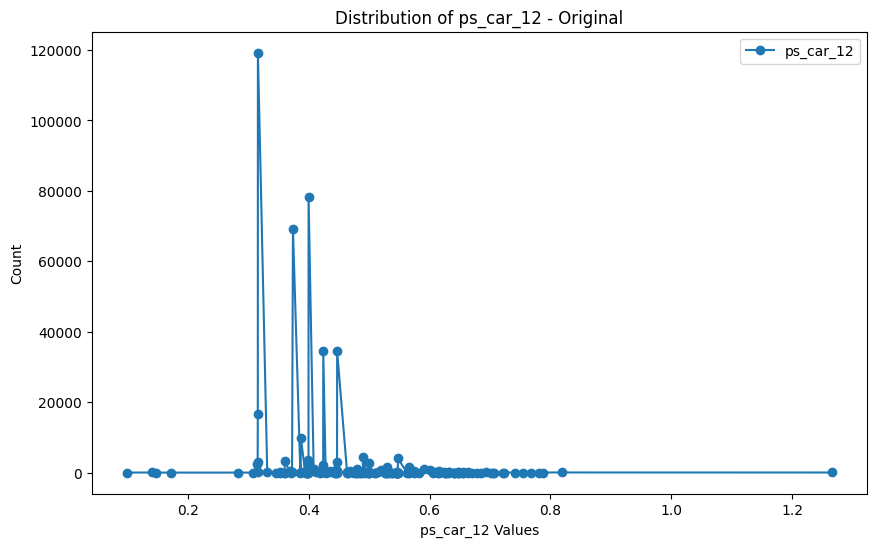

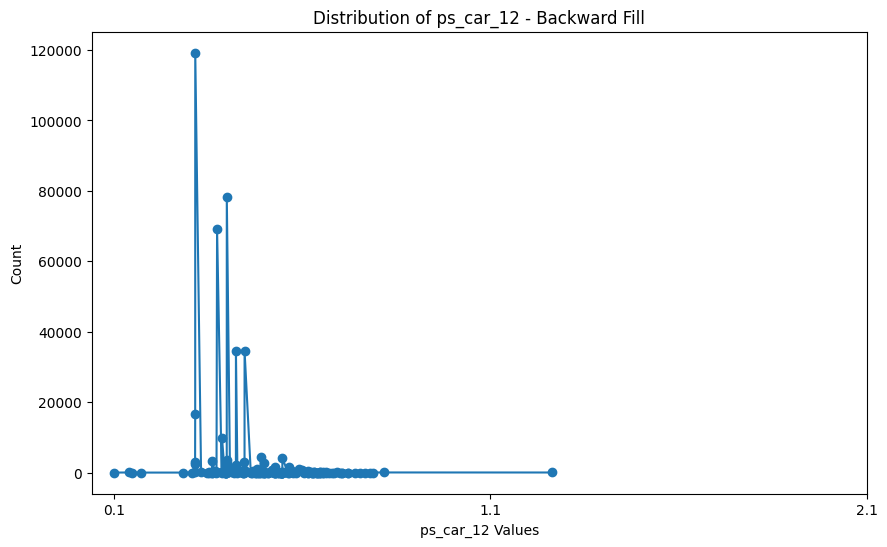

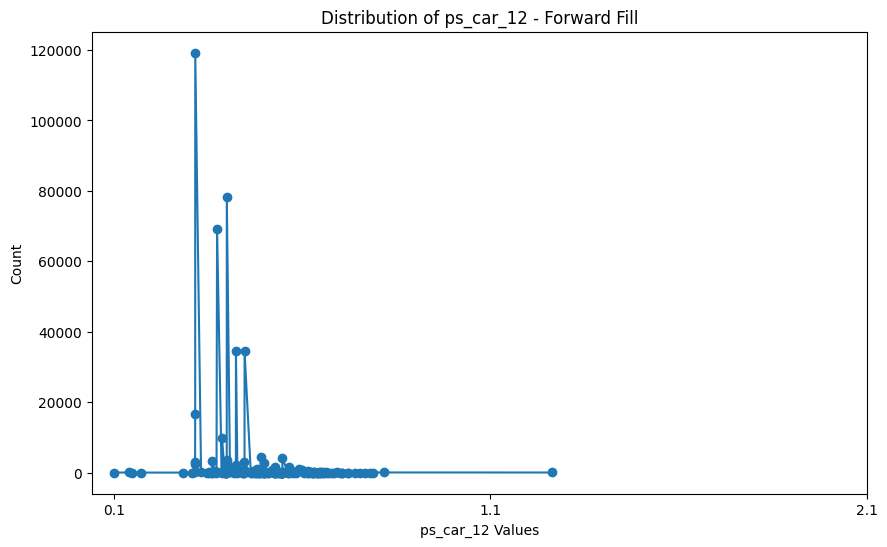

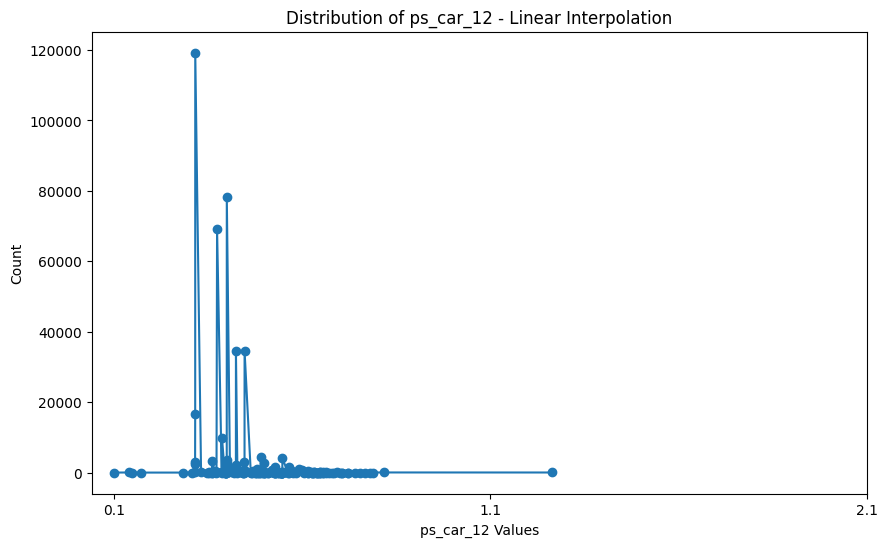

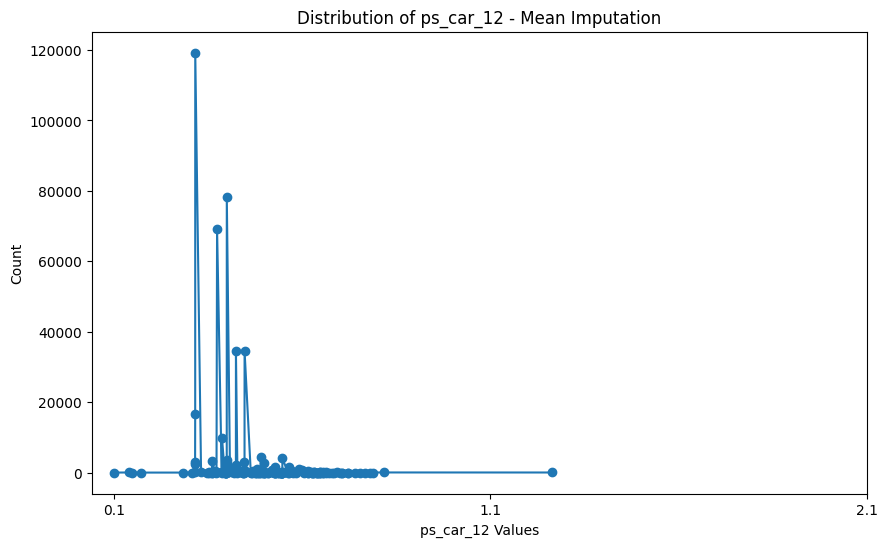

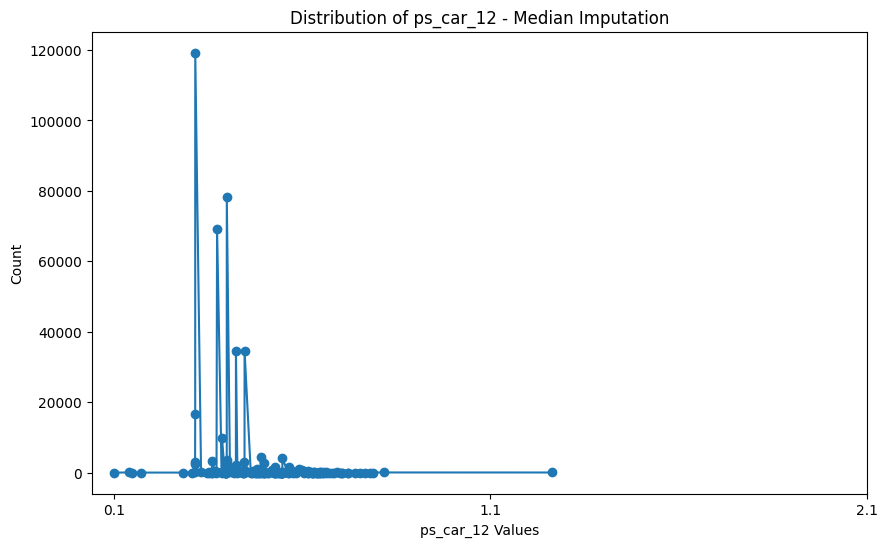

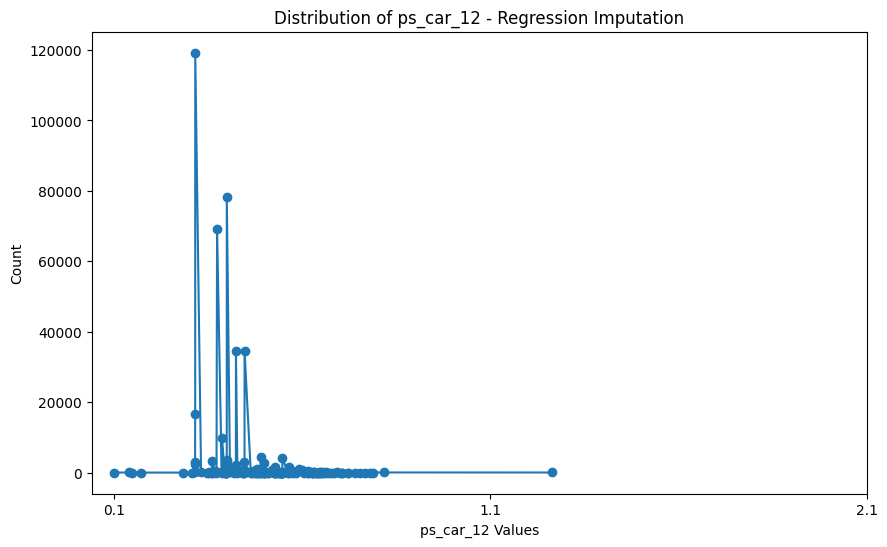

In [ ]:
X_train_replaced = X_train.replace(np.nan, -1)

replaced_value_counts = X_train_replaced["ps_car_12"].value_counts().sort_index()

negative_one_count = replaced_value_counts.loc[-1] if -1 in replaced_value_counts.index else 0
replaced_value_counts_without_negative_one = replaced_value_counts.drop(-1, errors='ignore')

plt.figure(figsize=(10, 6))
plt.plot(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values, marker="o", linestyle="-", label="ps_car_12")

if negative_one_count > 0:
    plt.scatter([-1], [negative_one_count], color='red', label="-1 (Missing Values)", zorder=5)

plt.title("Distribution of ps_car_12 - Original")
plt.xlabel("ps_car_12 Values")
plt.ylabel("Count")
plt.legend()
plt.show()

regression_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)

methods = {
    "Backward Fill": lambda df_: df_["ps_car_12"].replace(-1, np.nan).bfill(),
    "Forward Fill": lambda df_: df_["ps_car_12"].replace(-1, np.nan).ffill(),
    "Linear Interpolation": lambda df_: df_["ps_car_12"].replace(-1, np.nan).interpolate(method="linear"),
    "Mean Imputation": lambda df_: df_["ps_car_12"].replace(-1, df_["ps_car_12"].replace(-1, np.nan).mean()),
    "Median Imputation": lambda df_: df_["ps_car_12"].replace(-1, df_["ps_car_12"].replace(-1, np.nan).median()),
    "Regression Imputation": lambda df_: regression_imputer.fit_transform(df_[["ps_car_12"]].replace(-1, np.nan)).flatten()
}

for method_name, method_func in methods.items():
    plt.figure(figsize=(10, 6))
    ps_car_12_method = method_func(X_train_replaced)
    value_counts = pd.Series(ps_car_12_method).value_counts().sort_index()

    plt.plot(value_counts.index, value_counts.values, marker="o", linestyle="-")

    plt.title(f"Distribution of ps_car_12 - {method_name}")
    plt.xlabel("ps_car_12 Values")
    plt.ylabel("Count")
    plt.xticks(ticks=np.arange(value_counts.index.min(), value_counts.index.max()+1, 1))
    plt.show()



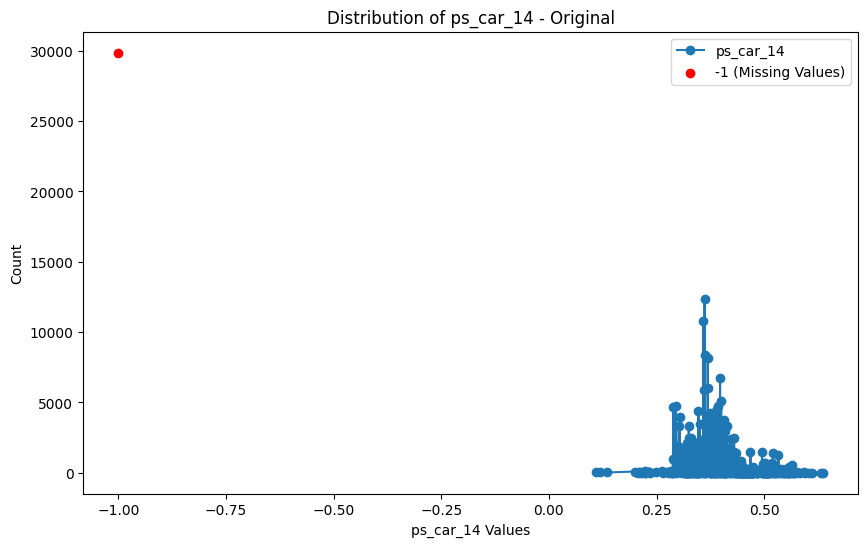

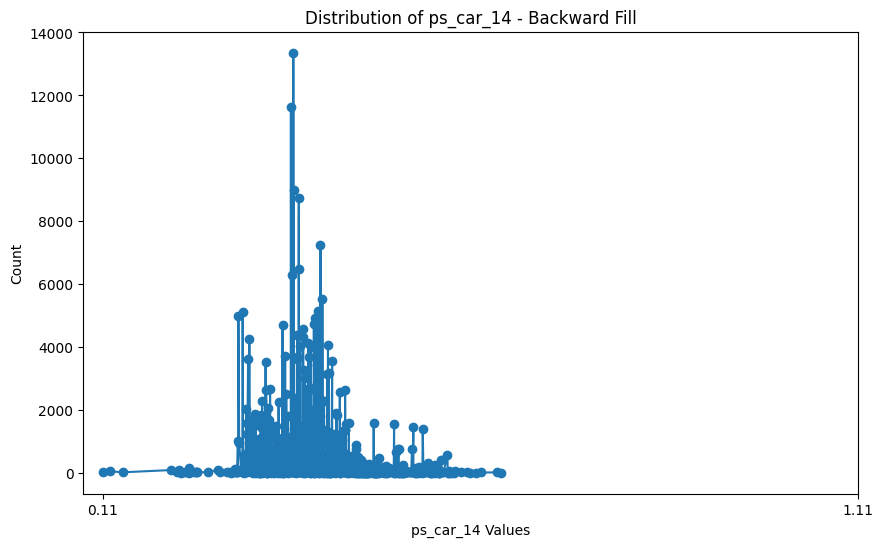

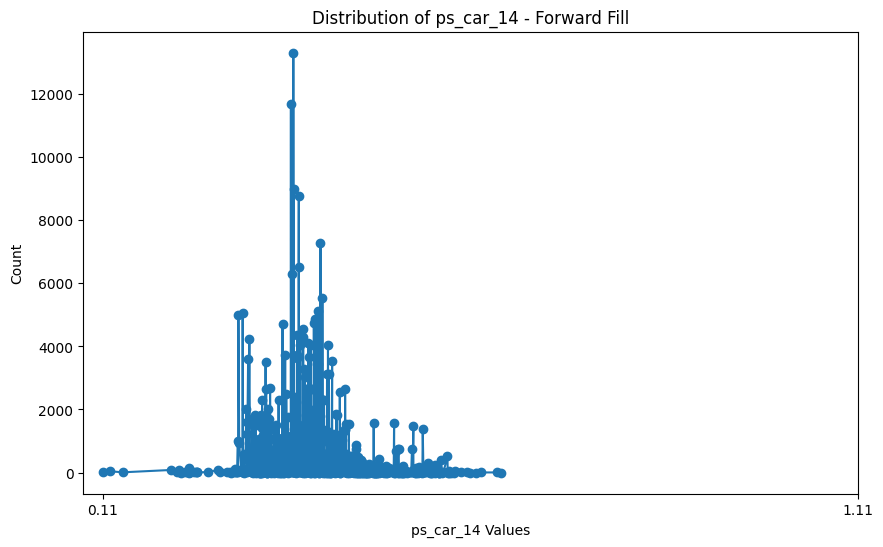

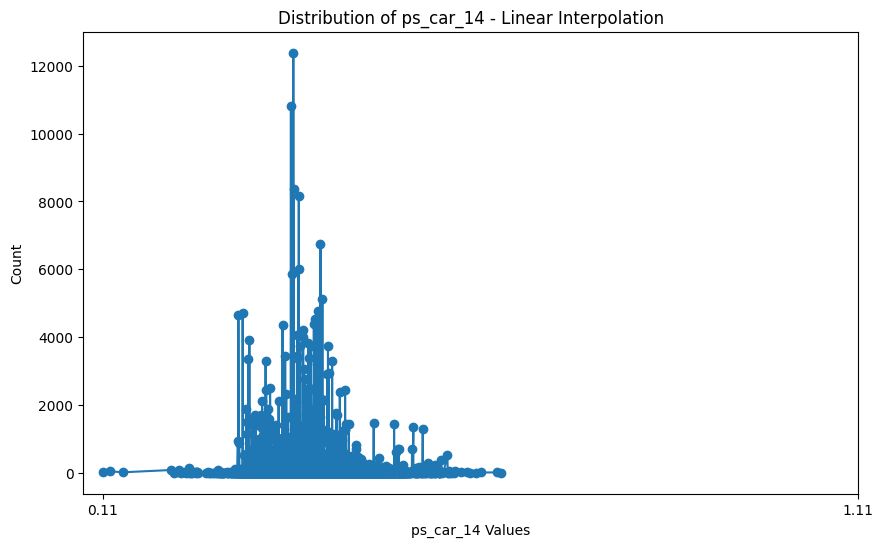

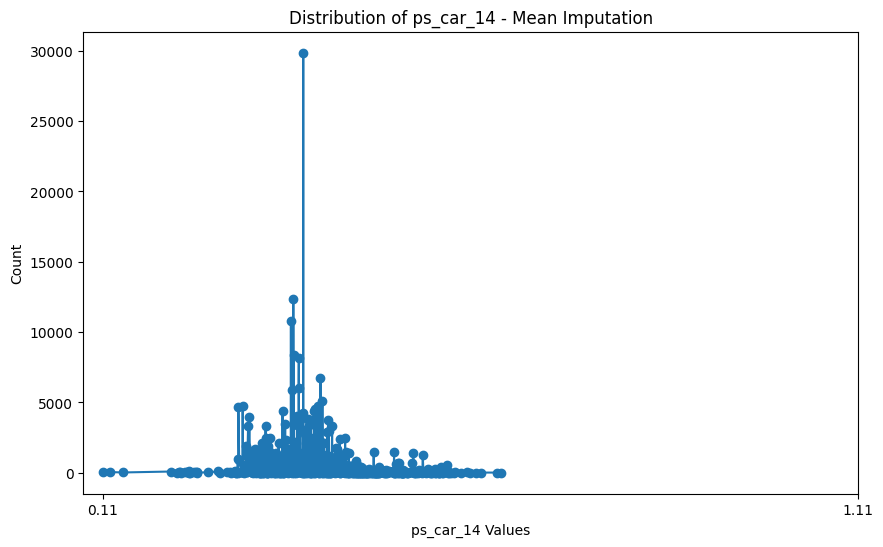

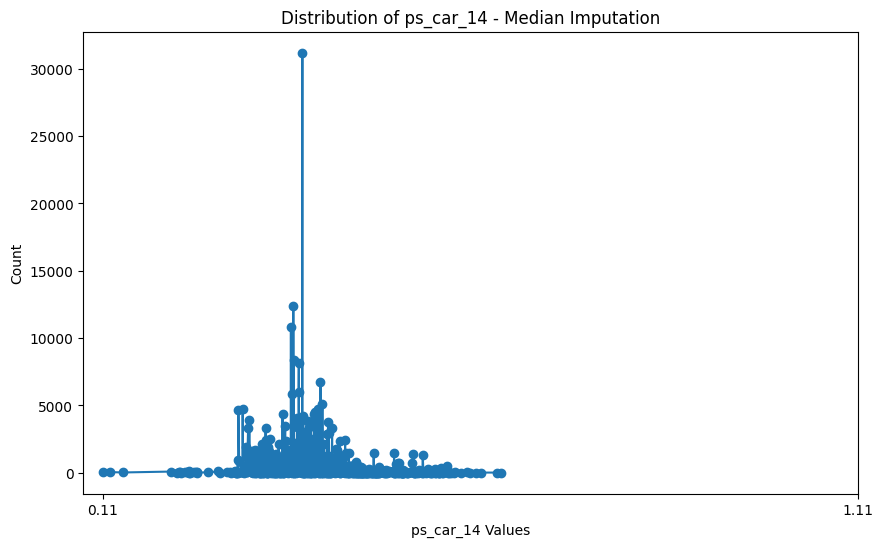

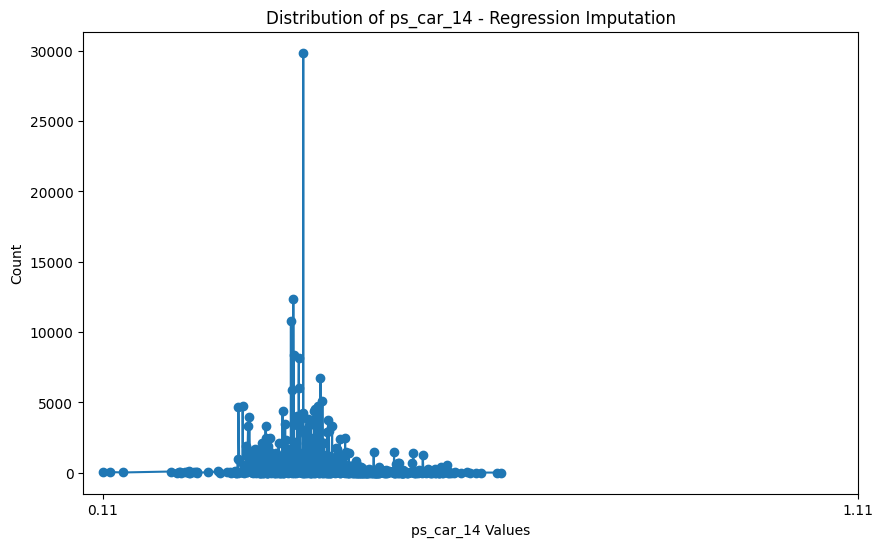

In [ ]:
X_train_replaced = X_train.replace(np.nan, -1)

replaced_value_counts = X_train_replaced["ps_car_14"].value_counts().sort_index()

negative_one_count = replaced_value_counts.loc[-1] if -1 in replaced_value_counts.index else 0
replaced_value_counts_without_negative_one = replaced_value_counts.drop(-1, errors='ignore')

plt.figure(figsize=(10, 6))
plt.plot(replaced_value_counts_without_negative_one.index, replaced_value_counts_without_negative_one.values, marker="o", linestyle="-", label="ps_car_14")

if negative_one_count > 0:
    plt.scatter([-1], [negative_one_count], color='red', label="-1 (Missing Values)", zorder=5)

plt.title("Distribution of ps_car_14 - Original")
plt.xlabel("ps_car_14 Values")
plt.ylabel("Count")
plt.legend()
plt.show()

regression_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)

methods = {
    "Backward Fill": lambda df_: df_["ps_car_14"].replace(-1, np.nan).bfill(),
    "Forward Fill": lambda df_: df_["ps_car_14"].replace(-1, np.nan).ffill(),
    "Linear Interpolation": lambda df_: df_["ps_car_14"].replace(-1, np.nan).interpolate(method="linear"),
    "Mean Imputation": lambda df_: df_["ps_car_14"].replace(-1, df_["ps_car_14"].replace(-1, np.nan).mean()),
    "Median Imputation": lambda df_: df_["ps_car_14"].replace(-1, df_["ps_car_14"].replace(-1, np.nan).median()),
    "Regression Imputation": lambda df_: regression_imputer.fit_transform(df_[["ps_car_14"]].replace(-1, np.nan)).flatten()
}

for method_name, method_func in methods.items():
    plt.figure(figsize=(10, 6))
    ps_car_14_method = method_func(X_train_replaced)
    value_counts = pd.Series(ps_car_14_method).value_counts().sort_index()

    plt.plot(value_counts.index, value_counts.values, marker="o", linestyle="-")

    plt.title(f"Distribution of ps_car_14 - {method_name}")
    plt.xlabel("ps_car_14 Values")
    plt.ylabel("Count")
    plt.xticks(ticks=np.arange(value_counts.index.min(), value_counts.index.max()+1, 1))
    plt.show()


## Standardization / Normalization

StandardScaler Method

In [ ]:
print(X_train)

from sklearn.preprocessing import StandardScaler

# numerical Data Type
numerical = X_train.select_dtypes(include=['float64', 'int64']).columns

# DataFrame with only numerical Data Type
X_train_numerical = X_train[numerical]

scaler = StandardScaler()

# Transform numerical data type
X_train_numerical_standardized = scaler.fit_transform(X_train_numerical)

# numpy array to a DataFrame
X_train_numerical_standardized = pd.DataFrame(X_train_numerical_standardized, columns=numerical)

print(X_train_numerical_standardized.head())

# Check mean and standard deviation of the standardized data
print("\nMean of standardized data:\n", X_train_numerical_standardized.mean())
print("\nStandard deviation of standardized data:\n", X_train_numerical_standardized.std())



NameError: name 'X_train' is not defined

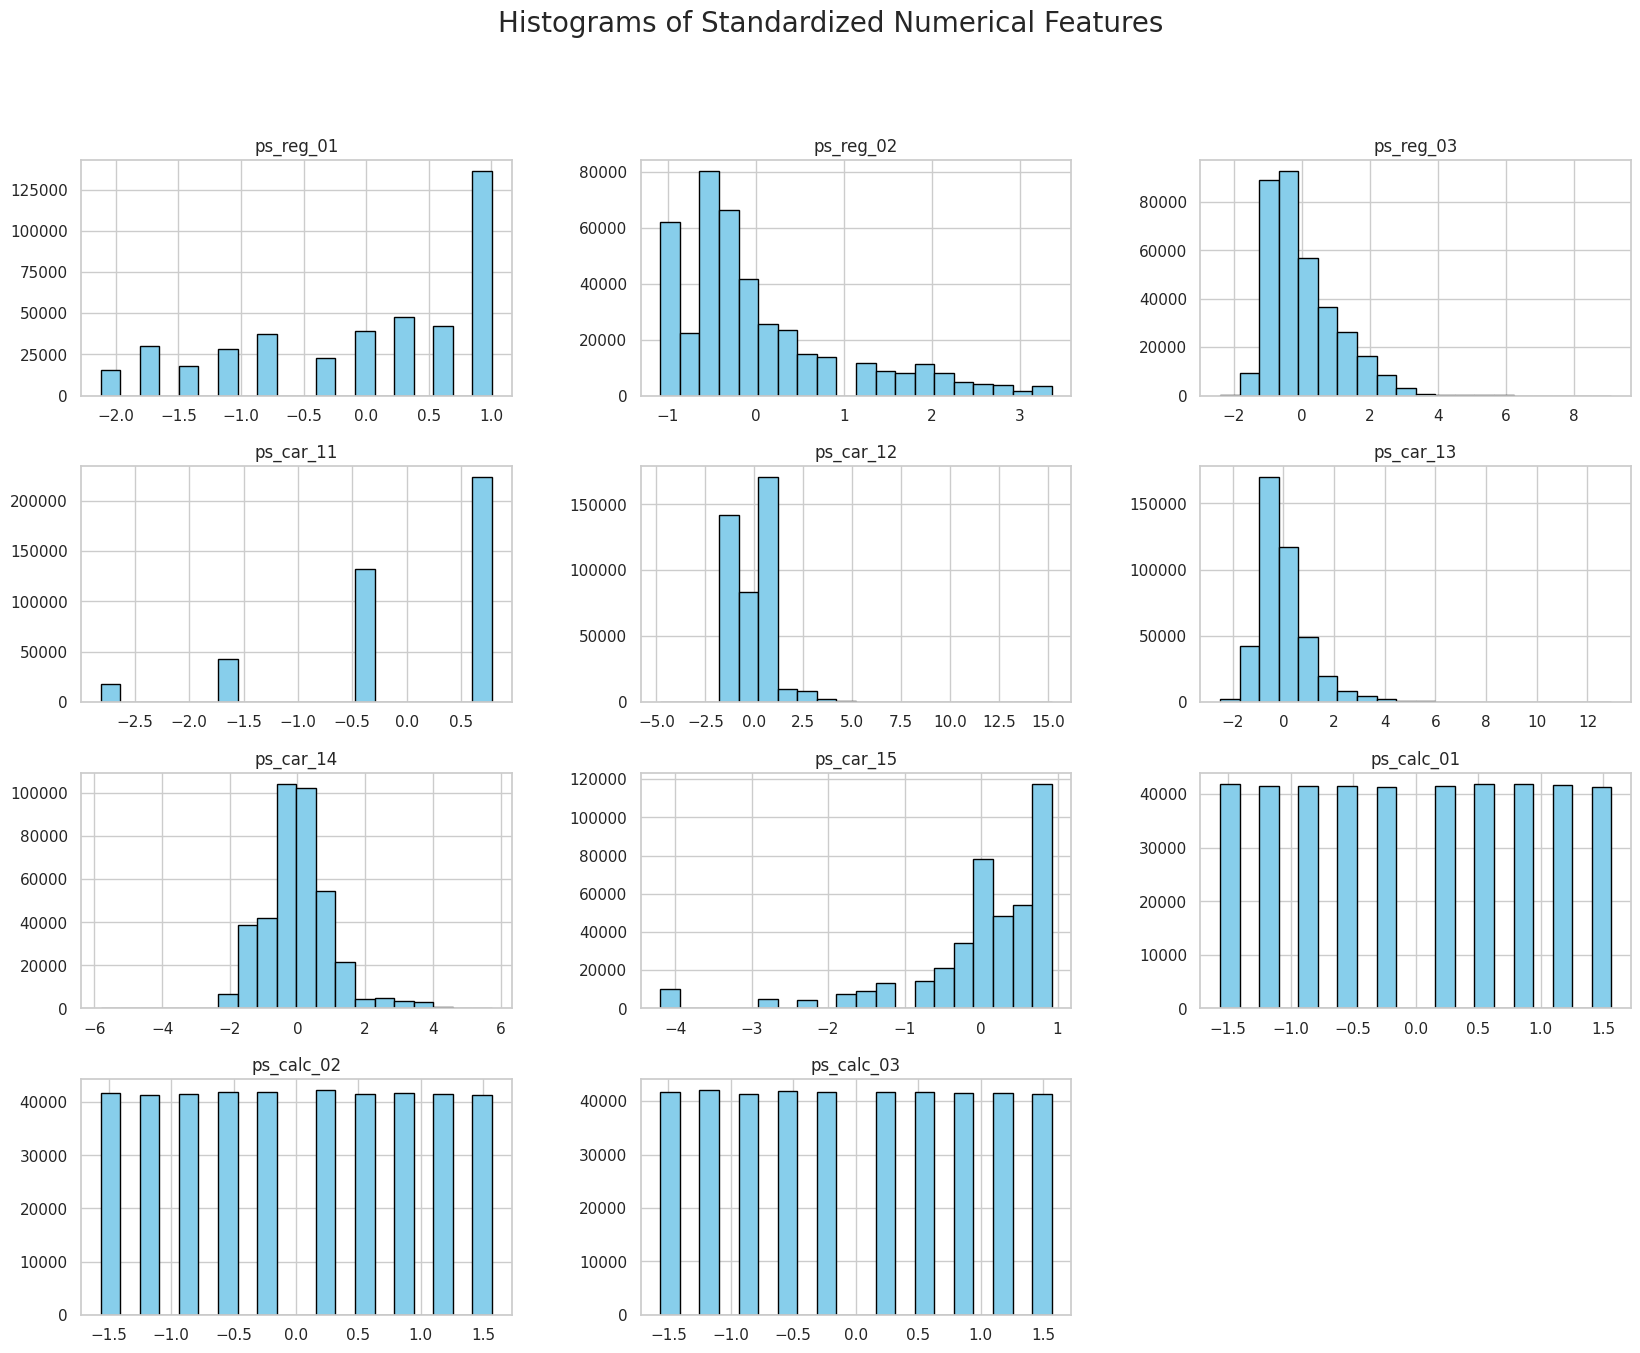

In [ ]:
sns.set(style="whitegrid")

X_train_numerical_standardized.hist(bins=20, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Standardized Numerical Features', fontsize=20)
plt.show()



MinMaxScaler Method

> Add blockquote



In [ ]:
#  numerical Data Type
numerical = X_train.select_dtypes(include=['int64', 'float64', 'uint8'])

scaler = MinMaxScaler()

# Fit and transform the numerical data
X_train_minmax = scaler.fit_transform(numerical)

# Convert numpy array to DataFrame
X_train_minmax = pd.DataFrame(X_train_minmax, columns=numerical.columns)


print(X_train_minmax.head())

# Check the min and max values of the scaled data
print("\nMin values of scaled data:\n", X_train_minmax.min())
print("\nMax values of scaled data:\n", X_train_minmax.max())

   ps_ind_01  ps_ind_03  ps_ind_14  ps_ind_15  ps_reg_01  ps_reg_02  \
0   0.142857   0.636364        0.0   0.538462   1.000000   0.166667   
1   0.714286   0.272727        0.0   0.538462   0.777778   0.111111   
2   0.428571   0.636364        0.0   0.846154   0.222222   0.166667   
3   0.285714   0.454545        0.0   0.846154   0.666667   0.111111   
4   0.714286   0.454545        0.0   0.461538   1.000000   0.166667   

   ps_reg_03  ps_car_11  ps_car_12  ps_car_13  ps_car_14  ps_car_15  \
0        NaN   0.666667   0.257530   0.207331        NaN   1.000000   
1   0.134164   1.000000   0.298060   0.159773   0.598030   0.801784   
2        NaN   1.000000   0.235353   0.153840   0.533782   0.886405   
3   0.147083   0.666667   0.185617   0.146080   0.504801   0.886405   
4   0.147932   0.666667   0.288340   0.167052   0.578116   0.845154   

   ps_calc_01  ps_calc_02  ps_calc_03  ps_calc_04  ps_calc_05  ps_calc_06  \
0    0.555556    0.333333    0.222222         0.8    0.166667        

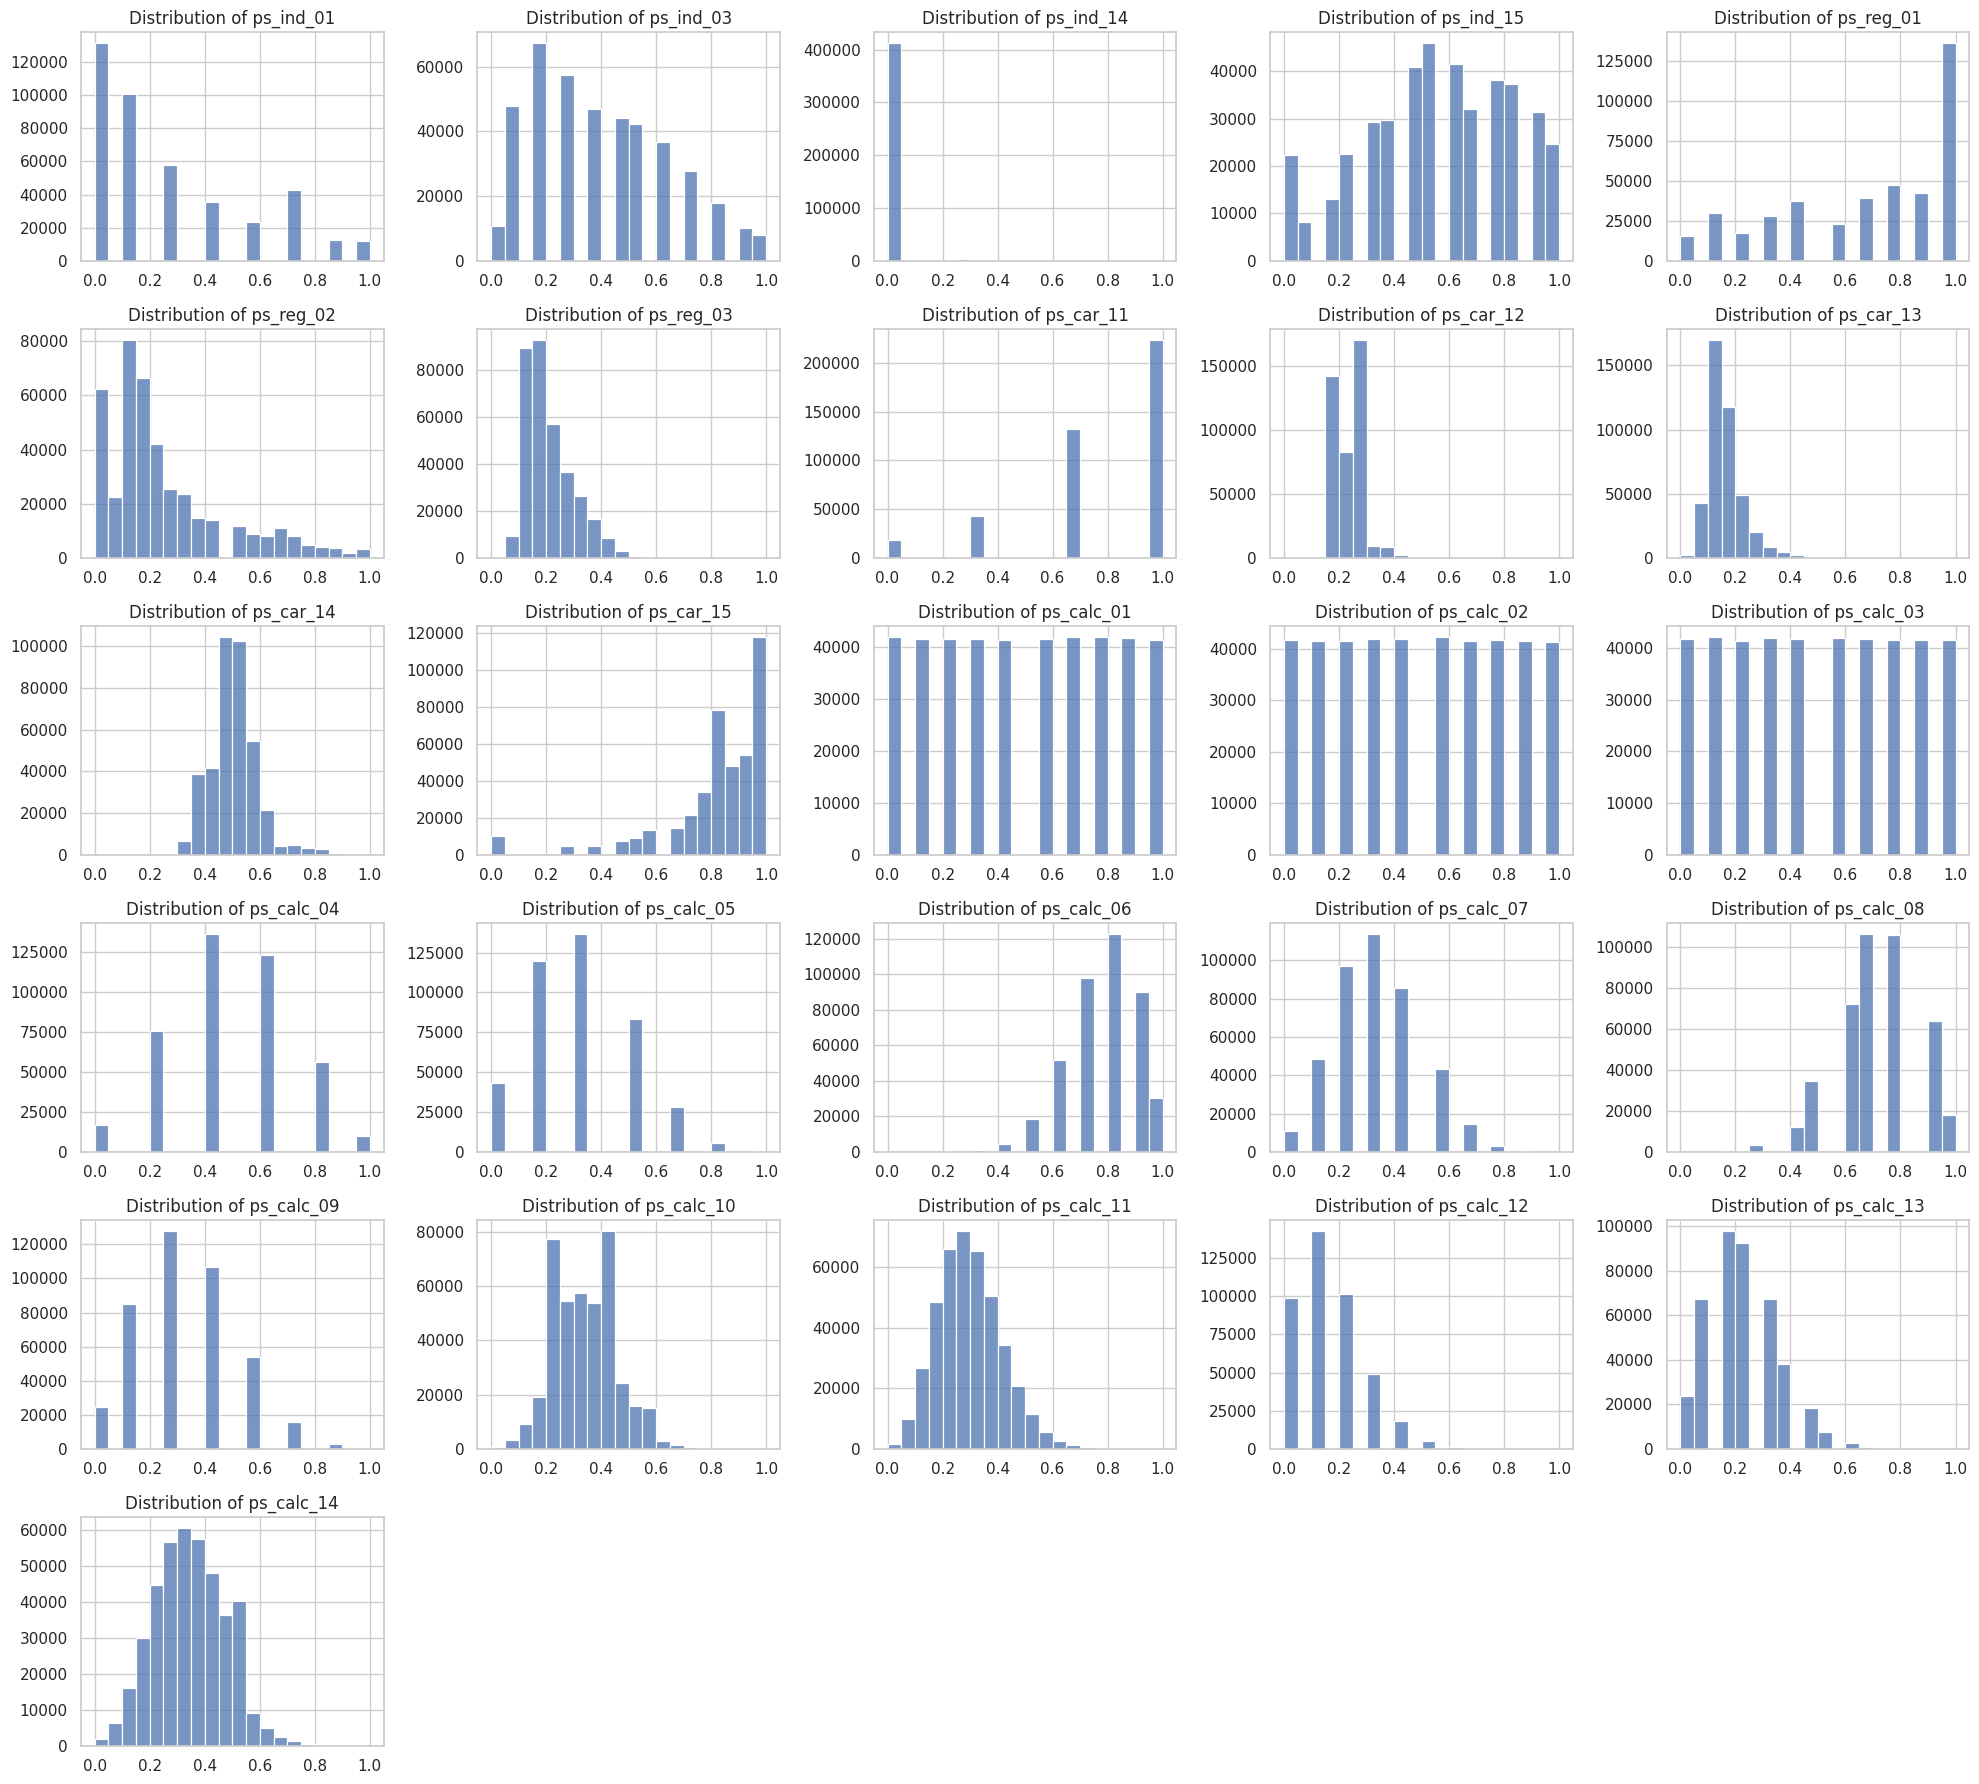

In [ ]:
num_columns = len(X_train_minmax.columns)

num_rows = math.ceil(num_columns / 5)
num_cols = min(5, num_columns)

plt.figure(figsize=(num_cols * 4, num_rows * 3))

for i, column in enumerate(X_train_minmax.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(X_train_minmax[column], bins=20, kde=False)
    plt.title(f'Distribution of {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


## RobustScaler Method

In [ ]:
# numerical Data Type
numerical = X_train.select_dtypes(include=['int64', 'float64', 'uint8'])

scaler = RobustScaler()

# Fit and transform the numerical data
X_train_robust = scaler.fit_transform(numerical)

# Convert numpy array  to a DataFrame
X_train_robust = pd.DataFrame(X_train_robust, columns=numerical.columns)

# Visualizing the results

num_columns = len(X_train_robust.columns)

num_rows = math.ceil(num_columns / 5)
num_cols = min(5, num_columns)


plt.figure(figsize=(num_cols * 4, num_rows * 3))


for i, column in enumerate(X_train_robust.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(X_train_robust[column], bins=20, kde=False)
    plt.title(f'Distribution of {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

## Bivariate Visualization  

## Target vs Features

In [ ]:
corr_train_target = train_df.corr()['target']

In [ ]:
corr_train_target_df = corr_train_target.to_frame(name='target')

<Axes: >

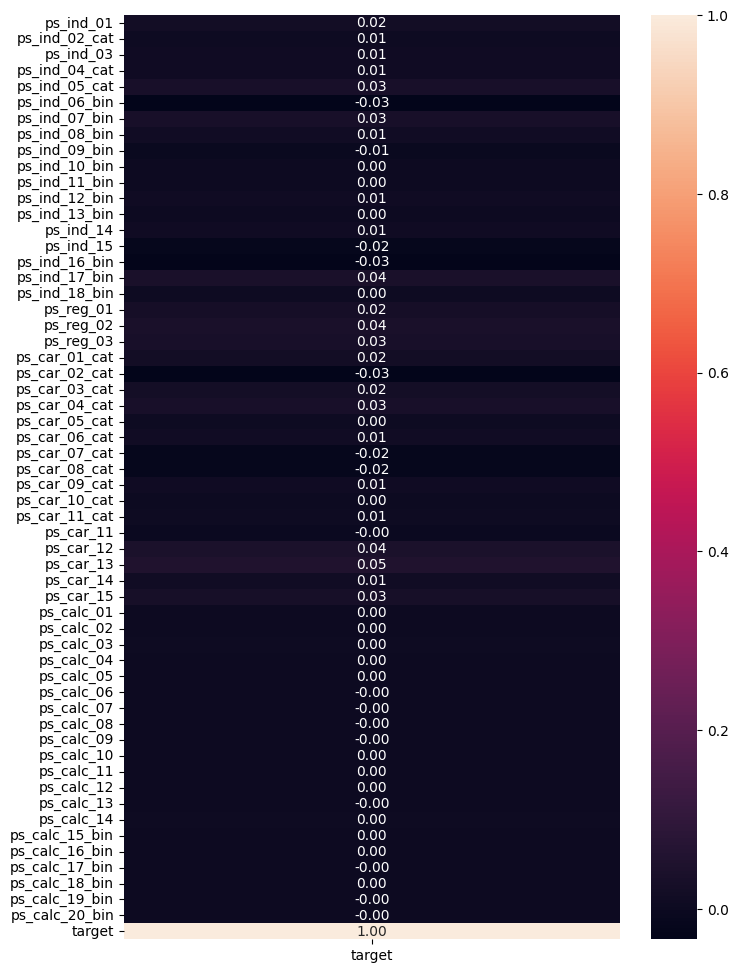

In [ ]:
# sortiert nach Korrelation s
plt.figure(figsize=(8,12))
sns.heatmap(corr_train_target_df,annot=True,fmt=".2f",annot_kws={"size": 10})

# Categorical und continous trennen

### Continous Features

In [ ]:
corr_train_cont_features=X_train[continuous_columns].corr()

<Axes: >

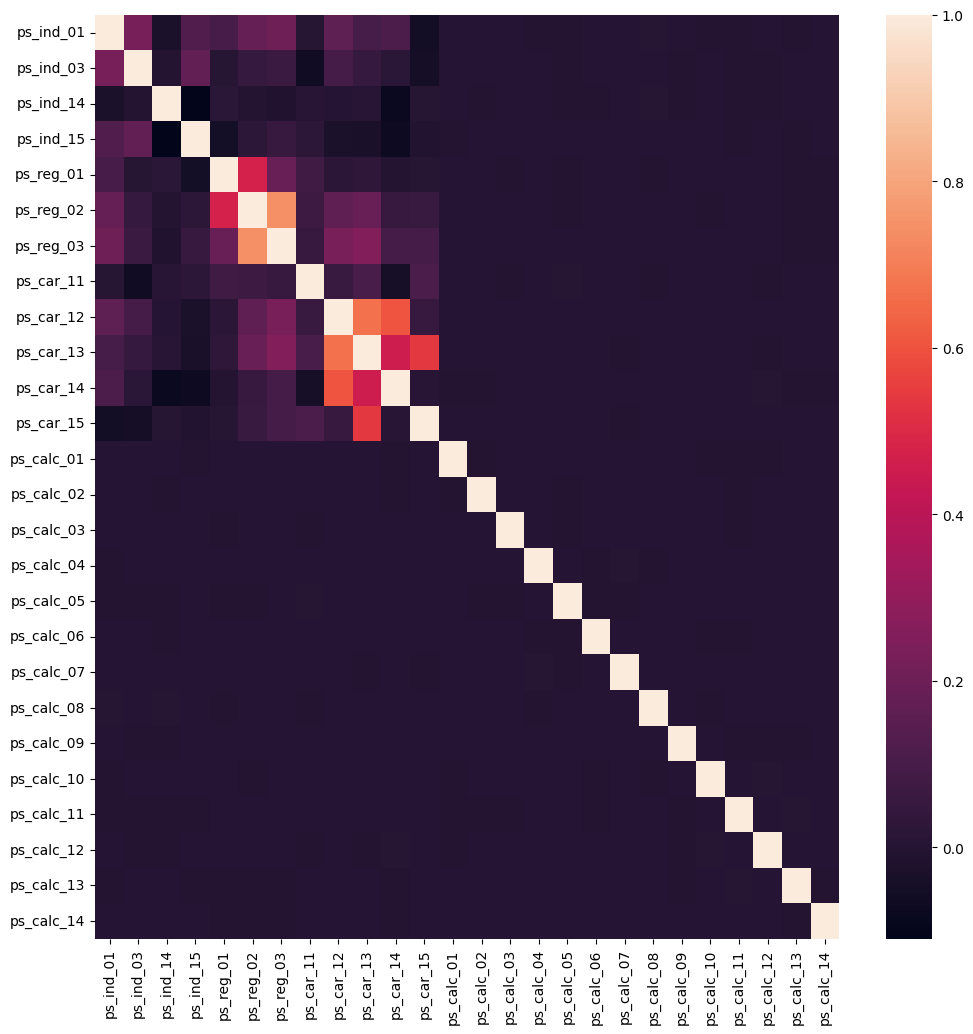

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_train_cont_features)

###Categorical Features

In [ ]:
categorical_columns = categorical_features.columns
results = []

for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        feature1 = categorical_columns[i]
        feature2 = categorical_columns[j]

        contingency_table = pd.crosstab(X_train[feature1], X_train[feature2])

        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

        results.append({
            'Feature1': feature1,
            'Feature2': feature2,
            'Chi-square Statistic': chi2,
            'P-value': p,
            'Degrees of Freedom': dof,
            'Expected Counts': expected
        })

results_df = pd.DataFrame(results)


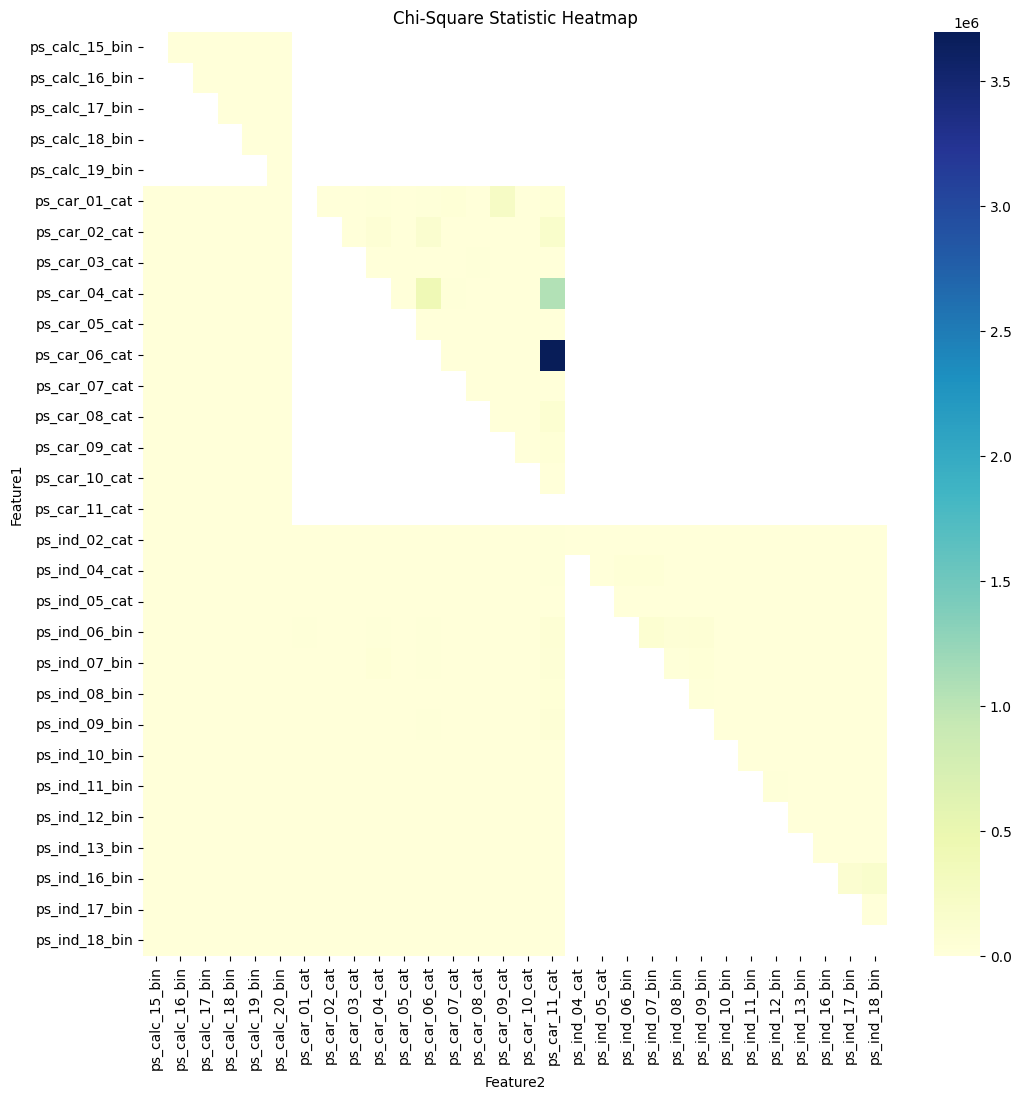

In [ ]:
heatmap_data = results_df.pivot(index='Feature1', columns='Feature2', values='Chi-square Statistic')

# Erstellen der Heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data, cmap='YlGnBu', vmin=0, vmax=heatmap_data.max().max())
plt.title('Chi-Square Statistic Heatmap')
plt.show()

**ps_car_13 höchste Korrelation mit 0.05**

## Metric vs Target


Int Features


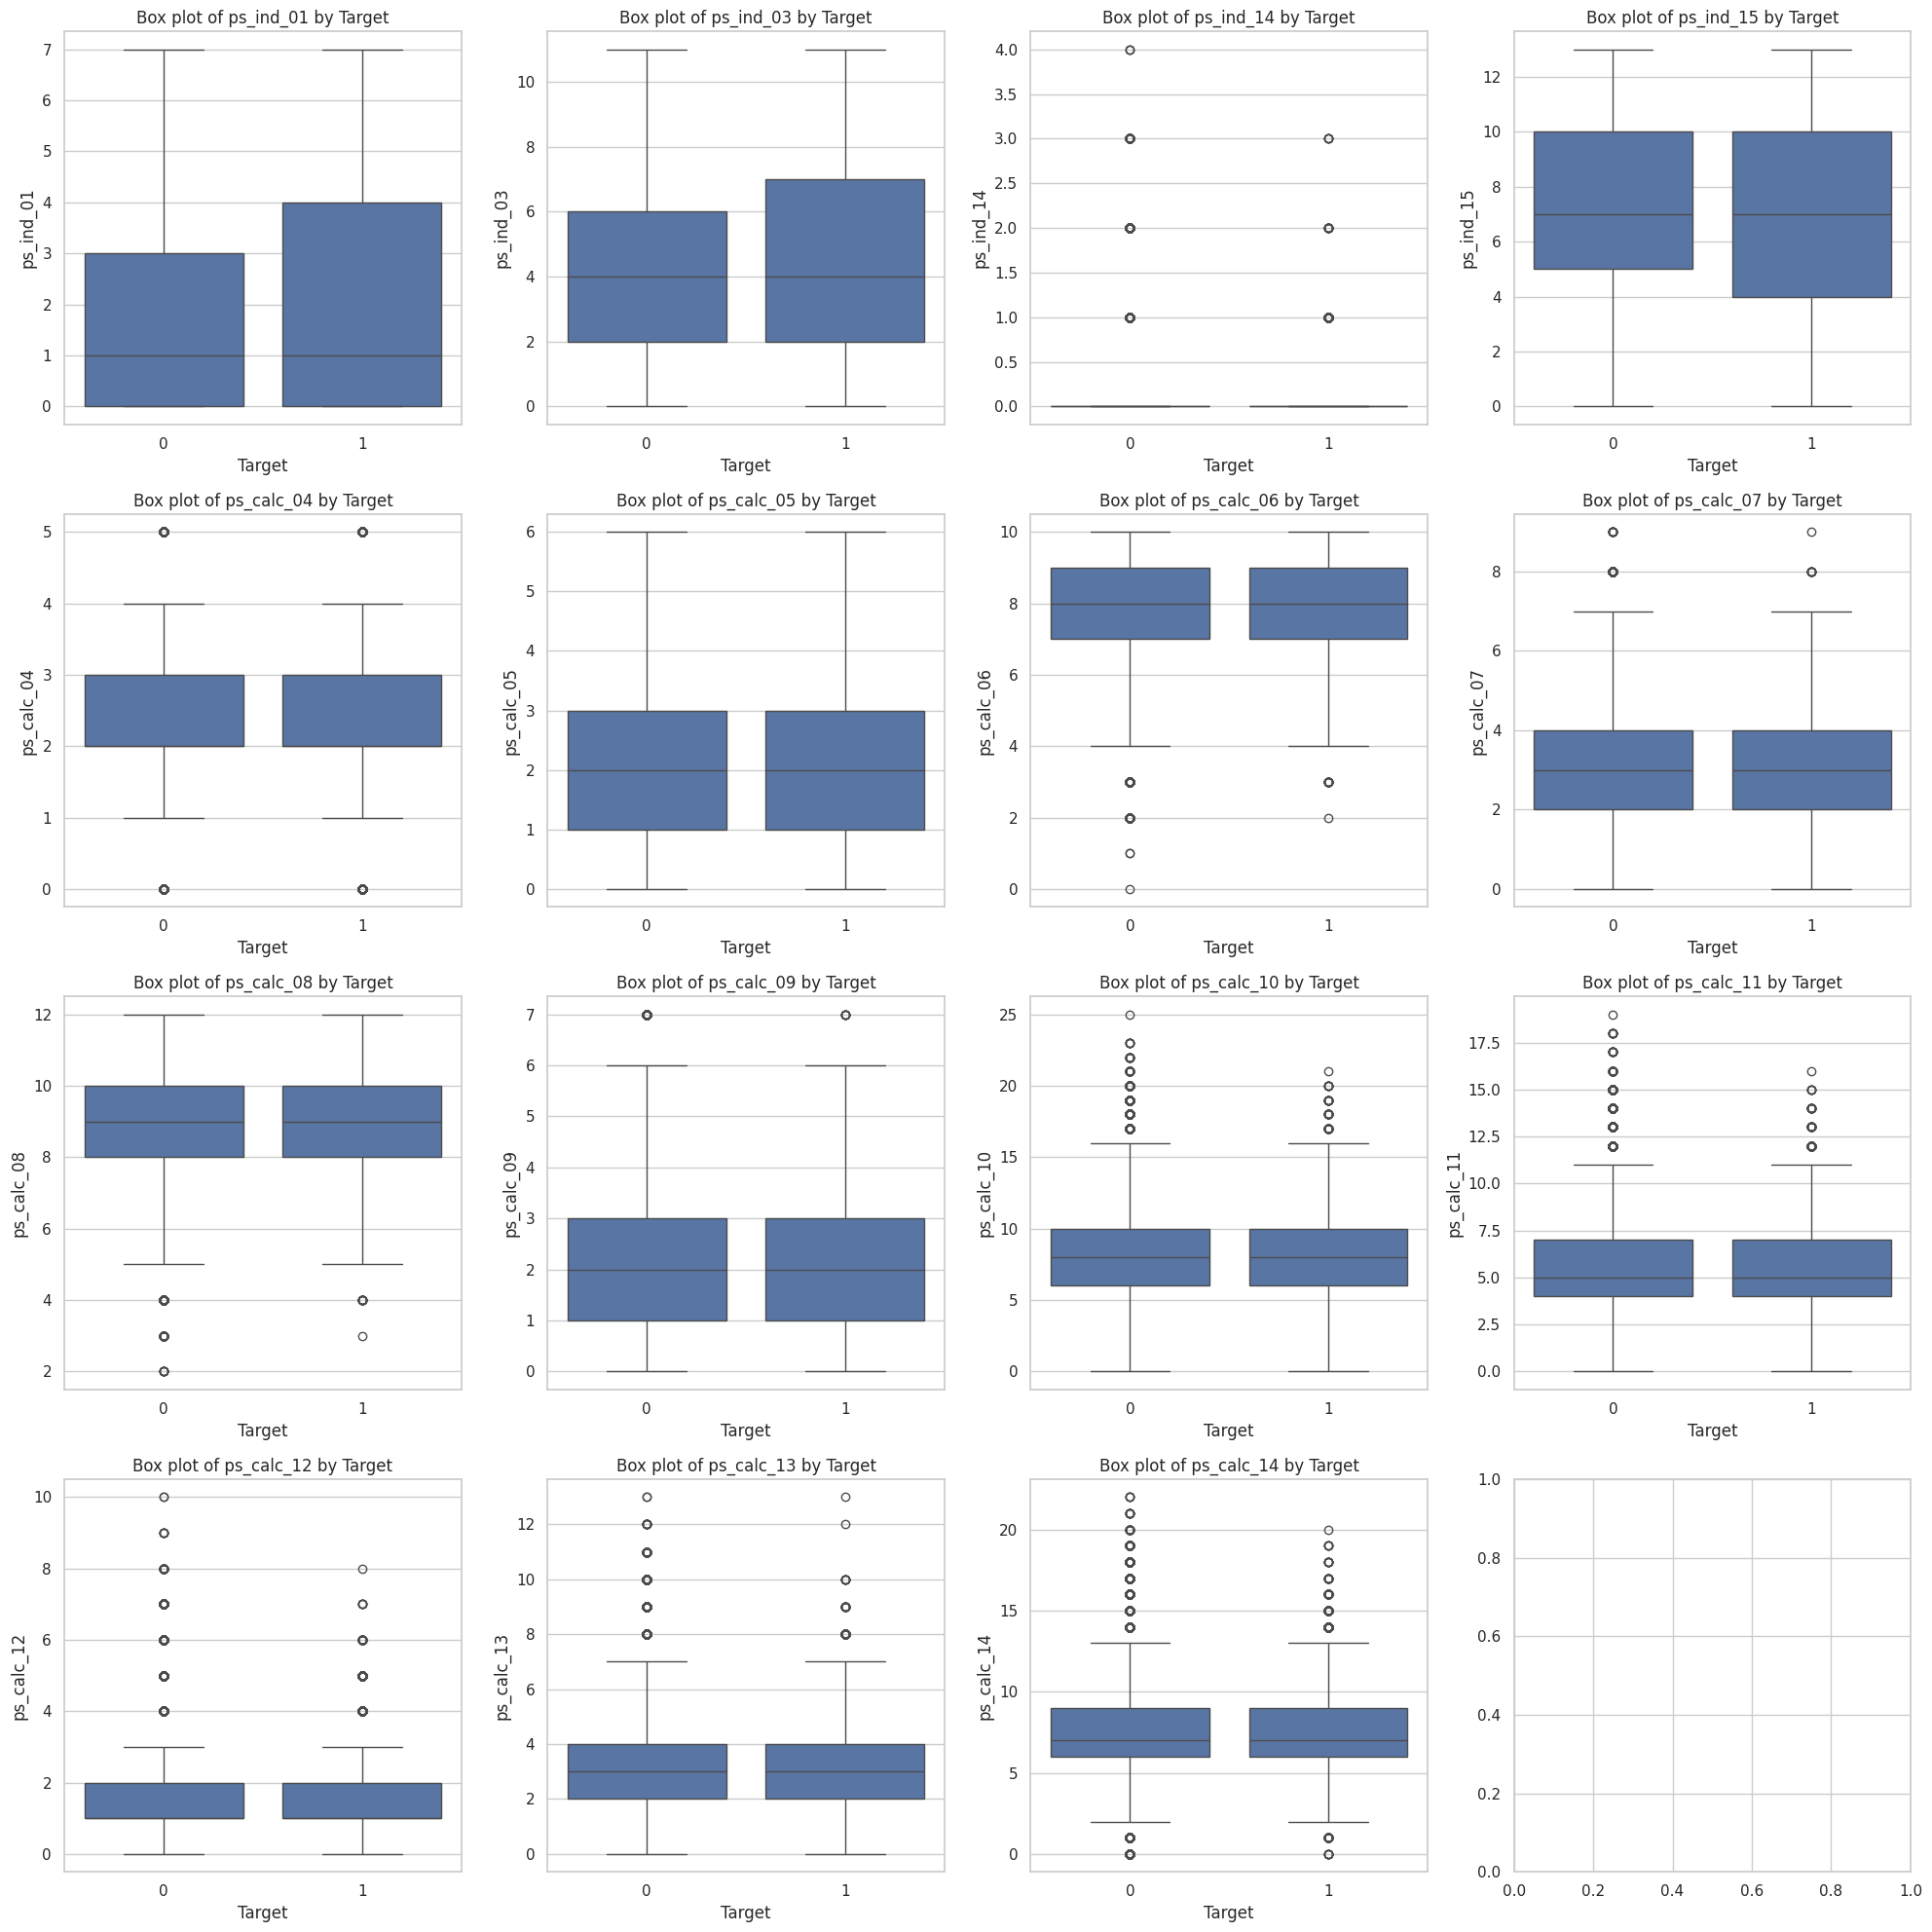

In [ ]:
#Anzahl der Subplots
num_cont = len(continuous_int_features.columns)
num_cols = 4
num_rows = math.ceil(num_cont/num_cols)

#Anpassen der Subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

#Daten in die Plots einfügen
for i,feature in enumerate(continuous_int_features.columns):
    sns.boxplot(ax=axes[i],x=y_train, y=X_train[feature])
    axes[i].set_title(f'Box plot of {feature} by Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

#Plots anzeigen lassen
plt.tight_layout()
plt.show()

Float Features

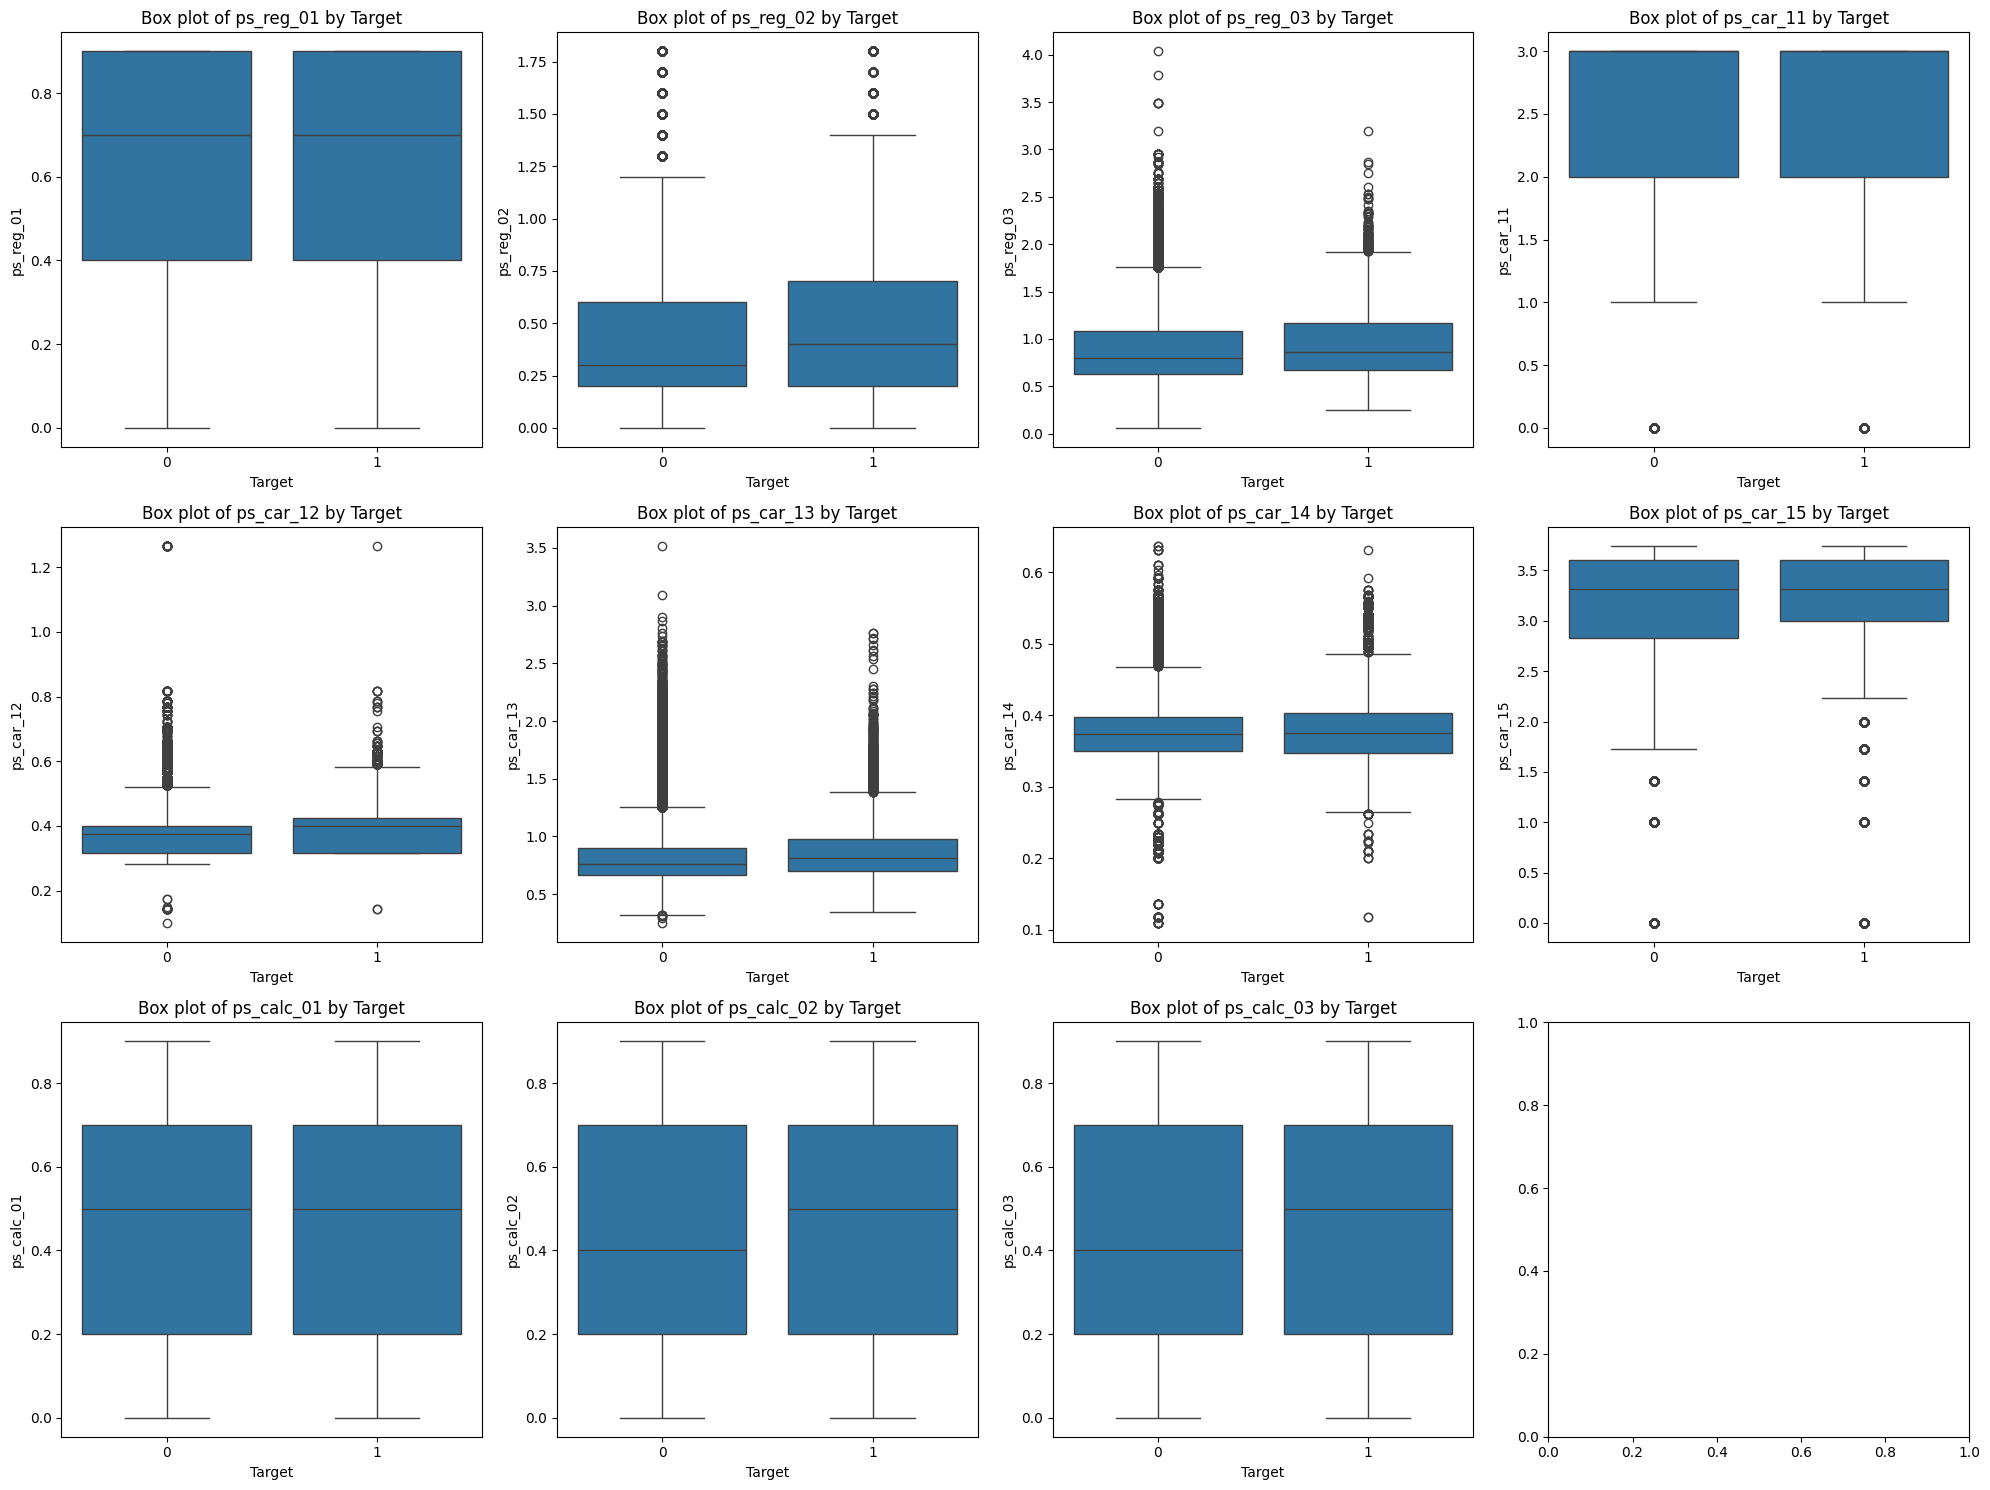

In [ ]:
#Anzahl der Subplots
num_cont = len(continuous_float_features.columns)
num_cols = 4
num_rows = math.ceil(num_cont/num_cols)

#Anpassen der Subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

#Daten in die Plots einfügen
for i,feature in enumerate(continuous_float_features.columns):
    sns.boxplot(ax=axes[i],x=y_train, y=X_train[feature])
    axes[i].set_title(f'Box plot of {feature} by Target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

#Plots anzeigen lassen
plt.tight_layout()
plt.show()

# Basismodell

## Bibliotheken und Preprocessing

preprocessing

In [ ]:
categorical_cols = metadata_df[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
binary_cols = metadata_df[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
continuous_cols = metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()


binary should be numerical

In [ ]:
for col in binary_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_train[col] = X_train[col].cat.codes
    X_val[col] = X_val[col].cat.codes

y_train = y_train.astype(int)
y_val = y_val.astype(int)

for col in binary_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] =  X_val[col].astype('category')
    X_train[col] = X_train[col].cat.codes
    X_val[col] =  X_val[col].cat.codes

y_train = y_train.astype(int)
y_val = y_val.astype(int)

OneHotEncoder for categorcial

## Pipeline 1: Basis

In [ ]:
# Temporal - Na Drop

X_train_original = X_train.copy()

X_train_basis = X_train_original.dropna()
y_train_basis = y_train[X_train_basis.index]

X_val_basis = X_val.dropna()
y_val_basis = y_val[X_val_basis.index]

X_train_basis = pd.DataFrame(X_train_basis)
y_val_basis = pd.DataFrame(y_val_basis)

In [ ]:
categorical_transformer = OneHotEncoder(drop=None, handle_unknown='ignore')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols),
        ('cont', 'passthrough', continuous_cols)
    ]
)

In [ ]:
# Logistische Regression
pipeline_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10_000))
])
pipeline_LR

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

In [ ]:
# Random Forest
# Reasonable Defaults

pipeline_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ))
])
pipeline_RF

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

fit

In [ ]:
pipeline_LR.fit(X_train_basis, y_train_basis)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

In [ ]:
pipeline_RF.fit(X_train_basis, y_train_basis)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

Evaluierung

evaluate (val data)

In [ ]:
#  Logistic Regression model
y_pred_LR = pipeline_LR.predict(X_val_basis)
y_prob_LR = pipeline_LR.predict_proba(X_val_basis)[:, 1]

accuracy_LR = accuracy_score(y_val_basis, y_pred_LR)
roc_auc_LR = roc_auc_score(y_val_basis, y_prob_LR)
precision_LR, recall_LR, _ = precision_recall_curve(y_val_basis, y_prob_LR)
pr_auc_LR = auc(recall_LR, precision_LR)
conf_matrix_LR = confusion_matrix(y_val_basis, y_pred_LR)
report_LR = classification_report(y_val_basis, y_pred_LR)

print("Logistic Regression Model:")
print("Accuracy:", accuracy_LR)
print("ROC AUC:", roc_auc_LR)
print("PR AUC:", pr_auc_LR)
print("Confusion Matrix:\n", conf_matrix_LR)
print("Classification Report:\n", report_LR)
print("\n" + "="*50 + "\n")


#  Random Forest
y_pred_RF = pipeline_RF.predict(X_val_basis)
y_prob_RF = pipeline_RF.predict_proba(X_val_basis)[:, 1]

accuracy_RF = accuracy_score(y_val_basis, y_pred_RF)
roc_auc_RF = roc_auc_score(y_val_basis, y_prob_RF)
precision_RF, recall_RF, _ = precision_recall_curve(y_val_basis, y_prob_RF)
pr_auc_RF = auc(recall_RF, precision_RF)
conf_matrix_RF = confusion_matrix(y_val_basis, y_pred_RF)
report_RF = classification_report(y_val_basis, y_pred_RF)

print("Random Forest Model:")
print("Accuracy:", accuracy_RF)
print("ROC AUC:", roc_auc_RF)
print("PR AUC:", pr_auc_RF)
print("Confusion Matrix:\n", conf_matrix_RF)
print("Classification Report:\n", report_RF)


c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Logistic Regression Model:
Accuracy: 0.9553344623200677
ROC AUC: 0.6112466171975011
PR AUC: 0.06644186985537745
Confusion Matrix:
 [[18052     0]
 [  844     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18052
           1       0.00      0.00      0.00       844

    accuracy                           0.96     18896
   macro avg       0.48      0.50      0.49     18896
weighted avg       0.91      0.96      0.93     18896



Random Forest Model:
Accuracy: 0.9553344623200677
ROC AUC: 0.6224231892489628
PR AUC: 0.06897250120018358
Confusion Matrix:
 [[18052     0]
 [  844     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18052
           1       0.00      0.00      0.00       844

    accuracy                           0.96     18896
   macro avg       0.48      0.50      0.49     18896
weighted avg       0.91      0.96

c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

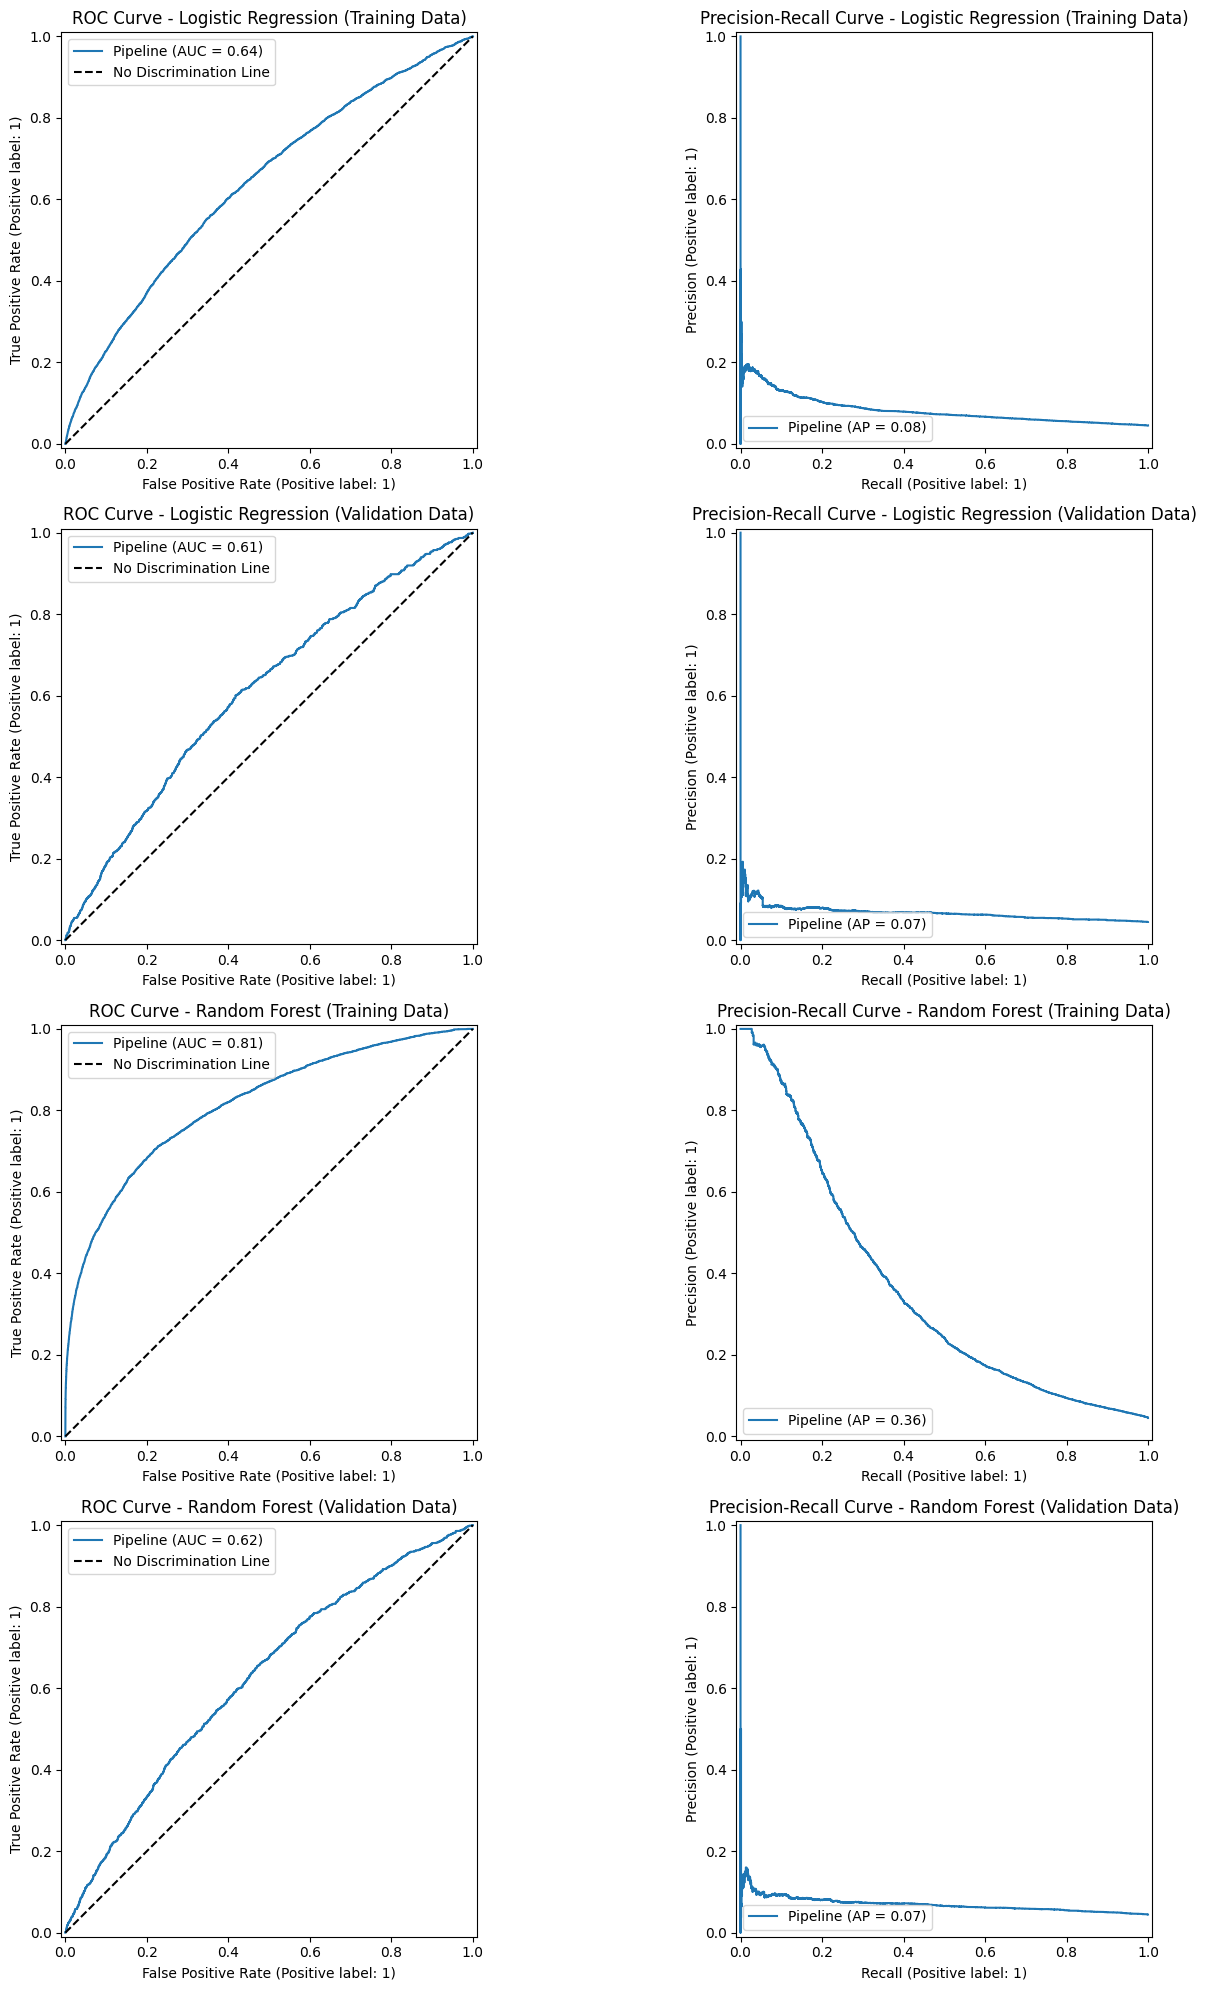

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15, 20))

# Logistic Regression
RocCurveDisplay.from_estimator(pipeline_LR, X_train_basis, y_train_basis, ax=ax1)
ax1.set_title("ROC Curve - Logistic Regression (Training Data)")
ax1.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax1.legend()

PrecisionRecallDisplay.from_estimator(pipeline_LR, X_train_basis, y_train_basis, ax=ax2)
ax2.set_title("Precision-Recall Curve - Logistic Regression (Training Data)")

RocCurveDisplay.from_estimator(pipeline_LR, X_val_basis, y_val_basis, ax=ax3)
ax3.set_title("ROC Curve - Logistic Regression (Validation Data)")
ax3.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax3.legend()

PrecisionRecallDisplay.from_estimator(pipeline_LR, X_val_basis, y_val_basis, ax=ax4)
ax4.set_title("Precision-Recall Curve - Logistic Regression (Validation Data)")

# Random Forest
RocCurveDisplay.from_estimator(pipeline_RF, X_train_basis, y_train_basis, ax=ax5)
ax5.set_title("ROC Curve - Random Forest (Training Data)")
ax5.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax5.legend()

PrecisionRecallDisplay.from_estimator(pipeline_RF, X_train_basis, y_train_basis, ax=ax6)
ax6.set_title("Precision-Recall Curve - Random Forest (Training Data)")

RocCurveDisplay.from_estimator(pipeline_RF, X_val_basis, y_val_basis, ax=ax7)
ax7.set_title("ROC Curve - Random Forest (Validation Data)")
ax7.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax7.legend()

PrecisionRecallDisplay.from_estimator(pipeline_RF, X_val_basis, y_val_basis, ax=ax8)
ax8.set_title("Precision-Recall Curve - Random Forest (Validation Data)")

plt.tight_layout()
plt.show()


In [ ]:
# Logistic Regression
y_prob_LR = pipeline_LR.predict_proba(X_val_basis)[:, 1]
roc_auc_LR = roc_auc_score(y_val_basis, y_prob_LR)
gini_LR = 2 * roc_auc_LR - 1

print("Logistic Regression Model:")
print("ROC AUC:", roc_auc_LR)
print("Normalized Gini Coefficient:", gini_LR)
print("\n" + "="*50 + "\n")

# Random Forest
y_prob_RF = pipeline_RF.predict_proba(X_val_basis)[:, 1]
roc_auc_RF = roc_auc_score(y_val_basis, y_prob_RF)
gini_RF = 2 * roc_auc_RF - 1

print("Random Forest Model:")
print("ROC AUC:", roc_auc_RF)
print("Normalized Gini Coefficient:", gini_RF)


Logistic Regression Model:
ROC AUC: 0.6112466171975011
Normalized Gini Coefficient: 0.22249323439500213


Random Forest Model:
ROC AUC: 0.6224231892489628
Normalized Gini Coefficient: 0.24484637849792557


# Feauture Engineering

## Outliers

In [118]:
X_train_NAs_median = X_train[continuous_columns].fillna(X_train[continuous_columns].median())

In [119]:
def modified_z_score(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    return 0.6745 * (series - median) / mad

z_scores = np.abs((X_train[continuous_columns] - X_train[continuous_columns].mean()) / X_train[continuous_columns].std())
modified_z_scores = X_train[continuous_columns].apply(modified_z_score)

threshold_z = 3
threshold_modified_z = 3.5

outliers_z = z_scores > threshold_z
outliers_modified_z = modified_z_scores > threshold_modified_z

outlier_z_series = outliers_z.any(axis=1)
outlier_modified_z_series = outliers_modified_z.any(axis=1)


outlier_counts_z = outliers_z.sum()
outlier_counts_modified_z = outliers_modified_z.sum()


def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.0 * IQR
    upper_bound = Q3 + 3.0 * IQR
    return (series < lower_bound) | (series > upper_bound)

outliers_iqr = X_train[continuous_columns].apply(iqr_outliers)

outlier_counts_iqr = outliers_iqr.sum()

outlier_iqr_series = outliers_iqr.any(axis=1)



def isolation_forest(df,index_series):
  iso_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42)
  iso_forest.fit(df)

  return(pd.Series(iso_forest.predict(df),index=index_series).map({1:False,-1:True}))


isolation_forest_series = isolation_forest(X_train_NAs_median[continuous_columns],X_train.index)
isolation_forest_counts = pd.Series(data=isolation_forest_series.sum(),index=X_train[continuous_columns].columns)


outlier_all_df = pd.DataFrame({
    'Index': X_train.index,
    'Z-score': outlier_z_series.values,
    'Modified Z-score': outlier_modified_z_series.values,
    'IQR': outlier_iqr_series.values,
    'Isolation Forest': isolation_forest_series.values
})

boolean_mask_aligned = outlier_all_df.all(axis=1)

filtered_outliers = outlier_all_df[boolean_mask_aligned]
filtered_outliers_index = list(filtered_outliers['Index'])

outliers_all_methods = ((outliers_z) &
                        (outliers_modified_z) &
                        (outlier_counts_iqr))

outlier_counts_all_methods = outliers_all_methods.loc[filtered_outliers_index].sum()

outlier_counts_df = pd.DataFrame({
    'Feature': continuous_columns,
    'Outlier Count (Z-score)': outlier_counts_z.values,
    'Outlier Count (Modified Z-score)': outlier_counts_modified_z.values,
    'Outlier Count (IQR)': outlier_counts_iqr.values,
    'Outlier Count (Isolation Forest)': isolation_forest_counts.values,
    'Outlier Count (All Methods)': outlier_counts_all_methods.values
})

outlier_counts_df

Feature  Outlier Count (Z-score)  Outlier Count (Modified Z-score)  \
0    ps_ind_01                        0                             12122   
2    ps_ind_03                        0                                 0   
13   ps_ind_14                     4503                              4503   
14   ps_ind_15                        0                                 0   
18   ps_reg_01                        0                                 0   
19   ps_reg_02                     5118                             17754   
20   ps_reg_03                     2440                                 0   
32   ps_car_11                        0                                 0   
33   ps_car_12                     4703                               447   
34   ps_car_13                     7531                             12349   
35   ps_car_14                     6983                                 0   
36   ps_car_15                     9950                                 0   
37  ps_calc_01                        0                                 0   
38  ps_calc_02                        0                                 0   
39  ps_calc_03                        0                                 0   
40  ps_calc_04                        0                                 0   
41  ps_calc_05                      376                                 0   
42  ps_calc_06                      970                                 0   
43  ps_calc_07                      390                                16   
44  ps_calc_08                      669                                 0   
45  ps_calc_09                      183                                 0   
46  ps_calc_10                     1114                               475   
47  ps_calc_11                     1764                                75   
48  ps_calc_12                     1502                               312   
49  ps_calc_13                     3858                              1126   
50  ps_calc_14                     2071                               357   

    Outlier Count (IQR)  Outlier Count (Isolation Forest)  \
0                     0                              4167   
2                     0                              4167   
13                 4503                              4167   
14                    0                              4167   
18                    0                              4167   
19                 3337                              4167   
20                  162                              4167   
32                    0                              4167   
33                  312                              4167   
34                 4265                              4167   
35                 2151                              4167   
36                 9950                              4167   
37                    0                              4167   
38                    0                              4167   
39                    0                              4167   
40                    0                              4167   
41                    0                              4167   
42                    1                              4167   
43                    0                              4167   
44                    0                              4167   
45                    0                              4167   
46                    7                              4167   
47                   25                              4167   
48                 1502                              4167   
49                   91                              4167   
50                  143                              4167   

    Outlier Count (All Methods)  
0                             0  
2                             0  
13                          642  
14                            0  
18                            0  
19                          586  
20                            0  
32     

In [120]:
#filtert alle Features mit AUsreißern aus und konvertiert diese zu einer Liste
columns_with_outliers = outlier_counts_df[outlier_counts_df['Outlier Count (All Methods)']>0]['Feature'].tolist()
columns_with_outliers

['ps_ind_14',
 'ps_reg_02',
 'ps_car_13',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_13',
 'ps_calc_14']

In [121]:
#Dataframe mit Feature als Columns wenn alle Methoden außer iso den Datenpunkt bei dem Feature als Outlier identifizieren
outlier_combined_without_iso = outliers_modified_z[columns_with_outliers] & outliers_z[columns_with_outliers]&outliers_iqr[columns_with_outliers]
#filtert alle Datenpunkte raus die der IsoForest als Ausreißer defeniert
outlier_combined=outlier_combined_without_iso[isolation_forest_series]
# Boolesche Maske die True ausgibt wenn Alle Spalteneinträge in der Zeile True sind.
# Mit dem Ziel Zeilen zu Filtern die nur vom Iso als outlier identiefiziert werden.
                 # Gibt True aus wenn in der Zelle False steht also nicht als Ausreißer defeniert ist.
                                             # Gibt True aus wenn alle Zeileneinträge True sind. Das heiß keine Methode(außer iso) Ausreißer Defeniert
all_false_mask = (outlier_combined == False).all(axis=1)

# invertiert die Maske
mask_to_keep = ~all_false_mask
# Gibt die Zeilen Aus die mindestens einen Outlier beinhalten
filtered_outlier_combined = outlier_combined[mask_to_keep]

filtered_outlier_combined

ps_ind_14  ps_reg_02  ps_car_13  ps_calc_10  ps_calc_11  ps_calc_13  \
269001       True      False      False       False       False       False   
533179       True      False      False       False       False       False   
385886      False      False       True       False       False       False   
100677      False       True      False       False       False       False   
162141      False       True      False       False       False       False   
...           ...        ...        ...         ...         ...         ...   
155348      False       True      False       False       False       False   
210026       True      False       True       False       False       False   
198801      False      False       True       False       False        True   
247754       True      False      False       False       False       False   
401564      False      False      False       False       False        True   

        ps_calc_14  
269001       False  
533179       False  
385886       False  
100677       False  
162141       False  
...            ...  
155348       False  
210026       False  
198801       False  
247754       False  
401564       False  

[1748 rows x 7 columns]

In [122]:
#Erschaffen eines Dataframes, dass die Position der Outliers bestimmt

outlier_df = filtered_outlier_combined.reset_index()
outlier_df = outlier_df.melt(id_vars=['index'], var_name='Feature', value_name='Outlier')

# Filter to keep only rows where Outlier is True
outlier_df = outlier_df[outlier_df['Outlier']]

# Remove the Outlier column
outlier_df = outlier_df.drop(columns='Outlier')

# Rename index column to 'Index'
outlier_df = outlier_df.rename(columns={'index': 'Index'})

# Reset index for clean DataFrame
outlier_df = outlier_df.reset_index(drop=True)
outlier_df

Index     Feature
0     269001   ps_ind_14
1     533179   ps_ind_14
2     457118   ps_ind_14
3     324388   ps_ind_14
4     551848   ps_ind_14
...      ...         ...
2000  401564  ps_calc_13
2001   75135  ps_calc_14
2002  367521  ps_calc_14
2003   27004  ps_calc_14
2004  458767  ps_calc_14

[2005 rows x 2 columns]

In [123]:
#Impuation durchgeführt
for index, feature in outlier_df.itertuples(index=False):
    X_train.loc[index, feature] = np.nan

## Preprocessing

preprocessing

In [124]:
categorical_cols = metadata_df[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
binary_cols = metadata_df[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
continuous_cols = metadata_df[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()


### NA Impuation: Custom Imputer Klassen

Custom Categorical Imputer

In [125]:
class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='most_frequent', fill_value=None):
        self.method = method
        self.fill_value = fill_value
        self.imputer = None

    def fit(self, X, y=None):
        if self.method in ['most_frequent', 'constant']:
            self.imputer = SimpleImputer(strategy=self.method, fill_value=self.fill_value)
            self.imputer.fit(X)
        return self

    def transform(self, X):
        if self.method in ['most_frequent', 'constant']:
            return pd.DataFrame(self.imputer.transform(X), columns=X.columns)
        elif self.method == 'forward_fill':
            return X.ffill()
        elif self.method == 'backward_fill':
            return X.bfill()
        else:
            raise ValueError(f"Unsupported method for categorical data: {self.method}")



Custom Continuous Encoder

In [126]:
class CustomNumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean'):
        self.method = method
        self.imputer = None

    def fit(self, X, y=None):
        if self.method in ['mean', 'median']:
            self.imputer = SimpleImputer(strategy=self.method)
            self.imputer.fit(X)
        return self

    def transform(self, X):
        if self.method in ['mean', 'median']:
            return pd.DataFrame(self.imputer.transform(X), columns=X.columns)
        elif self.method == 'forward_fill':
            return X.ffill()
        elif self.method == 'backward_fill':
            return X.bfill()
        elif self.method == 'linear_interpolation':
            return X.interpolate(method='linear')
        else:
            raise ValueError(f"Unsupported method for numerical data: {self.method}")


### Anpassung Kategoriale Variablen Kardinalitäten

Neues X Train und X Val mit bestem Hyperparameter: 0.16 (siehe EDA 2)

X_train (erste 5 Zeilen):
       ps_car_11_cat
395927           104
345312           104
488480         Other
580242         Other
295540           104

X_val (erste 5 Zeilen):
       ps_car_11_cat
100781         Other
581349         Other
497347         Other
506772         Other
263957         Other

Original Category Counts in X_train:
ps_car_11_cat
104    59579
103    16855
64     15542
87     11945
28      8913
Name: count, dtype: int64

New Category Counts in X_train:
ps_car_11_cat
Other    262794
104       59579
103       16855
64        15542
87        11945
Name: count, dtype: int64

New Category Counts in X_val:
ps_car_11_cat
Other    56373
104      12748
103       3703
64        3360
87        2597
Name: count, dtype: int64


<Axes: title={'center': 'X_val Category Distribution'}, ylabel='count'>

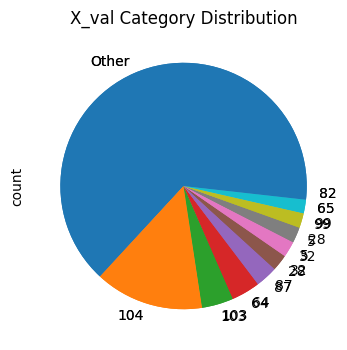

In [127]:
# Kopien der ursprünglichen Datensätze erstellen
X_train_categorical = X_train.copy()
X_val_categorical = X_val.copy()

# Definiere den relativen Schwellenwert
relative_threshold = 0.016

# Zähle die Kategorien in den Trainingsdaten
train_category_counts = X_train_categorical['ps_car_11_cat'].value_counts()

# Berechne den Schwellenwert für seltene Kategorien im Trainingsdatensatz
train_threshold_count = relative_threshold * len(X_train_categorical)

# Identifiziere seltene Kategorien im Trainingsdatensatz
train_rare_categories = train_category_counts[train_category_counts < train_threshold_count].index

# Ersetze die ursprüngliche Spalte 'ps_car_11_cat' durch die aggregierte Version im Trainings- und Validierungsdatensatz
X_train_categorical['ps_car_11_cat'] = X_train_categorical['ps_car_11_cat'].apply(
    lambda x: 'Other' if x in train_rare_categories else x
)

X_val_categorical['ps_car_11_cat'] = X_val_categorical['ps_car_11_cat'].apply(
    lambda x: 'Other' if x in train_rare_categories else x  # Gleiche seltene Kategorien wie im Training verwenden
)

# Ausgabe der neuen Spalten zur Überprüfung
print("X_train (erste 5 Zeilen):")
print(X_train_categorical[['ps_car_11_cat']].head())
print("\nX_val (erste 5 Zeilen):")
print(X_val_categorical[['ps_car_11_cat']].head())

# Originale Kategorie-Zählungen und neue Zählungen
print("\nOriginal Category Counts in X_train:")
print(train_category_counts.head())
print("\nNew Category Counts in X_train:")
print(X_train_categorical['ps_car_11_cat'].value_counts().head())

print("\nNew Category Counts in X_val:")
print(X_val_categorical['ps_car_11_cat'].value_counts().head())

# Optional: Pie-Charts zur Visualisierung der neuen Kategorie-Verteilungen
X_train_categorical['ps_car_11_cat'].value_counts().plot.pie(figsize=(4, 4), title='X_train Category Distribution')
X_val_categorical['ps_car_11_cat'].value_counts().plot.pie(figsize=(4, 4), title='X_val Category Distribution')


Was ist das für Code???

In [128]:
# pipeline_RF_2.fit(X_train_categorical, y_train)
# # Vorhersagen für die Validierungsdaten treffen
# y_pred_RF = pipeline_RF_2.predict(X_val_categorical)
# y_prob_RF = pipeline_RF_2.predict_proba(X_val_categorical)[:, 1]

# # Berechne die ROC AUC für die aktuelle Konfiguration
# roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
# print(f"ROC AUC for the current Random Forest configuration: {roc_auc_RF}")

# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.impute import SimpleImputer

# class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
#     def __init__(self, method='most_frequent', fill_value=None):
#         self.method = method
#         self.fill_value = fill_value
#         self.imputer = None

#     def fit(self, X, y=None):
#         if self.method in ['most_frequent', 'constant']:
#             self.imputer = SimpleImputer(strategy=self.method, fill_value=self.fill_value)
#             self.imputer.fit(X)
#         return self

#     def transform(self, X):
#         if self.method in ['most_frequent', 'constant']:
#             return pd.DataFrame(self.imputer.transform(X), columns=X.columns)
#         elif self.method == 'forward_fill':
#             return X.ffill()
#         elif self.method == 'backward_fill':
#             return X.bfill()
#         else:
#             raise ValueError(f"Unsupported method for categorical data: {self.method}")


# # Custom Continuous Encoder
# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.impute import SimpleImputer

# class CustomNumericalImputer(BaseEstimator, TransformerMixin):
#     def __init__(self, method='mean'):
#         self.method = method
#         self.imputer = None

#     def fit(self, X, y=None):
#         if self.method in ['mean', 'median']:
#             self.imputer = SimpleImputer(strategy=self.method)
#             self.imputer.fit(X)
#         return self

#     def transform(self, X):
#         if self.method in ['mean', 'median']:
#             return pd.DataFrame(self.imputer.transform(X), columns=X.columns)
#         elif self.method == 'forward_fill':
#             return X.ffill()
#         elif self.method == 'backward_fill':
#             return X.bfill()
#         elif self.method == 'linear_interpolation':
#             return X.interpolate(method='linear')
#         else:
#             raise ValueError(f"Unsupported method for numerical data: {self.method}")

### Transformer

In [129]:
categorical_transformer_2 = Pipeline(steps=[
    ('imputer', CustomCategoricalImputer(method='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [130]:
categorical_transformer_3 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
])

In [131]:
continuous_transformer_2 = Pipeline(steps=[
    ('imputer', CustomNumericalImputer(method='mean')),
    ('scaler', MinMaxScaler())
    ])

In [132]:
continuous_transformer_3 = Pipeline(steps=[
    ('imputer', CustomNumericalImputer(method='mean')),
    ('scaler', MinMaxScaler())
    ])

### Processors

In [133]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_2, categorical_cols),
        ('bin', 'passthrough', binary_cols),
        ('cont', continuous_transformer_2, continuous_cols)
    ]
)

In [134]:
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_3, categorical_cols),
        ('bin', 'passthrough', binary_cols),
        ('cont', continuous_transformer_2, continuous_cols)
    ]
)

In [135]:
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_3, categorical_cols),
        ('bin', 'passthrough', binary_cols),
        ('cont', continuous_transformer_3, continuous_cols)
    ]
)

In [136]:
pipeline_RF_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ))
])
pipeline_RF_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_...
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

## Neue X train und X val

**Beste Encoder, Scaler, NA Imputation, Forest Paramters** (siehe EDA II)
1. Ordinal: Best Encoder-Scaler-NA Imputer Combination: ('ordinal', 'standard', 'most_frequent', 'forward_fill') with ROC AUC: 0.6321892481997756
2. One-Hot: ('onehot', 'minmax', 'constant', 'median') Current Best AUC Score: 0.6317929420729473
Best Hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'} with ROC AUC: 0.6335571580602579

In [143]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('to_numeric', FunctionTransformer(lambda x: x.astype('float32')))
])

In [144]:
# Beste Pipeline (One-Hot)

categorical_transformer_v2 = Pipeline(steps=[
    ('imputer', CustomCategoricalImputer(method='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
continuous_transformer_v2 = Pipeline(steps=[
    ('imputer', CustomNumericalImputer(method='median')),
    ('scaler', MinMaxScaler())
    ])
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_v2, categorical_cols),
        ('bin', binary_transformer, binary_cols),
        ('cont', continuous_transformer_v2, continuous_cols)
    ]
)
pipeline_RF_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor_v2),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ))
])
pipeline_RF_v2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer(method='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07...
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

In [145]:
preprocessor_v2.fit(X_train_categorical)
X_train_v2 = pd.DataFrame(preprocessor_v2.transform(X_train_categorical))
X_val_v2 = pd.DataFrame(preprocessor_v2.transform(X_val_categorical))

Keep Names

In [146]:
# Get the feature names for the categorical part
categorical_feature_names = preprocessor_v2.transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine them with the binary and continuous column names
feature_names = list(categorical_feature_names) + binary_cols + continuous_cols

# Set the feature names as column names in your transformed DataFrames
X_train_v2 = pd.DataFrame(preprocessor_v2.transform(X_train_categorical), columns=feature_names)
X_val_v2 = pd.DataFrame(preprocessor_v2.transform(X_val_categorical), columns=feature_names)


Alle Daten bisher

In [147]:
X_train # Basisdatensatz
X_val # Basisdatensatz

X_train_categorical # Categorical Anpassung
X_val_categorical # Categorical Anpassung

X_train_v2 # Enocded, Scaled und Imputed Modell + Catgeorical Anpassung
X_val_v2 # Enocded, Scaled und Imputed Modell + Catgeorical Anpassung


ps_ind_02_cat_1  ps_ind_02_cat_2  ps_ind_02_cat_3  ps_ind_02_cat_4  \
0                  1.0              0.0              0.0              0.0   
1                  0.0              1.0              0.0              0.0   
2                  0.0              0.0              1.0              0.0   
3                  0.0              0.0              1.0              0.0   
4                  1.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
89277              1.0              0.0              0.0              0.0   
89278              1.0              0.0              0.0              0.0   
89279              0.0              1.0              0.0              0.0   
89280              1.0              0.0              0.0              0.0   
89281              0.0              0.0              1.0              0.0   

       ps_ind_02_cat_missing_value  ps_ind_04_cat_0  ps_ind_04_cat_1  \
0                              0.0              0.0              1.0   
1                              0.0              1.0              0.0   
2                              0.0              1.0              0.0   
3                              0.0              1.0              0.0   
4                              0.0              0.0              1.0   
...                            ...              ...              ...   
89277                          0.0              0.0              1.0   
89278                          0.0              1.0              0.0   
89279                          0.0              1.0              0.0   
89280                          0.0              1.0              0.0   
89281                          0.0              0.0              1.0   

       ps_ind_04_cat_missing_value  ps_ind_05_cat_0  ps_ind_05_cat_1  \
0                              0.0              1.0              0.0   
1                              0.0              1.0              0.0   
2                              0.0              1.0              0.0   
3                              0.0              1.0              0.0   
4                              0.0              1.0              0.0   
...                            ...              ...              ...   
89277                          0.0              1.0              0.0   
89278                          0.0              1.0              0.0   
89279                          0.0              1.0              0.0   
89280                          0.0              1.0              0.0   
89281                          0.0              0.0              0.0   

       ps_ind_05_cat_2  ps_ind_05_cat_3  ps_ind_05_cat_4  ps_ind_05_cat_5  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
89277              0.0              0.0              0.0              0.0   
89278              0.0              0.0              0.0              0.0   
89279              0.0              0.0              0.0              0.0   
89280              0.0              0.0              0.0              0.0   
89281              0.0              0.0              1.0              0.0   

       ps_ind_05_cat_6  ps_ind_05_cat_missing_value  ps_car_01_cat_0  \
0                  0.0                          0.0              0.0   
1                  0.0                          0.0              0.0   
2                  0.0                          0.0              0.0   
3                  0.0                          0.0              0.0   
4                  0.0                          0.0              0.

Neue Metadaten: Metadata_df_v2

In [148]:
def categorize_column(col):
    if 'cat' in col:
        return 'categorical'
    elif df[col].nunique() == 2 or 'bin' in col or col == 'target':
        return 'binary'
    elif df[col].dtype == np.uint8:
        return 'continuous'
    elif df[col].dtype in [np.float64, np.int64]:
        return 'continuous'
    else:
        return 'other'

metadata_df_v2 = pd.DataFrame({
    'feature_name': X_train_v2.columns,
    'feature_type': X_train_v2.columns.map(categorize_column)
})
metadata_df_v2


feature_name feature_type
0                ps_ind_02_cat_1  categorical
1                ps_ind_02_cat_2  categorical
2                ps_ind_02_cat_3  categorical
3                ps_ind_02_cat_4  categorical
4    ps_ind_02_cat_missing_value  categorical
..                           ...          ...
129                   ps_calc_10   continuous
130                   ps_calc_11   continuous
131                   ps_calc_12   continuous
132                   ps_calc_13   continuous
133                   ps_calc_14   continuous

[134 rows x 2 columns]

In [149]:
categorical_cols = metadata_df_v2[(metadata_df_v2['feature_type'] == 'categorical') & (metadata_df_v2['feature_name'] != 'target')]['feature_name'].tolist()
binary_cols = metadata_df_v2[(metadata_df_v2['feature_type'] == 'binary') & (metadata_df_v2['feature_name'] != 'target')]['feature_name'].tolist()
continuous_cols = metadata_df_v2[(metadata_df_v2['feature_type'] == 'continuous') & (metadata_df_v2['feature_name'] != 'target')]['feature_name'].tolist()

## Correlation Analysis

In [ ]:
# Pearson for continous

continuous_correlations = {}
for col in continuous_cols:
    corr, _ = pearsonr(X_train_v2[col], y_train)
    continuous_correlations[col] = corr

continuous_corr_df = pd.DataFrame(list(continuous_correlations.items()), columns=['Feature', 'Correlation'])
continuous_corr_df = continuous_corr_df.reindex(continuous_corr_df['Correlation'].abs().sort_values(ascending=False).index)

print(continuous_corr_df)

       Feature  Correlation
9    ps_car_13     0.045317
8    ps_car_12     0.036658
10   ps_car_14     0.032961
5    ps_reg_02     0.029700
6    ps_reg_03     0.028247
0    ps_ind_01     0.026899
3    ps_ind_15    -0.020991
11   ps_car_15     0.018140
1    ps_ind_03     0.016083
4    ps_reg_01     0.012070
7    ps_car_11    -0.006330
24  ps_calc_13    -0.006130
14  ps_calc_03     0.005628
25  ps_calc_14     0.004492
2    ps_ind_14     0.004248
15  ps_calc_04     0.003161
16  ps_calc_05     0.003131
17  ps_calc_06     0.002935
19  ps_calc_08     0.002677
12  ps_calc_01     0.002526
22  ps_calc_11    -0.002477
20  ps_calc_09     0.001603
18  ps_calc_07    -0.001597
13  ps_calc_02     0.001176
21  ps_calc_10     0.000533
23  ps_calc_12     0.000455


In [ ]:
# Point Biserial for binary

binary_correlations = {}
for col in binary_cols:
    corr, _ = pointbiserialr(X_train_v2[col], y_train)
    binary_correlations[col] = corr

binary_corr_df = pd.DataFrame(list(binary_correlations.items()), columns=['Feature', 'Correlation'])
binary_corr_df = binary_corr_df.reindex(binary_corr_df['Correlation'].abs().sort_values(ascending=False).index)

print(binary_corr_df)

           Feature  Correlation
9    ps_ind_17_bin     0.048841
8    ps_ind_16_bin    -0.037879
1    ps_ind_07_bin     0.033886
0    ps_ind_06_bin    -0.031618
3    ps_ind_09_bin    -0.019206
2    ps_ind_08_bin     0.017879
6    ps_ind_12_bin     0.006002
15  ps_calc_19_bin    -0.005301
10   ps_ind_18_bin    -0.004722
12  ps_calc_16_bin     0.003698
13  ps_calc_17_bin    -0.003422
16  ps_calc_20_bin    -0.002388
11  ps_calc_15_bin    -0.002334
14  ps_calc_18_bin    -0.002208
4    ps_ind_10_bin    -0.001435
5    ps_ind_11_bin    -0.000626
7    ps_ind_13_bin     0.000362


In [ ]:
# Chi2 for categorical
categorical_chi2 = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(X_train_v2[col], y_train)

    chi2, p, _, _ = chi2_contingency(contingency_table)
    categorical_chi2[col] = chi2

categorical_chi2_df = pd.DataFrame(list(categorical_chi2.items()), columns=['Feature', 'Chi-Square'])
categorical_chi2_df = categorical_chi2_df.reindex(categorical_chi2_df['Chi-Square'].sort_values(ascending=False).index)

print(categorical_chi2_df)

             Feature  Chi-Square
45  ps_car_06_cat_12   17.441832
28   ps_car_03_cat_1    5.019527
27   ps_car_03_cat_0    5.019527
2    ps_ind_02_cat_3    2.534526
48  ps_car_06_cat_15    2.203845
..               ...         ...
36   ps_car_04_cat_7    0.000000
33   ps_car_04_cat_4    0.000000
26   ps_car_02_cat_1    0.000000
25   ps_car_02_cat_0    0.000000
51   ps_car_06_cat_2    0.000000

[80 rows x 2 columns]


### Pairwise Correlations

Continuous vs Continuous

In [ ]:
continuous_correlation_matrix = X_train_v2[continuous_cols].corr()

np.fill_diagonal(continuous_correlation_matrix.values, np.nan)

# Unstack
continuous_correlation_pairs = continuous_correlation_matrix.unstack()

# Filter > 0.8
high_corr_pairs = continuous_correlation_pairs[continuous_correlation_pairs.abs() > 0.8].dropna()

# Convert to DataFrame for better readability
high_corr_pairs_df = pd.DataFrame(high_corr_pairs).reset_index()
high_corr_pairs_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Sort the DataFrame by the absolute correlation values
high_corr_pairs_df = high_corr_pairs_df.reindex(high_corr_pairs_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the results
print(high_corr_pairs_df)

Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


no pairwise multicollinearity

### Variance Inflation Factor for multicollinearity



In [ ]:
# Apply Label Encoding to all categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    label_encoders[col] = le

# Check if all columns are numeric now
print(X_train.dtypes)

ps_ind_01         float64
ps_ind_02_cat       int64
ps_ind_03         float64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14         float64
ps_ind_15         float64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15         float64
ps_calc_01        float64
ps_calc_02  

In [ ]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Display the VIF values
print(vif_data.sort_values(by="VIF", ascending=False))

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


           Feature         VIF
13       ps_ind_14         inf
9    ps_ind_10_bin         inf
12   ps_ind_13_bin         inf
11   ps_ind_12_bin         inf
10   ps_ind_11_bin         inf
5    ps_ind_06_bin  217.748264
6    ps_ind_07_bin  146.518923
8    ps_ind_09_bin  105.238139
7    ps_ind_08_bin   93.399404
34       ps_car_13    5.732584
15   ps_ind_16_bin    3.852365
35       ps_car_14    3.464077
33       ps_car_12    3.217776
17   ps_ind_18_bin    3.211757
23   ps_car_03_cat    2.819425
19       ps_reg_02    2.818423
16   ps_ind_17_bin    2.620862
20       ps_reg_03    2.307557
24   ps_car_04_cat    2.158822
36       ps_car_15    2.130421
25   ps_car_05_cat    2.061660
29   ps_car_09_cat    1.604152
18       ps_reg_01    1.532151
22   ps_car_02_cat    1.492784
28   ps_car_08_cat    1.441302
14       ps_ind_15    1.388435
0        ps_ind_01    1.306804
3    ps_ind_04_cat    1.271492
26   ps_car_06_cat    1.161293
2        ps_ind_03    1.144169
21   ps_car_01_cat    1.127946
32      

In [ ]:
inf_vif_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']
corr_matrix_inf = X_train[inf_vif_features].corr()
corr_matrix_inf

ps_ind_14  ps_ind_10_bin  ps_ind_11_bin  ps_ind_12_bin  \
ps_ind_14       1.000000       0.274648       0.558246       0.891214   
ps_ind_10_bin   0.274648       1.000000       0.064339       0.103003   
ps_ind_11_bin   0.558246       0.064339       1.000000       0.246145   
ps_ind_12_bin   0.891214       0.103003       0.246145       1.000000   
ps_ind_13_bin   0.419186       0.086821       0.167485       0.148272   

               ps_ind_13_bin  
ps_ind_14           0.419186  
ps_ind_10_bin       0.086821  
ps_ind_11_bin       0.167485  
ps_ind_12_bin       0.148272  
ps_ind_13_bin       1.000000

In [ ]:
for feature_to_drop in inf_vif_features:
    X_train_reduced = X_train.drop(columns=[feature_to_drop])

    # Ensure all columns are numeric
    X_train_reduced = X_train_reduced.apply(pd.to_numeric, errors='coerce')

    vif_data_reduced = pd.DataFrame()
    vif_data_reduced["Feature"] = X_train_reduced.columns
    vif_data_reduced["VIF"] = [variance_inflation_factor(X_train_reduced.values, i) for i in range(X_train_reduced.shape[1])]
    print(f"VIF after dropping {feature_to_drop}:")
    print(vif_data_reduced.sort_values(by="VIF", ascending=False))
    print("\n")

VIF after dropping ps_ind_14:
           Feature         VIF
5    ps_ind_06_bin  217.748264
6    ps_ind_07_bin  146.518923
8    ps_ind_09_bin  105.238139
7    ps_ind_08_bin   93.399404
33       ps_car_13    5.732584
14   ps_ind_16_bin    3.852365
34       ps_car_14    3.464077
32       ps_car_12    3.217776
16   ps_ind_18_bin    3.211757
22   ps_car_03_cat    2.819425
18       ps_reg_02    2.818423
15   ps_ind_17_bin    2.620862
19       ps_reg_03    2.307557
23   ps_car_04_cat    2.158822
35       ps_car_15    2.130421
24   ps_car_05_cat    2.061660
28   ps_car_09_cat    1.604152
17       ps_reg_01    1.532151
21   ps_car_02_cat    1.492784
27   ps_car_08_cat    1.441302
13       ps_ind_15    1.388435
0        ps_ind_01    1.306804
3    ps_ind_04_cat    1.271492
25   ps_car_06_cat    1.161293
2        ps_ind_03    1.144169
20   ps_car_01_cat    1.127946
11   ps_ind_12_bin    1.124149
31       ps_car_11    1.120538
26   ps_car_07_cat    1.118396
10   ps_ind_11_bin    1.089137
30   ps_c

potential multicollinearity ==> VIF > 10




In [ ]:
high_vif_features = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_09_bin', 'ps_ind_08_bin']
corr_matrix_high_vif_features = X_train[high_vif_features].corr()
corr_matrix_high_vif_features

ps_ind_06_bin  ps_ind_07_bin  ps_ind_09_bin  ps_ind_08_bin
ps_ind_06_bin       1.000000      -0.473411      -0.384131      -0.356577
ps_ind_07_bin      -0.473411       1.000000      -0.280996      -0.260840
ps_ind_09_bin      -0.384131      -0.280996       1.000000      -0.211648
ps_ind_08_bin      -0.356577      -0.260840      -0.211648       1.000000

In [ ]:
corr_with_others = X_train.corr().loc[high_vif_features]
print(corr_with_others)

               ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
ps_ind_06_bin  -0.276918      -0.124344  -0.045295      -0.298582   
ps_ind_07_bin   0.006187       0.015334  -0.060362       0.305034   
ps_ind_09_bin   0.161243       0.109511   0.111573      -0.012890   
ps_ind_08_bin   0.188530       0.030892   0.013828       0.047255   

               ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  \
ps_ind_06_bin       0.015628       1.000000      -0.473411      -0.356577   
ps_ind_07_bin      -0.008812      -0.473411       1.000000      -0.260840   
ps_ind_09_bin      -0.009552      -0.384131      -0.280996      -0.211648   
ps_ind_08_bin      -0.000181      -0.356577      -0.260840       1.000000   

               ps_ind_09_bin  ps_ind_10_bin  ps_ind_11_bin  ps_ind_12_bin  \
ps_ind_06_bin      -0.384131      -0.008708      -0.003408      -0.017543   
ps_ind_07_bin      -0.280996       0.011127       0.008666       0.036785   
ps_ind_09_bin       1.000000      -0.

In [ ]:
corr_above_05 = corr_with_others[corr_with_others.abs() > 0.8].dropna(how='all', axis=1)
print(corr_above_05)

               ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin
ps_ind_06_bin            1.0            NaN            NaN            NaN
ps_ind_07_bin            NaN            1.0            NaN            NaN
ps_ind_09_bin            NaN            NaN            NaN            1.0
ps_ind_08_bin            NaN            NaN            1.0            NaN


only global Multicollinearity!

## Data Compresion (PCA)

## Importance Feature Analysis



### SelectKBest

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

# f_classif
selector_f_classif = SelectKBest(score_func=f_classif, k='all')
selector_f_classif.fit(X_train_v2, y_train)
scores_f_classif = selector_f_classif.scores_

# mutual_info_classif
selector_mutual_info = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mutual_info.fit(X_train_v2, y_train)
scores_mutual_info = selector_mutual_info.scores_

# Chi2
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_train_v2, y_train)
scores_chi2 = selector_chi2.scores_

feature_importance = pd.DataFrame({
    'Feature': X_train_v2.columns,
    'f_classif Score': scores_f_classif,
    'Mutual Info Score': scores_mutual_info,
    'chi2 Score': scores_chi2
})

feature_importance_f_classif = feature_importance.sort_values(by='f_classif Score', ascending=False)
feature_importance_mutual_info = feature_importance.sort_values(by='Mutual Info Score', ascending=False)
feature_importance_chi2 = feature_importance.sort_values(by='chi2 Score', ascending=False)


In [40]:
# Rangs for Importance by Category

continuous_importance = feature_importance[feature_importance['Feature'].isin(continuous_cols)]
continuous_importance['f_classif Rank'] = continuous_importance['f_classif Score'].rank(ascending=False)
continuous_ranks = continuous_importance[['Feature', 'f_classif Rank']]


binary_importance = feature_importance[feature_importance['Feature'].isin(binary_cols)]
binary_importance['Mutual Info Rank'] = binary_importance['Mutual Info Score'].rank(ascending=False)
binary_ranks = binary_importance[['Feature', 'Mutual Info Rank']]

categorical_importance = feature_importance[feature_importance['Feature'].isin(categorical_cols)]
categorical_importance['chi2 Rank'] = categorical_importance['chi2 Score'].rank(ascending=False)
categorical_ranks = categorical_importance[['Feature', 'chi2 Rank']]

feature_ranks = pd.concat([continuous_ranks, binary_ranks, categorical_ranks], axis=0).reset_index(drop=True)

feature_ranks

C:\Users\carlo\AppData\Local\Temp\ipykernel_19816\436844811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continuous_importance['f_classif Rank'] = continuous_importance['f_classif Score'].rank(ascending=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_19816\436844811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_importance['Mutual Info Rank'] = binary_importance['Mutual Info Score'].rank(ascending=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_19816\436844811.py:13: SettingWithCopy

Feature  f_classif Rank  Mutual Info Rank  chi2 Rank
0              ps_ind_01             8.0               NaN        NaN
1              ps_ind_03            10.0               NaN        NaN
2              ps_ind_14            11.0               NaN        NaN
3              ps_ind_15             7.0               NaN        NaN
4              ps_reg_01             6.0               NaN        NaN
..                   ...             ...               ...        ...
129     ps_car_11_cat_65             NaN               NaN       60.0
130     ps_car_11_cat_82             NaN               NaN       47.0
131     ps_car_11_cat_87             NaN               NaN       62.0
132     ps_car_11_cat_99             NaN               NaN       33.0
133  ps_car_11_cat_Other             NaN               NaN       84.0

[134 rows x 4 columns]

In [41]:
feature_ranks['SelectKBest'] = feature_ranks[['f_classif Rank', 'Mutual Info Rank', 'chi2 Rank']].bfill(axis=1).iloc[:, 0]

feature_ranks = feature_ranks.drop(columns=['f_classif Rank', 'Mutual Info Rank', 'chi2 Rank'])

feature_ranks


Feature  SelectKBest
0              ps_ind_01          8.0
1              ps_ind_03         10.0
2              ps_ind_14         11.0
3              ps_ind_15          7.0
4              ps_reg_01          6.0
..                   ...          ...
129     ps_car_11_cat_65         60.0
130     ps_car_11_cat_82         47.0
131     ps_car_11_cat_87         62.0
132     ps_car_11_cat_99         33.0
133  ps_car_11_cat_Other         84.0

[134 rows x 2 columns]

Mit Original

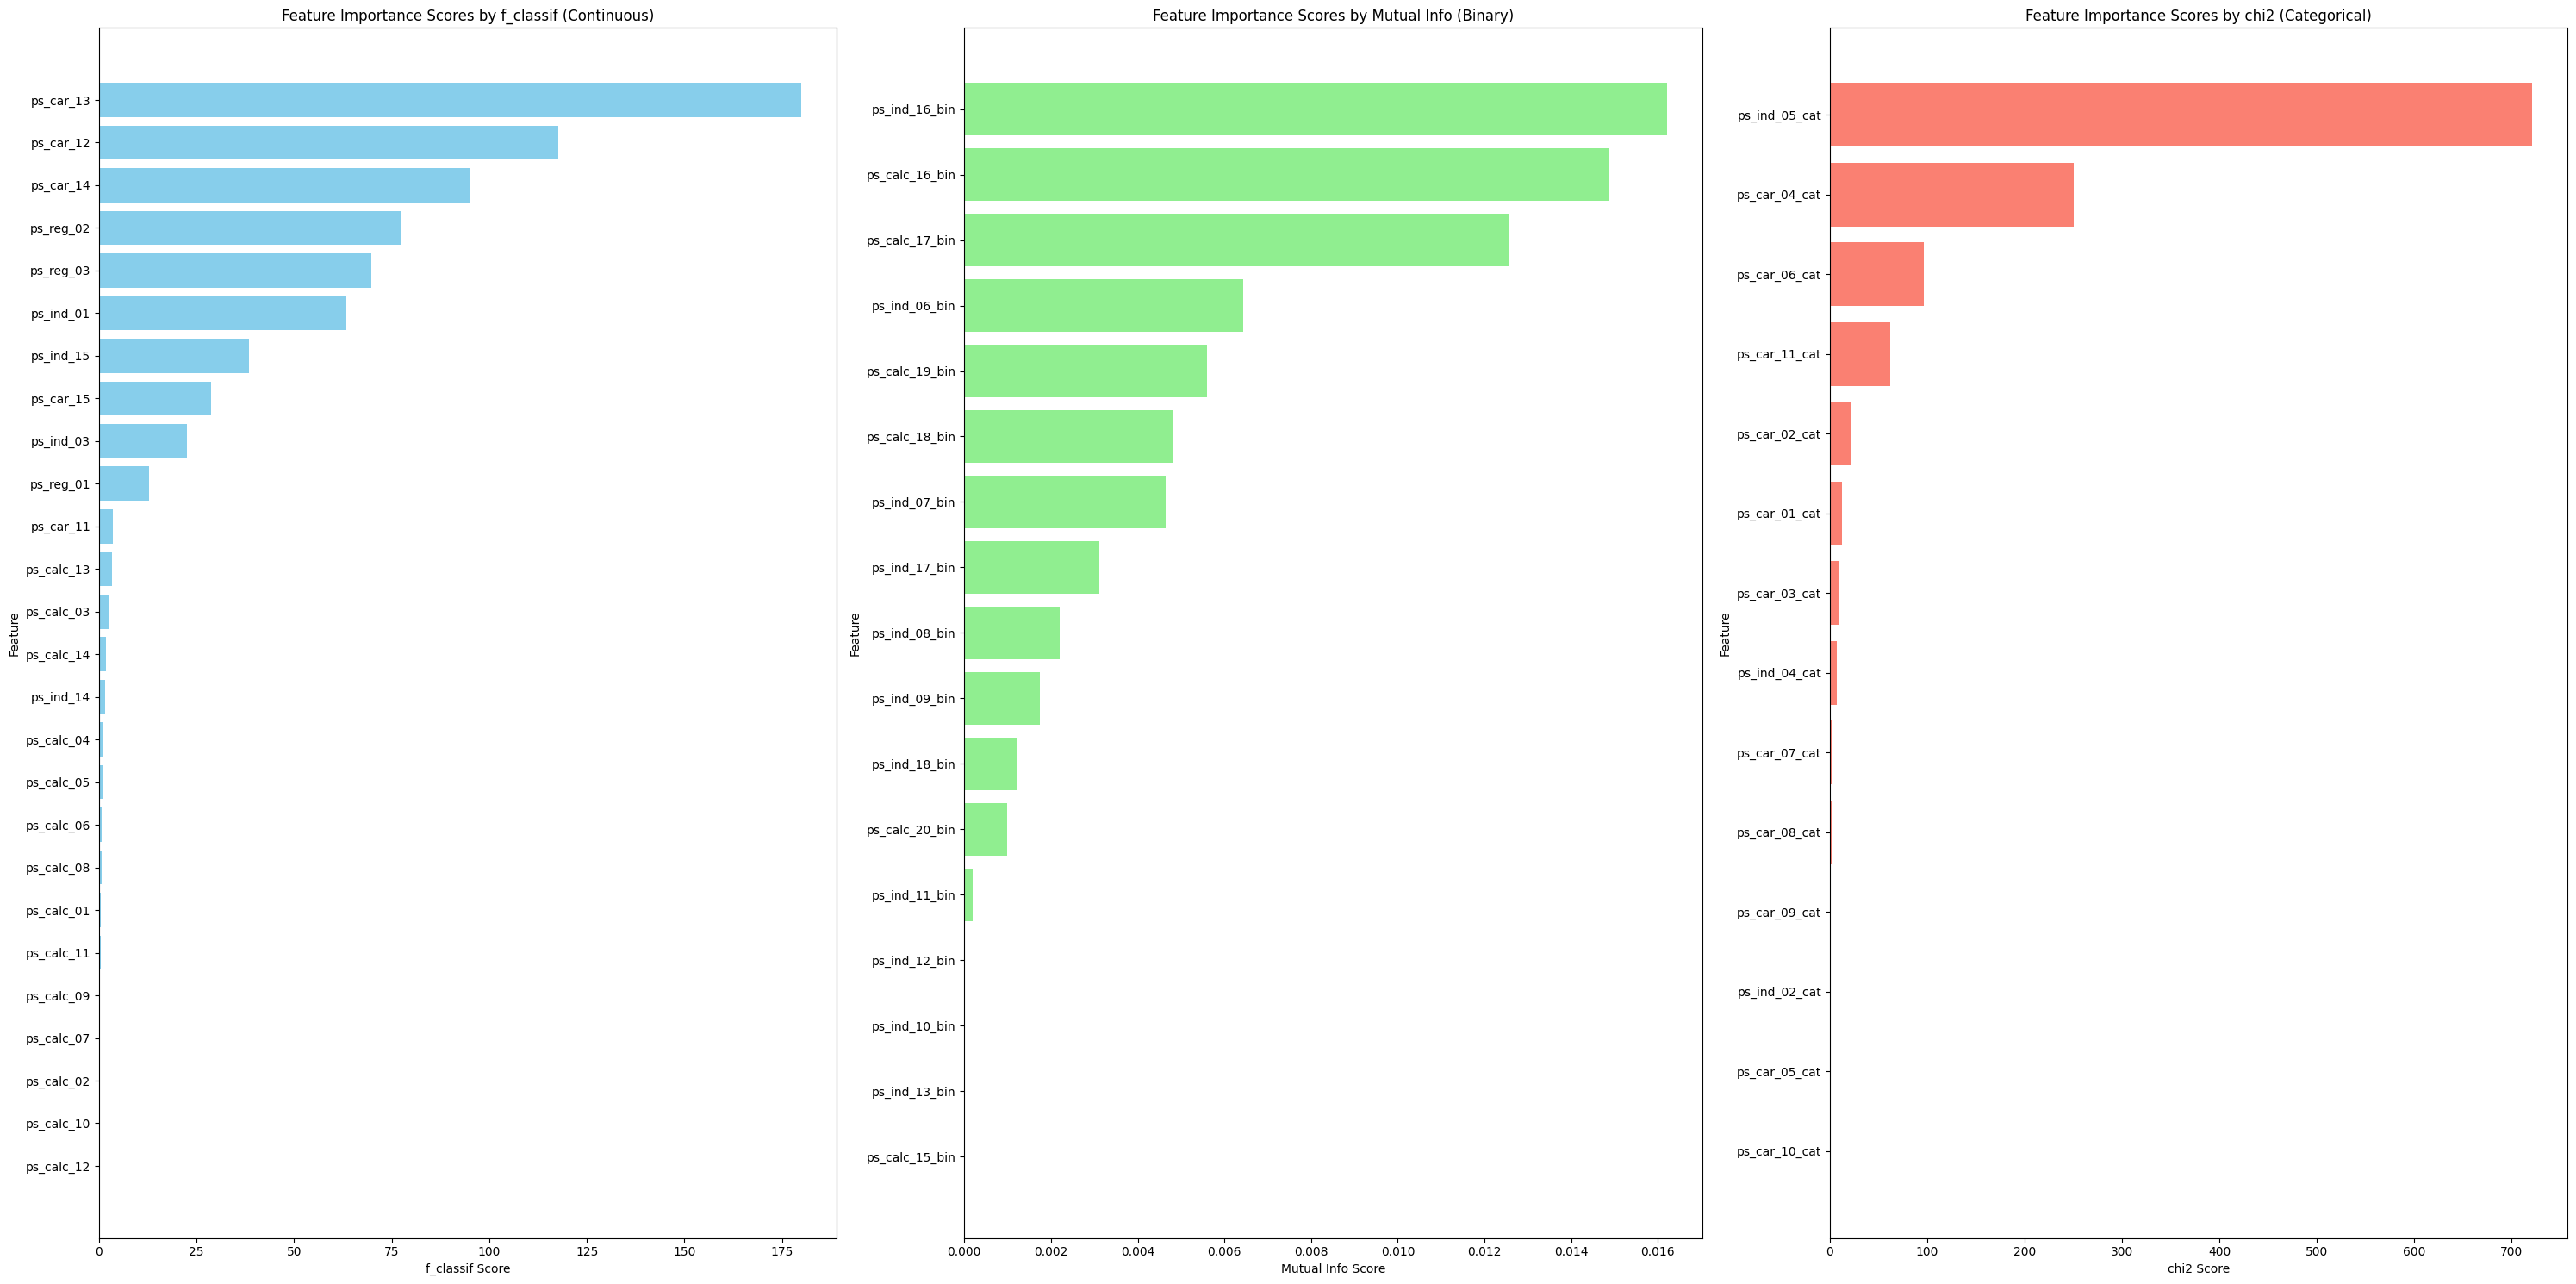

In [ ]:
feature_importance_f_classif_filtered = feature_importance_f_classif[feature_importance_f_classif['Feature'].isin(continuous_cols)]
feature_importance_mutual_info_filtered = feature_importance_mutual_info[feature_importance_mutual_info['Feature'].isin(binary_cols)]
feature_importance_chi2_filtered = feature_importance_chi2[feature_importance_chi2['Feature'].isin(categorical_cols)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))

# Subplot for f_classif (Continuous Features)
axes[0].barh(feature_importance_f_classif_filtered['Feature'], feature_importance_f_classif_filtered['f_classif Score'], color='skyblue')
axes[0].set_xlabel('f_classif Score')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Importance Scores by f_classif (Continuous)')
axes[0].invert_yaxis()

# Subplot for Mutual Info (Binary Features)
axes[1].barh(feature_importance_mutual_info_filtered['Feature'], feature_importance_mutual_info_filtered['Mutual Info Score'], color='lightgreen')
axes[1].set_xlabel('Mutual Info Score')
axes[1].set_ylabel('Feature')
axes[1].set_title('Feature Importance Scores by Mutual Info (Binary)')
axes[1].invert_yaxis()

# Subplot for chi2 (Categorical Features)
axes[2].barh(feature_importance_chi2_filtered['Feature'], feature_importance_chi2_filtered['chi2 Score'], color='salmon')
axes[2].set_xlabel('chi2 Score')
axes[2].set_ylabel('Feature')
axes[2].set_title('Feature Importance Scores by chi2 (Categorical)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


Mit V2

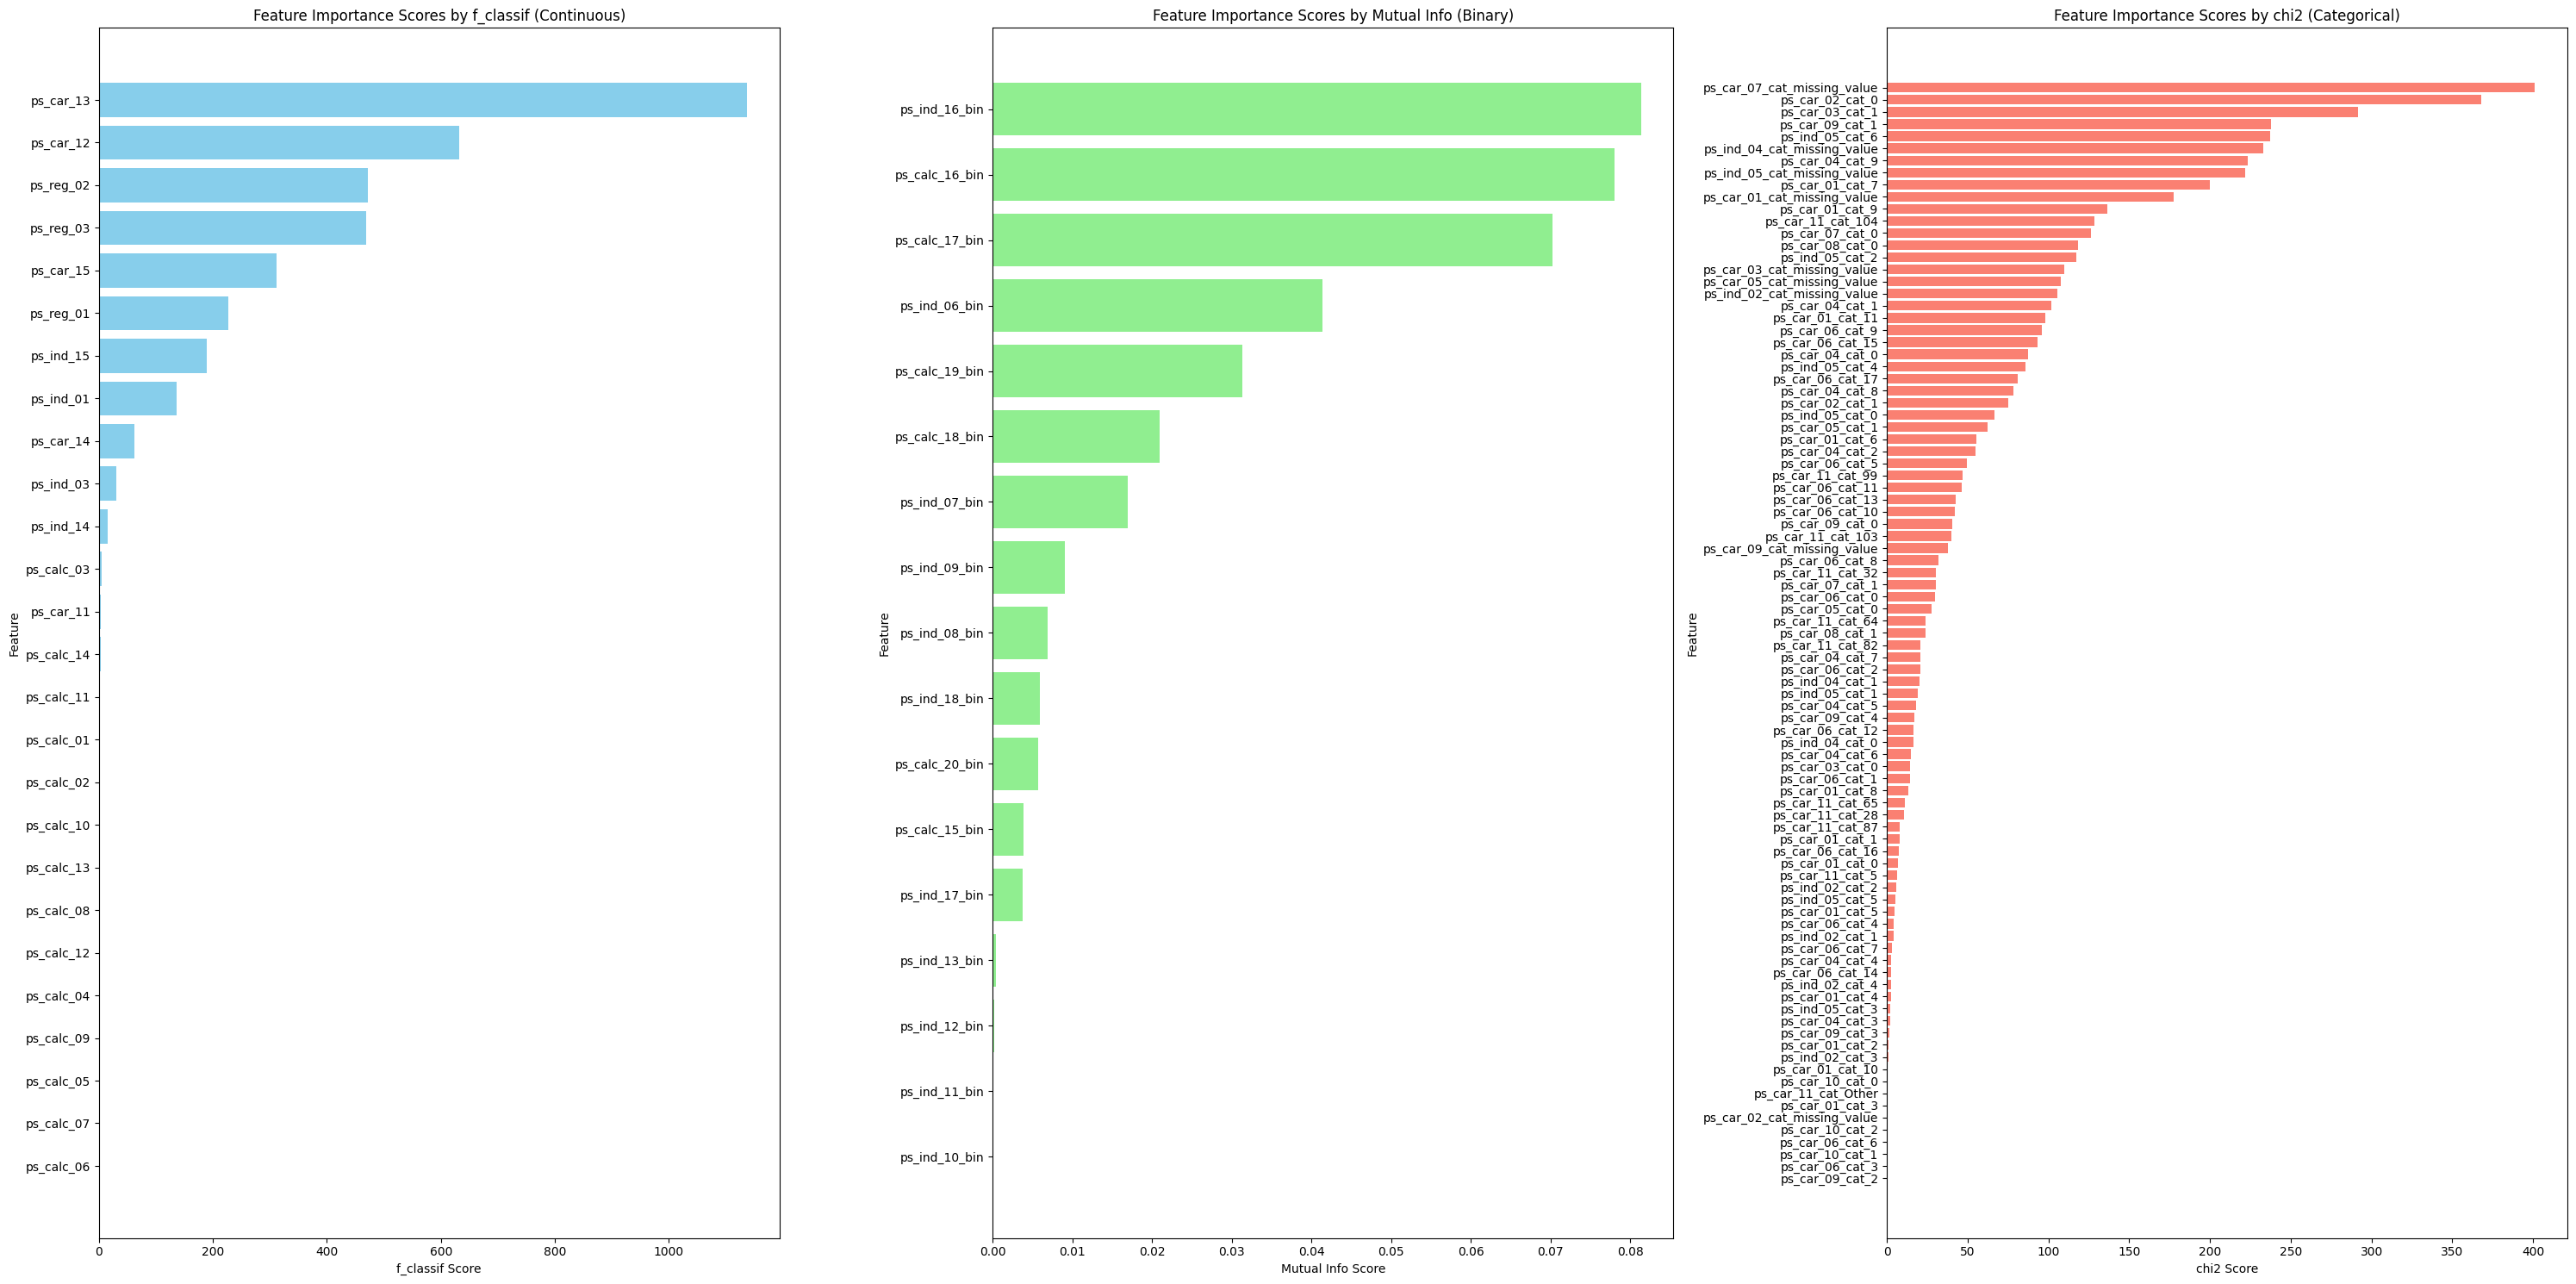

In [ ]:
feature_importance_f_classif_filtered = feature_importance_f_classif[feature_importance_f_classif['Feature'].isin(continuous_cols)]
feature_importance_mutual_info_filtered = feature_importance_mutual_info[feature_importance_mutual_info['Feature'].isin(binary_cols)]
feature_importance_chi2_filtered = feature_importance_chi2[feature_importance_chi2['Feature'].isin(categorical_cols)]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))

# Subplot for f_classif (Continuous Features)
axes[0].barh(feature_importance_f_classif_filtered['Feature'], feature_importance_f_classif_filtered['f_classif Score'], color='skyblue')
axes[0].set_xlabel('f_classif Score')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Importance Scores by f_classif (Continuous)')
axes[0].invert_yaxis()

# Subplot for Mutual Info (Binary Features)
axes[1].barh(feature_importance_mutual_info_filtered['Feature'], feature_importance_mutual_info_filtered['Mutual Info Score'], color='lightgreen')
axes[1].set_xlabel('Mutual Info Score')
axes[1].set_ylabel('Feature')
axes[1].set_title('Feature Importance Scores by Mutual Info (Binary)')
axes[1].invert_yaxis()

# Subplot for chi2 (Categorical Features)
axes[2].barh(feature_importance_chi2_filtered['Feature'], feature_importance_chi2_filtered['chi2 Score'], color='salmon')
axes[2].set_xlabel('chi2 Score')
axes[2].set_ylabel('Feature')
axes[2].set_title('Feature Importance Scores by chi2 (Categorical)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

### ExtraTreesClassifier

In [42]:
transformed_feature_names = X_train_v2.columns

In [43]:
X_train_transformed = X_train_v2
X_val_transformed = X_val_v2

et_classifier = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Fit the classifier to the entire dataset
et_classifier.fit(X_train_transformed, y_train)

# Get feature importances
feature_importances = et_classifier.feature_importances_

# Combine feature names with their importances
feature_names = transformed_feature_names
features_and_importances = list(zip(feature_names, feature_importances))

# Sort features by their importance
sorted_features = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Initialize history list to store the results
history = []

# Append each feature and its importance to the history
for feature, importance in sorted_features:
    history.append((feature, importance))

# Optionally, print each feature with its importance
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: ps_ind_05_cat_0, Importance: 0.05997801081958393
Feature: ps_ind_17_bin, Importance: 0.0521032548872335
Feature: ps_car_04_cat_0, Importance: 0.03187151923011197
Feature: ps_ind_07_bin, Importance: 0.030368646230932092
Feature: ps_ind_06_bin, Importance: 0.026789150783839224
Feature: ps_car_07_cat_1, Importance: 0.023773314611155665
Feature: ps_car_02_cat_0, Importance: 0.02272433340038432
Feature: ps_ind_16_bin, Importance: 0.02198945470981953
Feature: ps_car_02_cat_1, Importance: 0.021049427438425368
Feature: ps_reg_02, Importance: 0.019669495097540603
Feature: ps_car_13, Importance: 0.01929774119987534
Feature: ps_car_03_cat_1, Importance: 0.019104284849399106
Feature: ps_ind_05_cat_6, Importance: 0.01901922378632116
Feature: ps_car_07_cat_missing_value, Importance: 0.017624183538119436
Feature: ps_car_01_cat_7, Importance: 0.01655193928396439
Feature: ps_ind_04_cat_missing_value, Importance: 0.016396414812642597
Feature: ps_car_03_cat_missing_value, Importance: 0.015850847

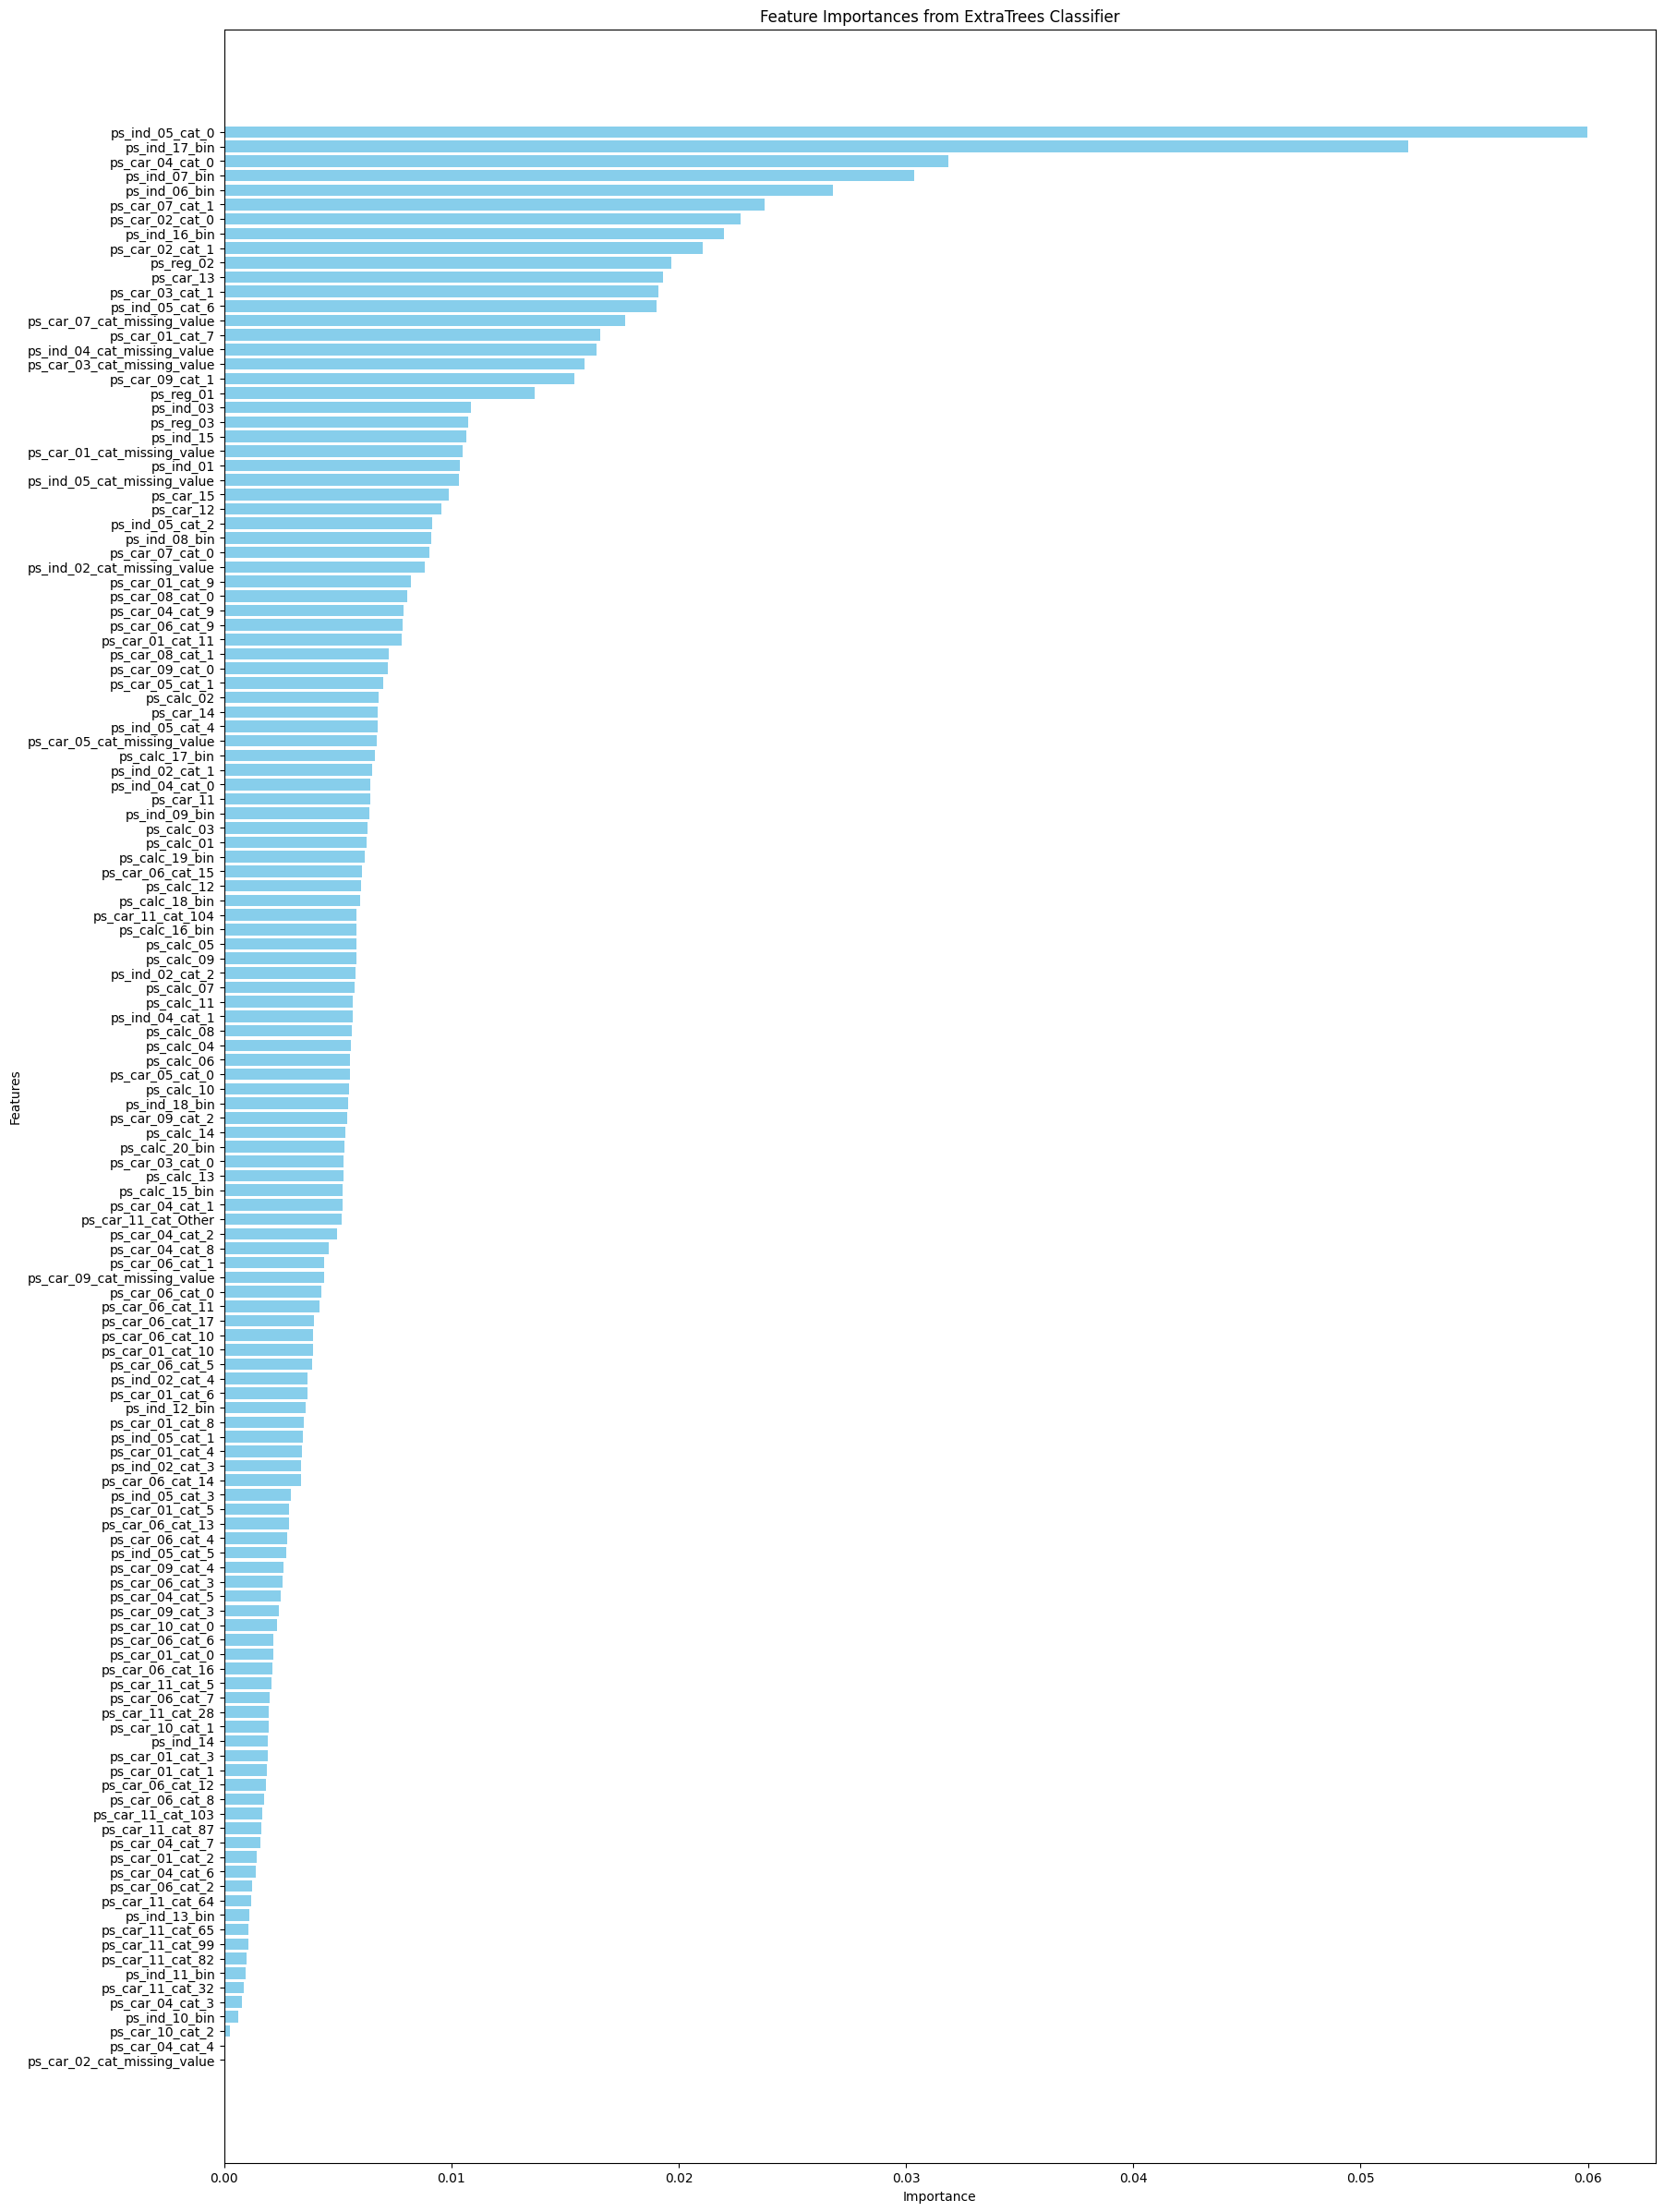

In [ ]:
features, importances = zip(*history)

# Creating the plot
plt.figure(figsize=(20, 30))  # Adjust the size to fit all features or modify as needed
plt.barh(features, importances, color='skyblue')  # Horizontal bar chart
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances from ExtraTrees Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important at the top
plt.show()


In [44]:
# Rank features based on ExtraTreesClassifier importances
extra_trees_importance = pd.DataFrame({
    'Feature': feature_names,
    'ExtraTrees Importance': feature_importances
})
extra_trees_importance['ExtraTrees Rank'] = extra_trees_importance['ExtraTrees Importance'].rank(ascending=False, method='min')

# Merge the ExtraTrees ranks into the existing feature_ranks DataFrame
feature_ranks = feature_ranks.merge(extra_trees_importance[['Feature', 'ExtraTrees Rank']], on='Feature', how='left')

# Display the updated feature_ranks DataFrame with the ExtraTrees ranks added
print(feature_ranks)


                 Feature  SelectKBest  ExtraTrees Rank
0              ps_ind_01          8.0             24.0
1              ps_ind_03         10.0             20.0
2              ps_ind_14         11.0            112.0
3              ps_ind_15          7.0             22.0
4              ps_reg_01          6.0             19.0
..                   ...          ...              ...
129     ps_car_11_cat_65         60.0            125.0
130     ps_car_11_cat_82         47.0            127.0
131     ps_car_11_cat_87         62.0            118.0
132     ps_car_11_cat_99         33.0            126.0
133  ps_car_11_cat_Other         84.0             76.0

[134 rows x 3 columns]


### Variance Selection

In [45]:
from sklearn.feature_selection import VarianceThreshold

# Initialize VarianceThreshold with a chosen threshold value (e.g., 0 to remove features with zero variance)
variance_selector = VarianceThreshold(threshold=0)

# Fit the selector to the training data
variance_selector.fit(X_train_v2)

# Get the variances of each feature
feature_variances = variance_selector.variances_

# Combine feature names with their variances
variance_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Variance': feature_variances
})

# Rank the features based on variance (higher variance gets a better rank)
variance_importance['Variance Rank'] = variance_importance['Variance'].rank(ascending=False, method='min')
variance_importance

Feature  Variance  Variance Rank
0                ps_ind_02_cat_1  0.199150           17.0
1                ps_ind_02_cat_2  0.164663           21.0
2                ps_ind_02_cat_3  0.044944           58.0
3                ps_ind_02_cat_4  0.018751           87.0
4    ps_ind_02_cat_missing_value  0.000338          129.0
..                           ...       ...            ...
129                   ps_calc_10  0.013516           97.0
130                   ps_calc_11  0.015050           93.0
131                   ps_calc_12  0.014429           94.0
132                   ps_calc_13  0.016996           91.0
133                   ps_calc_14  0.015600           92.0

[134 rows x 3 columns]

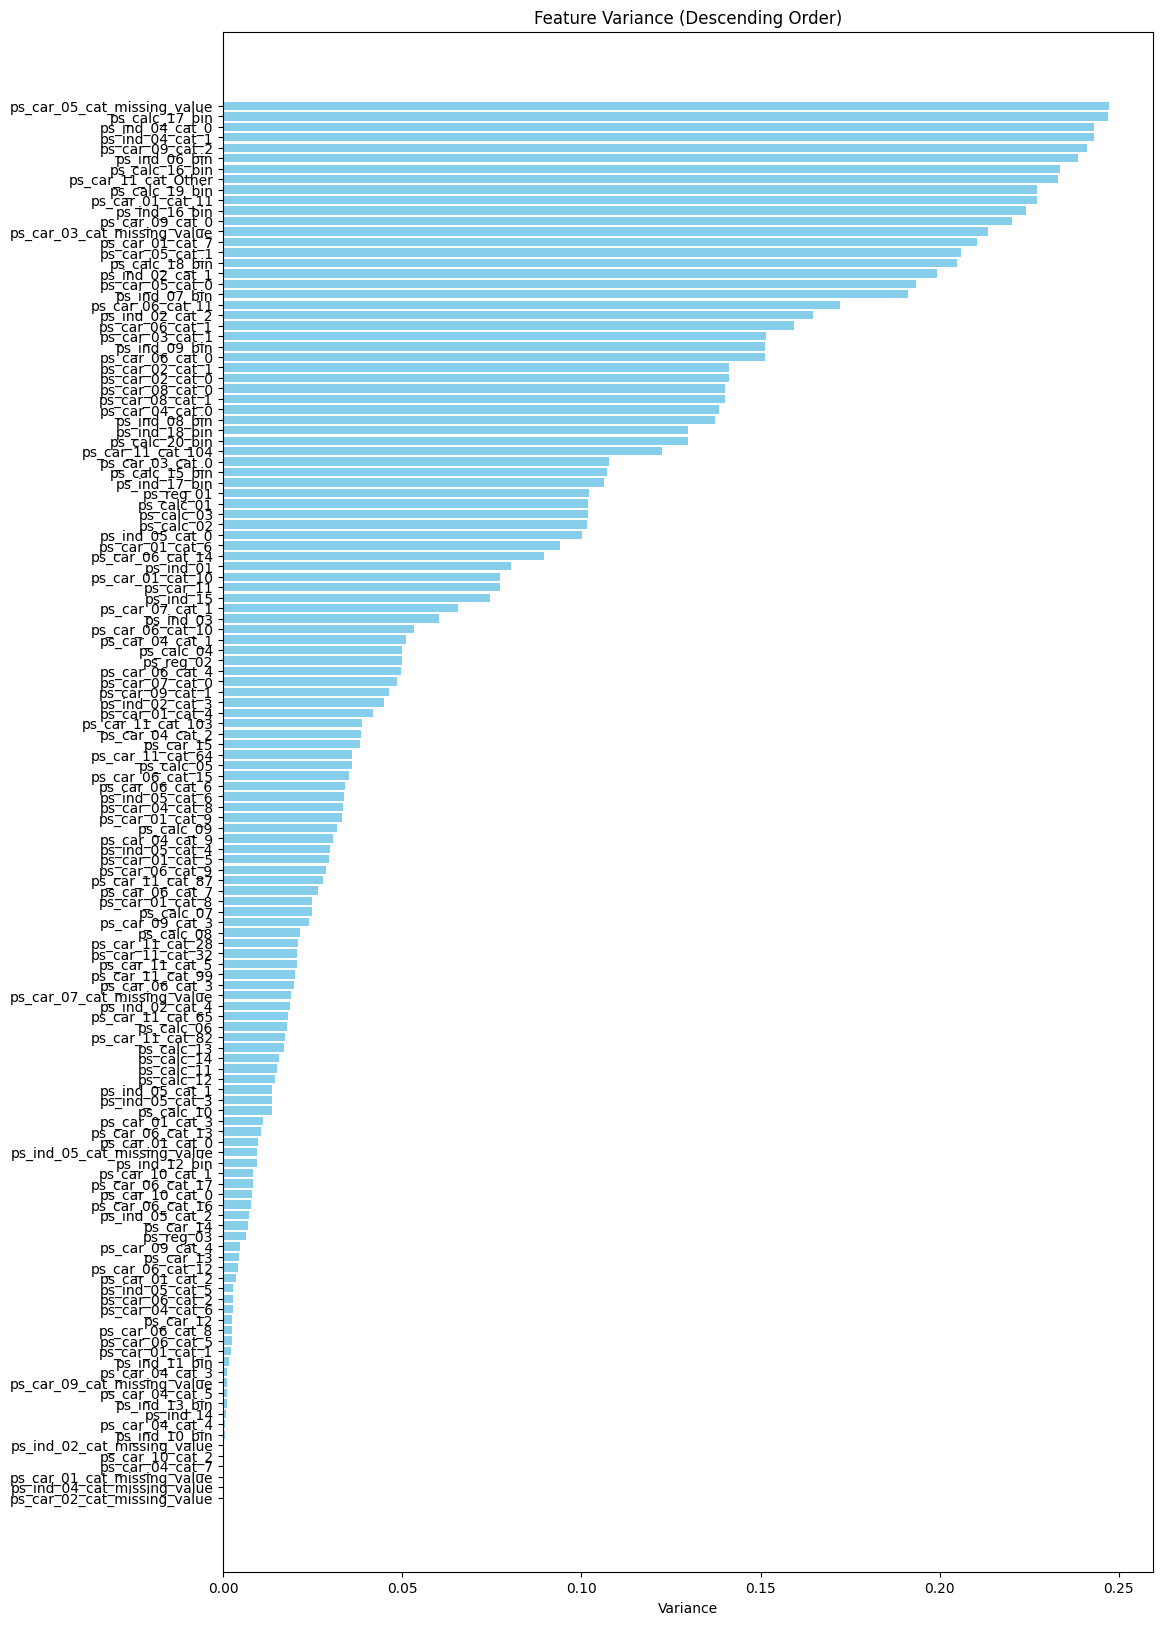

In [ ]:
import matplotlib.pyplot as plt

# Sorting the variance_importance DataFrame by 'Variance' in descending order
variance_importance_sorted = variance_importance.sort_values(by='Variance', ascending=False)

# Plotting the features by their variance in descending order
plt.figure(figsize=(12, 20))
plt.barh(variance_importance_sorted['Feature'], variance_importance_sorted['Variance'], color='skyblue')
plt.xlabel('Variance')
plt.title('Feature Variance (Descending Order)')
plt.gca().invert_yaxis()  # To display the highest variance at the top
plt.show()

In [46]:
# Merge the Variance ranks into the existing feature_ranks DataFrame
feature_ranks = feature_ranks.merge(variance_importance[['Feature', 'Variance Rank']], on='Feature', how='left')

# Display the updated feature_ranks DataFrame with the Variance ranks added
print(feature_ranks)


                 Feature  SelectKBest  ExtraTrees Rank  Variance Rank
0              ps_ind_01          8.0             24.0           45.0
1              ps_ind_03         10.0             20.0           50.0
2              ps_ind_14         11.0            112.0          126.0
3              ps_ind_15          7.0             22.0           48.0
4              ps_reg_01          6.0             19.0           38.0
..                   ...          ...              ...            ...
129     ps_car_11_cat_65         60.0            125.0           88.0
130     ps_car_11_cat_82         47.0            127.0           90.0
131     ps_car_11_cat_87         62.0            118.0           75.0
132     ps_car_11_cat_99         33.0            126.0           84.0
133  ps_car_11_cat_Other         84.0             76.0            8.0

[134 rows x 4 columns]


### embedded method

In [47]:
#Tuning für den Regularisrungsparameter alpha
lasso_cv = LassoCV(cv=5, random_state=42,n_jobs=-1).fit(X_train_v2, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best alpha using cross-validation: {best_alpha}")

Best alpha using cross-validation: 5.0715280179175314e-06


In [48]:
#Modell fitten
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_v2, y_train)

Lasso(alpha=5.0715280179175314e-06)

In [49]:
# Übrigen Features selektieren
# gucken wo die Features ungleich 0 sind
selected_features = np.where(lasso_best.coef_ != 0)[0]
# diese aus allen Featurenamen rausfiltern
selected_feature_names = X_train_v2.columns[selected_features]
# nur die relevaten Features auswählen
X_train_v2[selected_feature_names]

ps_ind_02_cat_1 ps_ind_02_cat_2 ps_ind_02_cat_3  \
0                  1.0             0.0             0.0   
1                  1.0             0.0             0.0   
2                  1.0             0.0             0.0   
3                  1.0             0.0             0.0   
4                  1.0             0.0             0.0   
...                ...             ...             ...   
416643             1.0             0.0             0.0   
416644             1.0             0.0             0.0   
416645             0.0             1.0             0.0   
416646             1.0             0.0             0.0   
416647             1.0             0.0             0.0   

       ps_ind_02_cat_missing_value ps_ind_04_cat_0  \
0                              0.0             1.0   
1                              0.0             0.0   
2                              0.0             0.0   
3                              0.0             1.0   
4                              0.0             1.0   
...                            ...             ...   
416643                         0.0             1.0   
416644                         0.0             1.0   
416645                         0.0             1.0   
416646                         0.0             1.0   
416647                         0.0             0.0   

       ps_ind_04_cat_missing_value ps_ind_05_cat_0 ps_ind_05_cat_1  \
0                              0.0             1.0             0.0   
1                              0.0             1.0             0.0   
2                              0.0             0.0             0.0   
3                              0.0             0.0             0.0   
4                              0.0             1.0             0.0   
...                            ...             ...             ...   
416643                         0.0             1.0             0.0   
416644                         0.0             1.0             0.0   
416645                         0.0             1.0             0.0   
416646                         0.0             1.0             0.0   
416647                         0.0             1.0             0.0   

       ps_ind_05_cat_2 ps_ind_05_cat_3 ps_ind_05_cat_4 ps_ind_05_cat_5  \
0                  0.0             0.0             0.0             0.0   
1                  0.0             0.0             0.0             0.0   
2                  0.0             0.0             0.0             1.0   
3                  0.0             0.0             0.0             1.0   
4                  0.0             0.0             0.0             0.0   
...                ...             ...             ...             ...   
416643             0.0             0.0             0.0             0.0   
416644             0.0             0.0             0.0             0.0   
416645             0.0             0.0             0.0             0.0   
416646             0.0             0.0             0.0             0.0   
416647             0.0             0.0             0.0             0.0   

       ps_ind_05_cat_6 ps_ind_05_cat_missing_value ps_car_01_cat_0  \
0                  0.0                         0.0             0.0   
1                  0.0                         0.0             0.0   
2                  0.0                         0.0             0.0   
3                  0.0                         0.0             0.0   
4                  0.0                         0.0             0.0   
...                ...                         ...             ...   
416643             0.0                         0.0             0.0   
416644             0.0                         0.0             0.0   
416645             0.0                         0.0             0.0   
416646             0.0                         0.0             1.0   
416647             0.0                         0.0             0.0   

       ps_car_01_cat_10 ps_car_01_cat_11 ps_car_01_cat_2 ps_car_01_cat_3  \
0             

In [50]:
#koeffizenten ausgeben lassen
importances = lasso_best.coef_

# Feature Namen
feature_names = X_train_v2.columns

# Dataframe mit dem Feature Namen und den Koiffizenten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Hinzufügen einer Sortierspalte, die sicherstellt, dass 0-Werte am Ende stehen
feature_importance_df['SortOrder'] = feature_importance_df['Importance'] == 0

# Sortieren nach der SortOrder und dann nach dem absoluten Wert der Importance
sorted_feature_importance_df = feature_importance_df.sort_values(by=['SortOrder', 'Importance'], ascending=[True, False])

# Rank als Index
sorted_feature_importance_df.index = range(1, len(sorted_feature_importance_df) + 1)
sorted_feature_importance_df.index.name = 'Rank'

# Ausgabe
sorted_feature_importance_df = sorted_feature_importance_df.drop(columns=['SortOrder'])
sorted_feature_importance_df

Feature  Importance
Rank                                         
1     ps_ind_04_cat_missing_value    0.230983
2                       ps_car_13    0.077442
3                 ps_car_04_cat_7    0.039938
4     ps_car_01_cat_missing_value    0.039044
5     ps_ind_02_cat_missing_value    0.029197
...                           ...         ...
130               ps_car_10_cat_2   -0.000000
131             ps_car_11_cat_103    0.000000
132                     ps_ind_14   -0.000000
133                    ps_calc_06   -0.000000
134                    ps_calc_07   -0.000000

[134 rows x 2 columns]

In [51]:
sorted_feature_importance_df['Lasso Rank'] = sorted_feature_importance_df.index

feature_ranks = feature_ranks.merge(sorted_feature_importance_df[['Feature', 'Lasso Rank']], on='Feature', how='left')

print(feature_ranks)


                 Feature  SelectKBest  ExtraTrees Rank  Variance Rank  \
0              ps_ind_01          8.0             24.0           45.0   
1              ps_ind_03         10.0             20.0           50.0   
2              ps_ind_14         11.0            112.0          126.0   
3              ps_ind_15          7.0             22.0           48.0   
4              ps_reg_01          6.0             19.0           38.0   
..                   ...          ...              ...            ...   
129     ps_car_11_cat_65         60.0            125.0           88.0   
130     ps_car_11_cat_82         47.0            127.0           90.0   
131     ps_car_11_cat_87         62.0            118.0           75.0   
132     ps_car_11_cat_99         33.0            126.0           84.0   
133  ps_car_11_cat_Other         84.0             76.0            8.0   

     Lasso Rank  
0            48  
1            14  
2           132  
3           114  
4            17  
..          ...

### Wrapper methods

#### Forward Selection

In [54]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

In [40]:
transformed_feature_names = X_train_v2.columns

In [ ]:
X_train_transformed = X_train_v2
X_val_transformed = X_val_v2

def evaluate_feature(feature, selected_features, X_train_transformed, X_val_transformed, y_train, y_val):
    candidate_features = selected_features + [feature]
    candidate_indices = [i for i, col in enumerate(transformed_feature_names) if col in candidate_features]

    X_train_subset = X_train_transformed.iloc[:, candidate_indices]
    X_val_subset = X_val_transformed.iloc[:, candidate_indices]

    rf_classifier.fit(X_train_subset, y_train)
    y_val_pred = rf_classifier.predict_proba(X_val_subset)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_pred)

    return roc_auc, feature

selected_features = []
remaining_features = list(transformed_feature_names)
best_roc_auc = 0
history = []

# Forward selection loop
while remaining_features:
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_feature)(feature, selected_features, X_train_transformed, X_val_transformed, y_train, y_val)
        for feature in remaining_features
    )

    if results:
        results.sort(reverse=True, key=lambda x: x[0])
        best_feature = results[0][1]
        best_roc_auc_candidate = results[0][0]

        if best_roc_auc_candidate > best_roc_auc:
            best_roc_auc = best_roc_auc_candidate
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)

            history.append((list(selected_features), best_roc_auc))

            print(f"Selected Feature: {best_feature}, ROC AUC: {best_roc_auc}")
        else:
            break
    else:
        print("No valid feature found in this iteration.")
        break


print(f"Final selected features: {selected_features}")

In [ ]:
feature_history = [
    ['ps_car_13'],
    ['ps_car_13', 'ps_ind_05_cat_0'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin', 'ps_calc_08'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin', 'ps_calc_08', 'ps_car_03_cat_missing_value'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin', 'ps_calc_08', 'ps_car_03_cat_missing_value', 'ps_car_01_cat_7'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin', 'ps_calc_08', 'ps_car_03_cat_missing_value', 'ps_car_01_cat_7', 'ps_car_06_cat_6'],
    ['ps_car_13', 'ps_ind_05_cat_0', 'ps_reg_03', 'ps_ind_17_bin', 'ps_ind_15', 'ps_ind_03', 'ps_ind_06_bin', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_04_cat_0', 'ps_car_01_cat_6', 'ps_ind_09_bin', 'ps_calc_08', 'ps_car_03_cat_missing_value', 'ps_car_01_cat_7', 'ps_car_06_cat_6', 'ps_car_11_cat_5']
]

roc_auc_history = [
    0.5738, 0.5907, 0.6024, 0.6115, 0.6170, 0.6228, 0.6251, 0.6282, 0.6298,
    0.6323, 0.6325, 0.6346, 0.6355, 0.6360, 0.6371, 0.6371, 0.6378
]

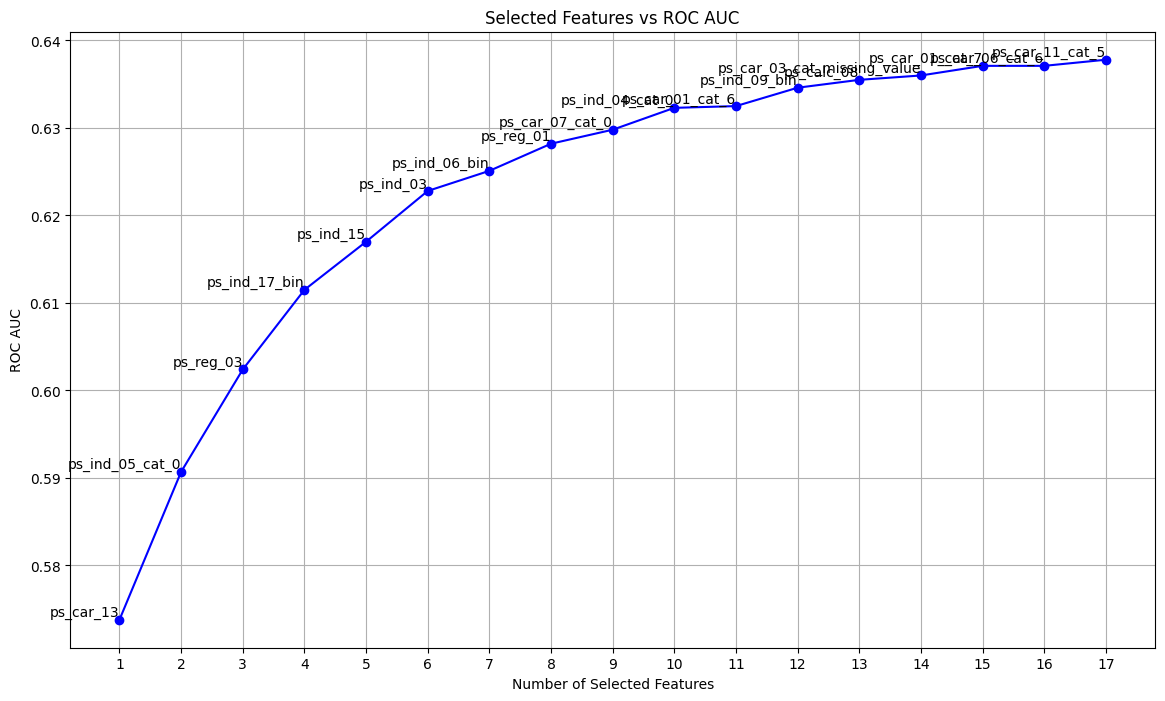

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(range(1, len(feature_history) + 1), roc_auc_history, marker='o', linestyle='-', color='b')
plt.title('Selected Features vs ROC AUC')
plt.xlabel('Number of Selected Features')
plt.ylabel('ROC AUC')
plt.grid(True)

for i, (features, roc_auc) in enumerate(zip(feature_history, roc_auc_history), start=1):
    plt.text(i, roc_auc, f"{features[-1]}", fontsize=10, ha='right', va='bottom')

plt.xticks(ticks=range(1, len(feature_history) + 1), labels=[str(len(f)) for f in feature_history])

plt.show()

In [52]:
selected_features = [
 ['ps_car_13',
  'ps_ind_05_cat_0',
  'ps_reg_03',
  'ps_ind_17_bin',
  'ps_ind_15',
  'ps_ind_03',
  'ps_ind_06_bin',
  'ps_reg_01',
  'ps_car_07_cat_0',
  'ps_ind_04_cat_0',
  'ps_car_01_cat_6',
  'ps_ind_09_bin',
  'ps_calc_08',
  'ps_car_03_cat_missing_value',
  'ps_car_01_cat_7',
  'ps_car_06_cat_6',
  'ps_car_11_cat_5']
]


In [53]:
forward_selection_rank = pd.DataFrame({
    'Feature': selected_features[0],  # Extract the list of selected features
    'Forward Selection Rank': range(1, len(selected_features[0]) + 1)  # Ranks starting from 1
})

if not isinstance(feature_ranks, pd.DataFrame):
    feature_ranks = pd.DataFrame(feature_ranks)

# Assign rank 18 to all features not in the selected features list
all_features = feature_ranks['Feature']
unselected_features = all_features[~all_features.isin(selected_features[0])]
unselected_features_rank = pd.DataFrame({
    'Feature': unselected_features,
    'Forward Selection Rank': 134
})


In [54]:
combined_forward_selection_rank = pd.concat([forward_selection_rank, unselected_features_rank])

feature_ranks = feature_ranks.merge(combined_forward_selection_rank, on='Feature', how='left')

print(feature_ranks)


                 Feature  SelectKBest  ExtraTrees Rank  Variance Rank  \
0              ps_ind_01          8.0             24.0           45.0   
1              ps_ind_03         10.0             20.0           50.0   
2              ps_ind_14         11.0            112.0          126.0   
3              ps_ind_15          7.0             22.0           48.0   
4              ps_reg_01          6.0             19.0           38.0   
..                   ...          ...              ...            ...   
129     ps_car_11_cat_65         60.0            125.0           88.0   
130     ps_car_11_cat_82         47.0            127.0           90.0   
131     ps_car_11_cat_87         62.0            118.0           75.0   
132     ps_car_11_cat_99         33.0            126.0           84.0   
133  ps_car_11_cat_Other         84.0             76.0            8.0   

     Lasso Rank  Forward Selection Rank  
0            48                     134  
1            14                       6

Older Features (X_train)

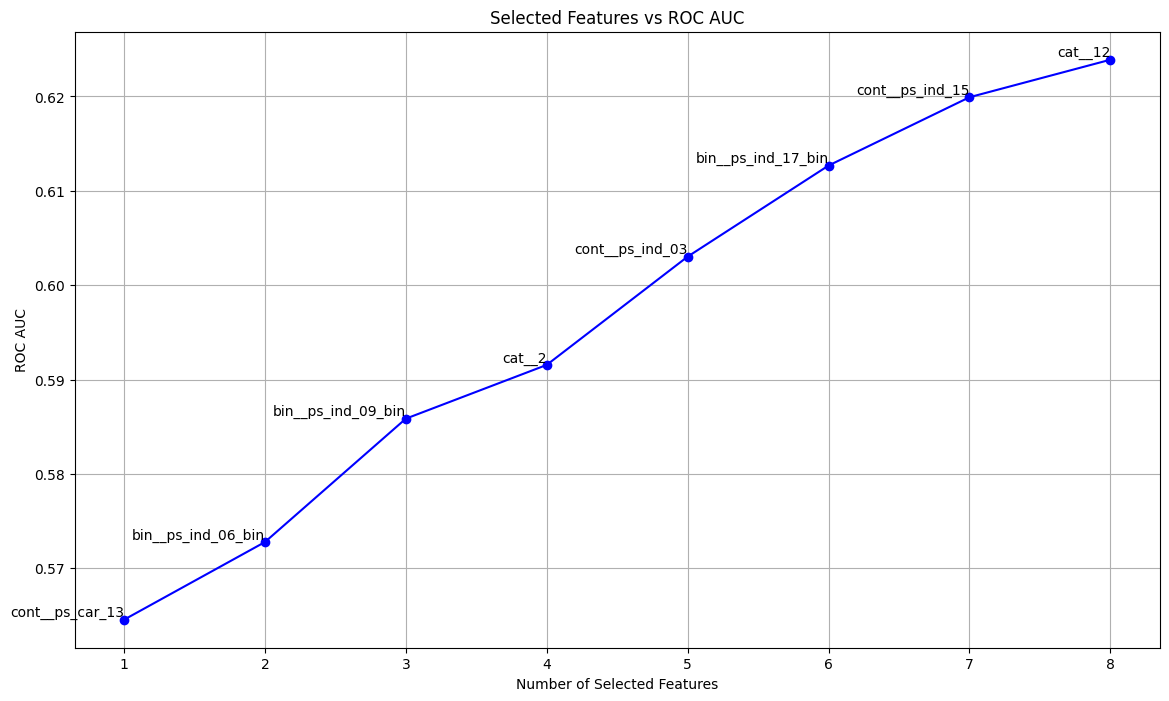

In [ ]:
feature_history, roc_auc_history = zip(*history)

plt.figure(figsize=(14, 8))
plt.plot(range(1, len(feature_history) + 1), roc_auc_history, marker='o', linestyle='-', color='b')
plt.title('Selected Features vs ROC AUC')
plt.xlabel('Number of Selected Features')
plt.ylabel('ROC AUC')
plt.grid(True)

for i, (features, roc_auc) in enumerate(zip(feature_history, roc_auc_history), start=1):
    plt.text(i, roc_auc, f"{features[-1]}", fontsize=10, ha='right', va='bottom')

plt.xticks(ticks=range(1, len(feature_history) + 1), labels=[str(len(f)) for f in feature_history])

plt.show()


#### Backward Selection

In [ ]:
X_train_transformed = pipeline_RF_3.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline_RF_3.named_steps['preprocessor'].transform(X_val)

def evaluate_feature_removal(feature_to_remove, current_features, X_train_transformed, X_val_transformed, y_train, y_val):
    candidate_features = [f for f in current_features if f != feature_to_remove]
    candidate_indices = [i for i, col in enumerate(transformed_feature_names) if col in candidate_features]

    X_train_subset = X_train_transformed[:, candidate_indices]
    X_val_subset = X_val_transformed[:, candidate_indices]

    pipeline_RF_3.named_steps['classifier'].fit(X_train_subset, y_train)
    y_val_pred = pipeline_RF_3.named_steps['classifier'].predict_proba(X_val_subset)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_pred)

    return roc_auc, feature_to_remove

selected_features = list(transformed_feature_names)
best_roc_auc = 0
history = []

X_train_subset = X_train_transformed[:, :]
X_val_subset = X_val_transformed[:, :]

pipeline_RF_3.named_steps['classifier'].fit(X_train_subset, y_train)
y_val_pred = pipeline_RF_3.named_steps['classifier'].predict_proba(X_val_subset)[:, 1]

best_roc_auc = roc_auc_score(y_val, y_val_pred)
history.append((list(selected_features), best_roc_auc))
print(f"Initial ROC AUC with all features: {best_roc_auc}")

while len(selected_features) > 1:
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_feature_removal)(feature, selected_features, X_train_transformed, X_val_transformed, y_train, y_val)
        for feature in selected_features
    )

    if results:
        results.sort(reverse=True, key=lambda x: x[0])
        worst_feature_to_remove = results[-1][1]
        best_roc_auc_candidate = results[-1][0]

        if best_roc_auc_candidate >= best_roc_auc:
            best_roc_auc = best_roc_auc_candidate
            selected_features.remove(worst_feature_to_remove)

            history.append((list(selected_features), best_roc_auc))

            print(f"Removed Feature: {worst_feature_to_remove}, ROC AUC: {best_roc_auc}")
        else:
            break
    else:
        print("No valid feature removal found in this iteration.")
        break

print(f"Final selected features after backward selection: {selected_features}")


Initial ROC AUC with all features: 0.6096050981734704
Final selected features after backward selection: ['cat__0', 'cat__1', 'cat__2', 'cat__3', 'cat__4', 'cat__5', 'cat__6', 'cat__7', 'cat__8', 'cat__9', 'cat__10', 'cat__11', 'cat__12', 'cat__13', 'bin__ps_ind_06_bin', 'bin__ps_ind_07_bin', 'bin__ps_ind_08_bin', 'bin__ps_ind_09_bin', 'bin__ps_ind_10_bin', 'bin__ps_ind_11_bin', 'bin__ps_ind_12_bin', 'bin__ps_ind_13_bin', 'bin__ps_ind_16_bin', 'bin__ps_ind_17_bin', 'bin__ps_ind_18_bin', 'bin__ps_calc_15_bin', 'bin__ps_calc_16_bin', 'bin__ps_calc_17_bin', 'bin__ps_calc_18_bin', 'bin__ps_calc_19_bin', 'bin__ps_calc_20_bin', 'cont__ps_ind_01', 'cont__ps_ind_03', 'cont__ps_ind_14', 'cont__ps_ind_15', 'cont__ps_reg_01', 'cont__ps_reg_02', 'cont__ps_reg_03', 'cont__ps_car_11', 'cont__ps_car_12', 'cont__ps_car_13', 'cont__ps_car_14', 'cont__ps_car_15', 'cont__ps_calc_01', 'cont__ps_calc_02', 'cont__ps_calc_03', 'cont__ps_calc_04', 'cont__ps_calc_05', 'cont__ps_calc_06', 'cont__ps_calc_07', 'co

Mögliches lokales Minimum

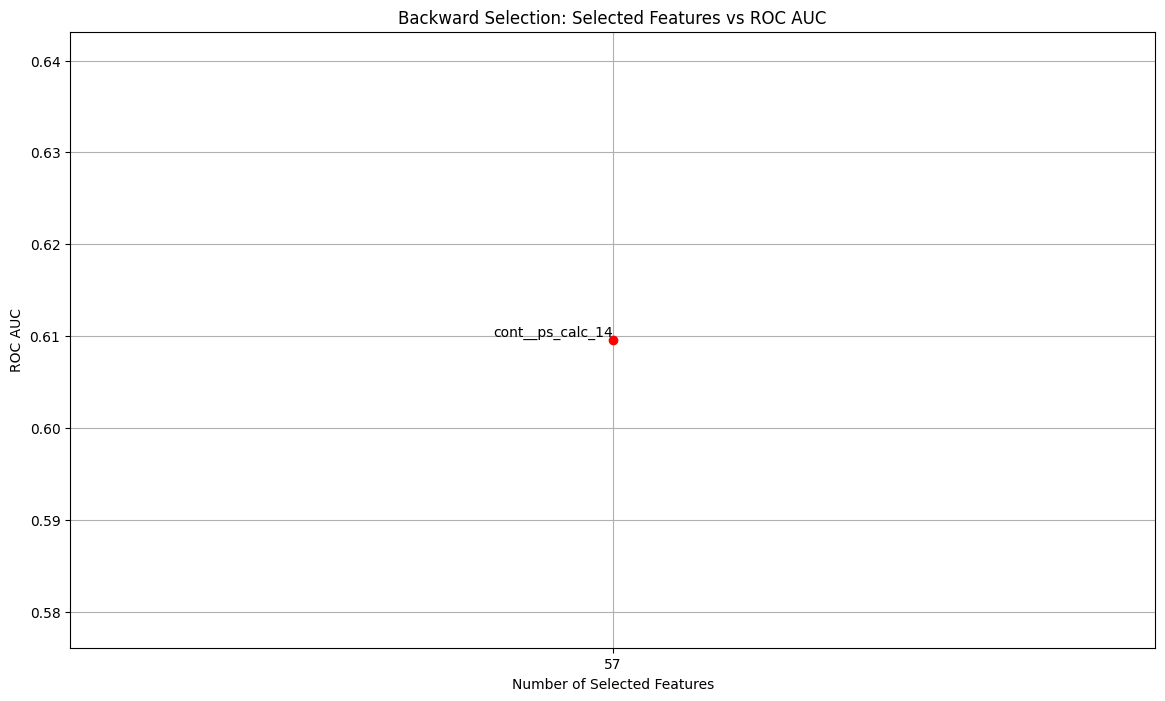

In [ ]:
backward_feature_history, backward_roc_auc_history = zip(*history)

# Create a plot for backward selection
plt.figure(figsize=(14, 8))
plt.plot(range(1, len(backward_feature_history) + 1), backward_roc_auc_history, marker='o', linestyle='-', color='r')
plt.title('Backward Selection: Selected Features vs ROC AUC')
plt.xlabel('Number of Selected Features')
plt.ylabel('ROC AUC')
plt.grid(True)

# Annotate the plot with the feature names
for i, (features, roc_auc) in enumerate(zip(backward_feature_history, backward_roc_auc_history), start=1):
    plt.text(i, roc_auc, f"{features[-1]}", fontsize=10, ha='right', va='bottom')

# Customize x-axis labels to show the count of selected features
plt.xticks(ticks=range(1, len(backward_feature_history) + 1), labels=[str(len(f)) for f in backward_feature_history])

plt.show()

#### Recursive Feature Elimination (RFE)

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import copy

X_train_transformed = X_train_v2
X_val_transformed = X_val_v2

selected_features = list(transformed_feature_names)
history = []

while len(selected_features) > 1:
    rf_classifier.fit(X_train_transformed[selected_features], y_train)
    
    y_val_pred = rf_classifier.predict_proba(X_val_transformed[selected_features])[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    history.append((copy.deepcopy(selected_features), roc_auc))
    
    importances = rf_classifier.feature_importances_
    
    least_important_idx = importances.argmin()
    least_important_feature = selected_features[least_important_idx]
    
    print(f"Removing feature: {least_important_feature}, ROC AUC: {roc_auc}")
    

    selected_features.remove(least_important_feature)

rf_classifier.fit(X_train_transformed[selected_features], y_train)
y_val_pred = rf_classifier.predict_proba(X_val_transformed[selected_features])[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
history.append((copy.deepcopy(selected_features), roc_auc))

print(f"Final selected feature: {selected_features}")


Removing feature: ps_car_02_cat_missing_value, ROC AUC: 0.6315601667003459
Removing feature: ps_car_04_cat_4, ROC AUC: 0.6325786562994641
Removing feature: ps_car_10_cat_2, ROC AUC: 0.6333845180521691
Removing feature: ps_car_11_cat_82, ROC AUC: 0.6319329316573907
Removing feature: ps_ind_10_bin, ROC AUC: 0.6336259597188366
Removing feature: ps_ind_11_bin, ROC AUC: 0.633024113102325
Removing feature: ps_car_04_cat_3, ROC AUC: 0.6313255659047158
Removing feature: ps_car_11_cat_99, ROC AUC: 0.6327130195800519
Removing feature: ps_car_11_cat_65, ROC AUC: 0.6333707255701457
Removing feature: ps_car_11_cat_32, ROC AUC: 0.6328506336139784
Removing feature: ps_car_11_cat_64, ROC AUC: 0.6330623826853132
Removing feature: ps_ind_13_bin, ROC AUC: 0.6337260543436223
Removing feature: ps_car_11_cat_103, ROC AUC: 0.6324129107462589
Removing feature: ps_car_06_cat_2, ROC AUC: 0.6332238486753315
Removing feature: ps_car_11_cat_87, ROC AUC: 0.6321875585224908
Removing feature: ps_car_04_cat_6, ROC AUC

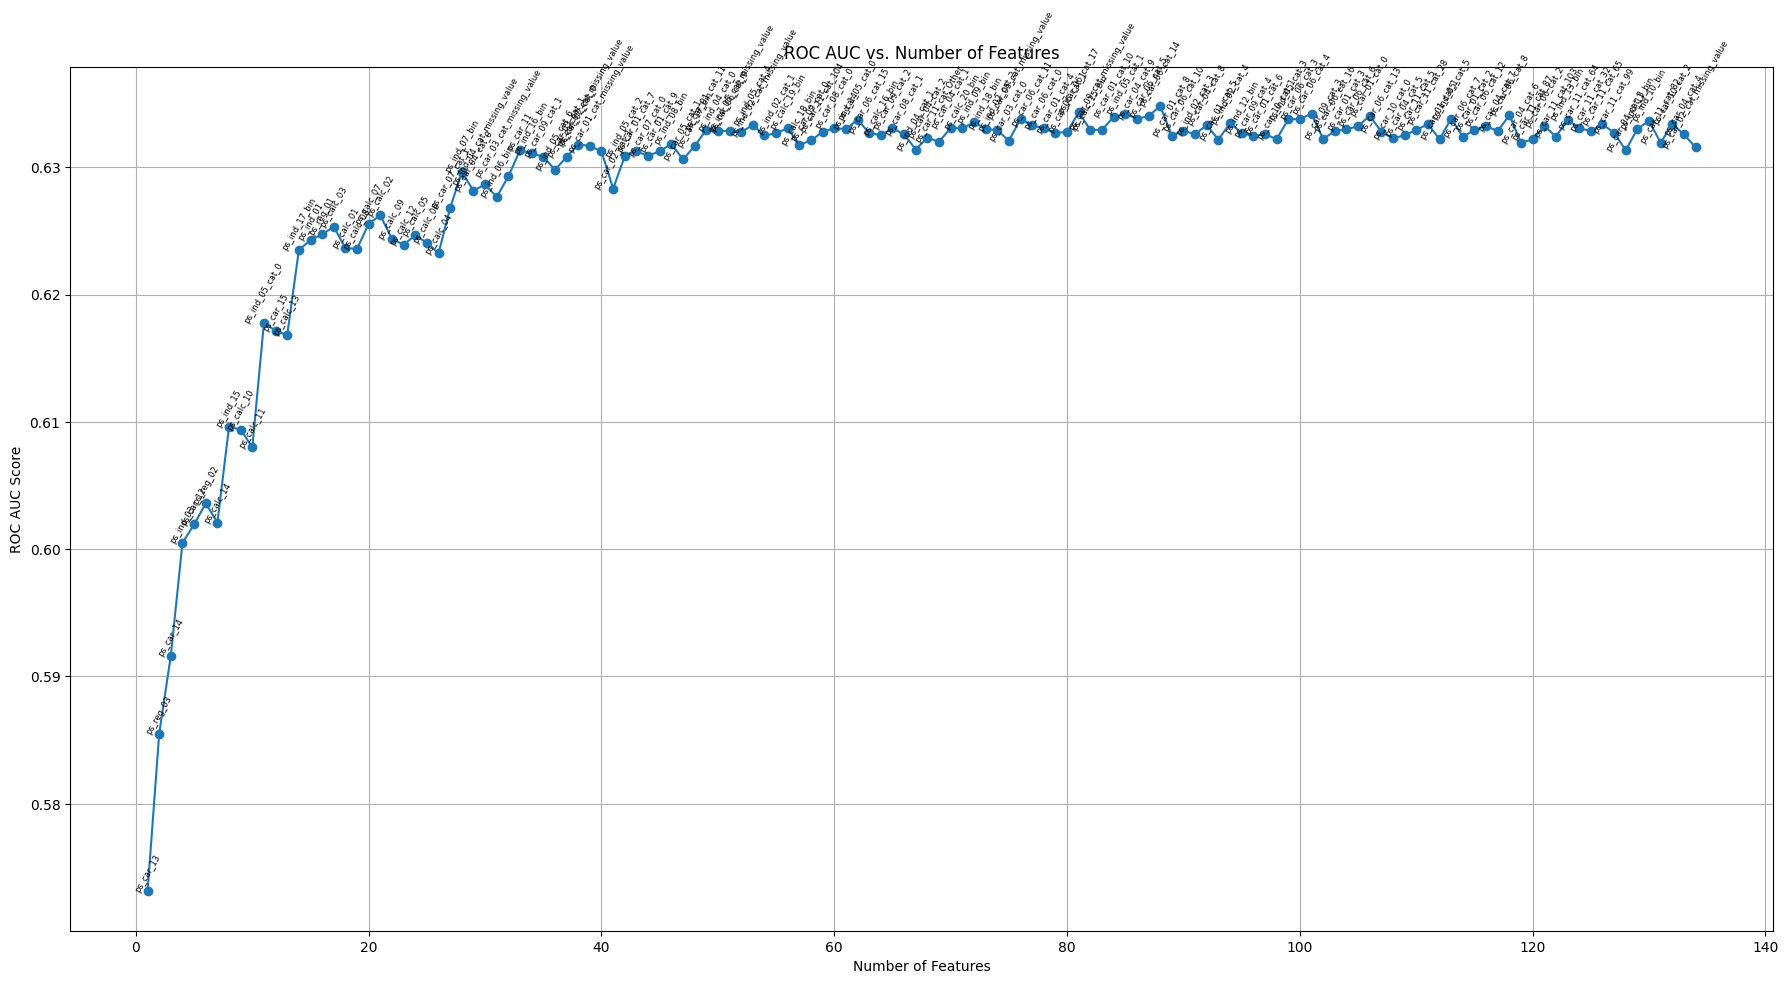

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

num_features = [len(features) for features, _ in history]
roc_auc_scores = [roc_auc for _, roc_auc in history]
removed_features = []

for i in range(len(history) - 1):
    current_features = set(history[i][0])
    next_features = set(history[i + 1][0])
    removed_feature = list(current_features - next_features)
    if removed_feature:
        removed_features.append(removed_feature[0])
    else:
        removed_features.append(None)
removed_features.append(history[-1][0][0])  

history_df = pd.DataFrame({
    'num_features': num_features,
    'roc_auc': roc_auc_scores,
    'removed_feature': removed_features
})

history_df = history_df.iloc[::-1].reset_index(drop=True)

plt.figure(figsize=(18, 10))
plt.plot(history_df['num_features'], history_df['roc_auc'], marker='o', linestyle='-')

for idx in range(len(history_df)):
    feature = history_df['removed_feature'].iloc[idx]
    x = history_df['num_features'].iloc[idx]
    y = history_df['roc_auc'].iloc[idx]
    plt.annotate(
        feature,
        (x, y),
        textcoords="offset points",
        xytext=(0, 0),
        ha='center',
        fontsize=6,    # Reduced font size
        rotation=60    # Increased rotation angle
    )

plt.xlabel('Number of Features')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC vs. Number of Features')
plt.grid(True)
plt.tight_layout()
plt.show()


    Forward selection is often better at finding combinations of features that work well together, as it optimizes step-by-step, while RFE might retain or eliminate features based on their standalone importance, possibly missing critical interactions.

#### Exhaustive Feature Search

In [ ]:
X_train_transformed = pipeline_RF_3.named_steps['preprocessor'].transform(X_train)
X_val_transformed = pipeline_RF_3.named_steps['preprocessor'].transform(X_val)

classifier = pipeline_RF_3.named_steps['classifier']

history = []

def evaluate_combination(combo):
    """Evaluate a single combination of features."""
    selected_indices = [i for i, col in enumerate(transformed_feature_names) if col in combo]

    X_train_subset = X_train_transformed[:, selected_indices]
    X_val_subset = X_val_transformed[:, selected_indices]

    classifier.fit(X_train_subset, y_train)
    y_val_pred = classifier.predict_proba(X_val_subset)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_pred)

    print(f"Evaluating combination: {combo}, ROC AUC: {roc_auc:.4f}")

    return list(combo), roc_auc

for n_features in range(1, len(transformed_feature_names) + 1):
    combos = list(combinations(transformed_feature_names, n_features))

    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(combo) for combo in combos)

    history.extend(results)

    best_for_size = max(results, key=lambda x: x[1])
    print(f"Best combination for {n_features} features: {best_for_size[0]}, ROC AUC: {best_for_size[1]:.4f}")

    print(f"Finished evaluating all {n_features}-feature combinations.")

# Convert the history to a DataFrame for easier analysis
history_df = pd.DataFrame(history, columns=['Selected Features', 'ROC AUC'])

# Identify the overall best combination of features
best_combination = history_df.loc[history_df['ROC AUC'].idxmax()]

# Print the overall best combination and its ROC AUC
print(f"Best Feature Combination: {best_combination['Selected Features']}, ROC AUC: {best_combination['ROC AUC']:.4f}")


Best combination for 1 features: ['cont__ps_car_13'], ROC AUC: 0.5646
Finished evaluating all 1-feature combinations.
Best combination for 2 features: ['bin__ps_ind_17_bin', 'cont__ps_car_12'], ROC AUC: 0.5845
Finished evaluating all 2-feature combinations.


KeyboardInterrupt: 

Exhaustive Feature Search nicht sinvoll ==> 144 quadrillion Kombinationen

## Feature Selection

In [56]:
feature_ranks_long = feature_ranks.melt(id_vars=['Feature'],
                                        value_vars=['SelectKBest', 'ExtraTrees Rank', 'Lasso Rank', 'Forward Selection Rank'],
                                        var_name='Method',
                                        value_name='Rank')


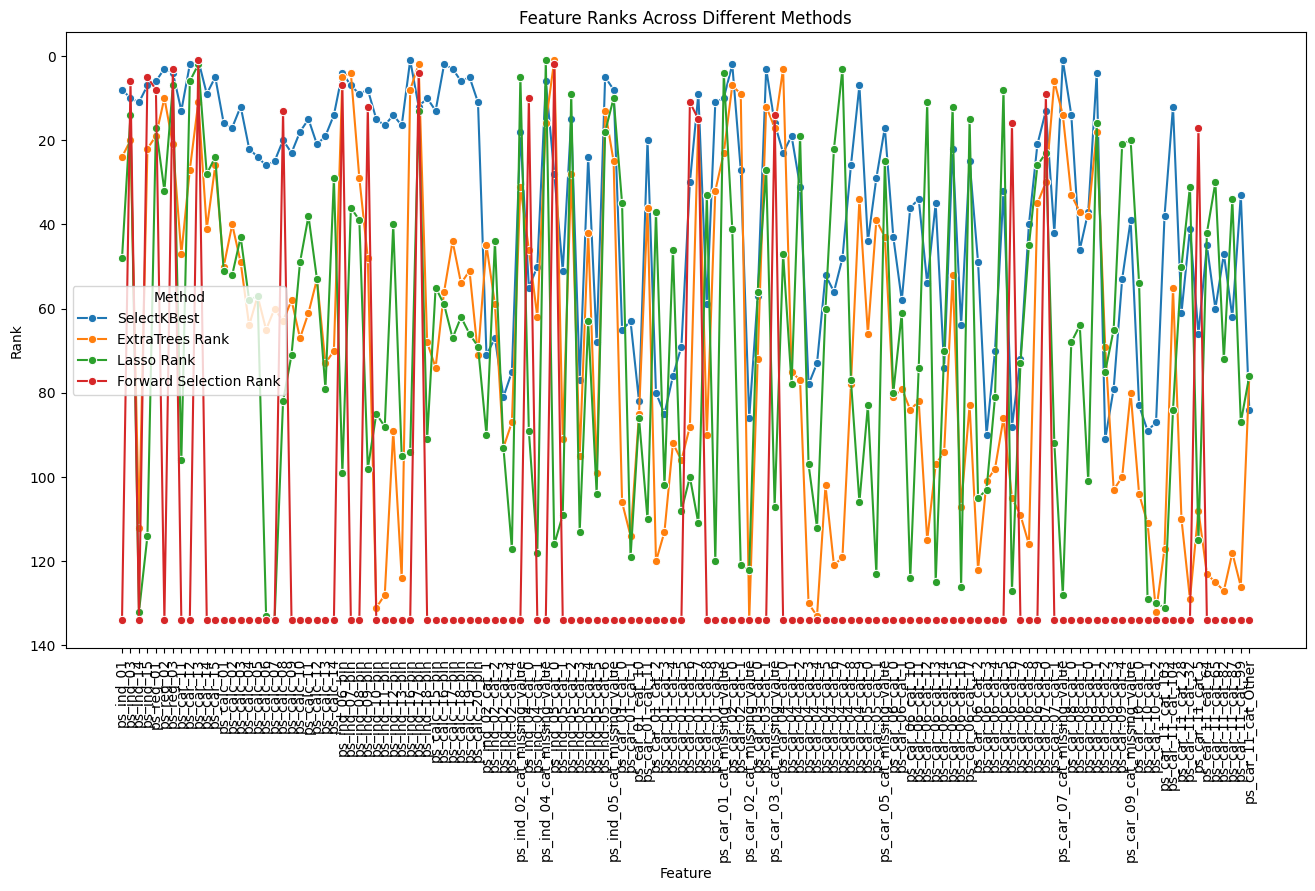

In [ ]:
plt.figure(figsize=(16, 8))

sns.lineplot(x='Feature', y='Rank', hue='Method', data=feature_ranks_long, marker='o')

plt.xlabel('Feature')
plt.ylabel('Rank')
plt.title('Feature Ranks Across Different Methods')
plt.xticks(rotation=90)
plt.gca().invert_yaxis()

plt.show()

In [57]:
feature_ranks['Final Ranking'] = feature_ranks[['SelectKBest', 'ExtraTrees Rank', 'Lasso Rank', 'Forward Selection Rank']].sum(axis=1)


C:\Users\carlo\AppData\Local\Temp\ipykernel_19816\1131333367.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Final Ranking', data=sorted_feature_ranks, palette='viridis')


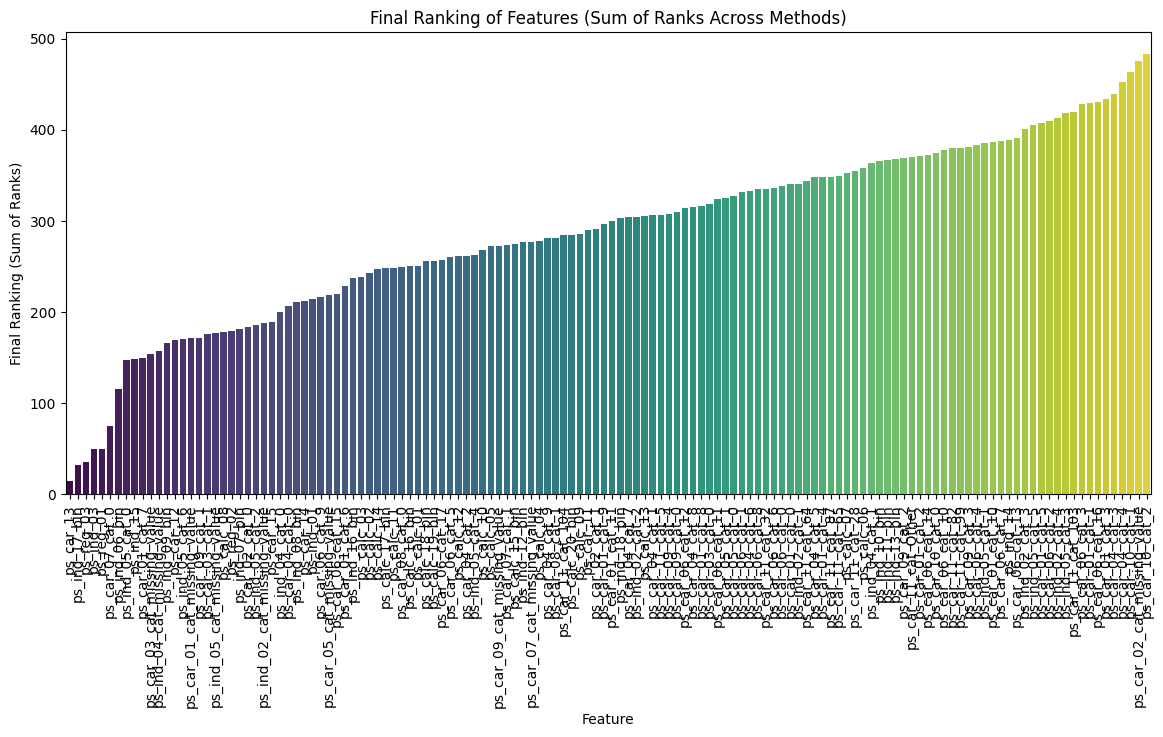

In [58]:
sorted_feature_ranks = feature_ranks.sort_values(by='Final Ranking')

plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Final Ranking', data=sorted_feature_ranks, palette='viridis')

plt.xlabel('Feature')
plt.ylabel('Final Ranking (Sum of Ranks)')
plt.title('Final Ranking of Features (Sum of Ranks Across Methods)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [59]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

In [ ]:
sorted_feature_ranks = feature_ranks.sort_values(by='Final Ranking')

auc_scores = []
num_features = []

for i in range(1, len(sorted_feature_ranks) + 1):
    selected_features = sorted_feature_ranks['Feature'].head(i)

    X_train_selected = X_train_v2[selected_features]
    X_val_selected = X_val_v2[selected_features]

    rf_classifier.fit(X_train_selected, y_train)

    y_val_pred_proba = rf_classifier.predict_proba(X_val_selected)[:, 1]

    auc = roc_auc_score(y_val, y_val_pred_proba)

    auc_scores.append(auc)
    num_features.append(i)


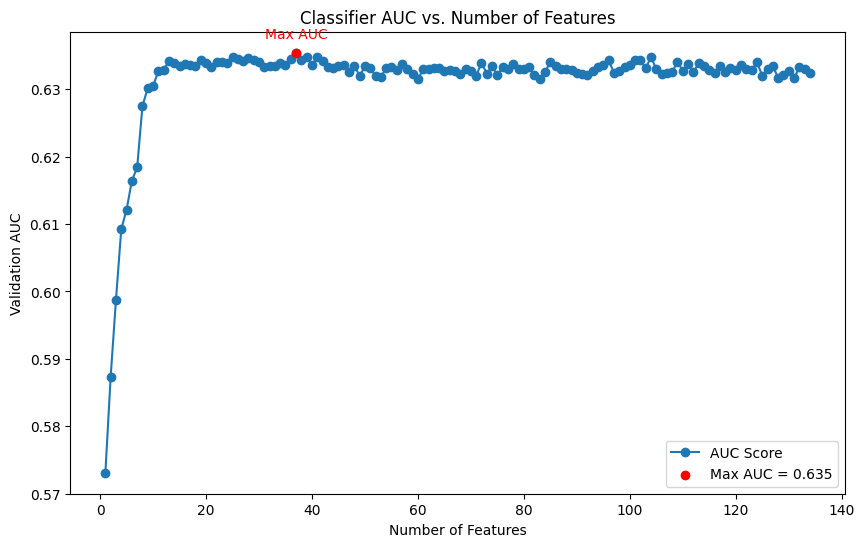

In [ ]:
import matplotlib.pyplot as plt

max_auc = max(auc_scores)
max_index = auc_scores.index(max_auc)
max_num_features = num_features[max_index]

plt.figure(figsize=(10, 6))
plt.plot(num_features, auc_scores, marker='o', label='AUC Score')

plt.scatter(max_num_features, max_auc, color='red', zorder=5, label=f'Max AUC = {max_auc:.3f}')
plt.annotate(f'Max AUC',
             (max_num_features, max_auc),
             textcoords="offset points",
             xytext=(0,10),
             ha='center',
             fontsize=10,
             color='red')

plt.xlabel('Number of Features')
plt.ylabel('Validation AUC')
plt.title('Classifier AUC vs. Number of Features')
plt.legend()
plt.show()


In [ ]:
results_df = pd.DataFrame({
    'Number of Features': num_features,
    'AUC Score': auc_scores
})

print(results_df)

     Number of Features  AUC Score
0                     1   0.573114
1                     2   0.587374
2                     3   0.598807
3                     4   0.609245
4                     5   0.612132
..                  ...        ...
129                 130   0.632706
130                 131   0.631602
131                 132   0.633256
132                 133   0.633027
133                 134   0.632453

[134 rows x 2 columns]


Max by 37

In [ ]:
top_85_features = feature_ranks.sort_values(by='Final Ranking')['Feature'].head(85).tolist()

print(top_85_features)


['ps_car_13', 'ps_ind_17_bin', 'ps_reg_03', 'ps_ind_03', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_06_bin', 'ps_ind_05_cat_0', 'ps_ind_15', 'ps_car_01_cat_7', 'ps_car_03_cat_missing_value', 'ps_ind_04_cat_missing_value', 'ps_ind_09_bin', 'ps_car_12', 'ps_ind_05_cat_6', 'ps_car_01_cat_missing_value', 'ps_car_09_cat_1', 'ps_car_03_cat_1', 'ps_ind_05_cat_missing_value', 'ps_calc_08', 'ps_reg_02', 'ps_ind_07_bin', 'ps_car_02_cat_0', 'ps_ind_05_cat_2', 'ps_ind_02_cat_missing_value', 'ps_car_15', 'ps_ind_04_cat_0', 'ps_car_04_cat_0', 'ps_ind_08_bin', 'ps_car_14', 'ps_ind_01', 'ps_car_06_cat_9', 'ps_car_05_cat_missing_value', 'ps_car_06_cat_15', 'ps_car_01_cat_6', 'ps_ind_16_bin', 'ps_calc_03', 'ps_calc_02', 'ps_calc_14', 'ps_calc_17_bin', 'ps_calc_11', 'ps_car_08_cat_0', 'ps_calc_16_bin', 'ps_calc_01', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_car_06_cat_17', 'ps_car_06_cat_5', 'ps_calc_12', 'ps_car_04_cat_2', 'ps_ind_05_cat_4', 'ps_calc_10', 'ps_calc_05', 'ps_car_09_cat_missing_value', 'ps_car_

## Best Features

In [150]:
top_37_features = [
    'ps_car_13', 'ps_ind_17_bin', 'ps_reg_03', 'ps_ind_03', 'ps_reg_01', 'ps_car_07_cat_0',
    'ps_ind_06_bin', 'ps_ind_05_cat_0', 'ps_ind_15', 'ps_car_01_cat_7',
    'ps_car_03_cat_missing_value', 'ps_ind_04_cat_missing_value', 'ps_ind_09_bin', 'ps_car_12',
    'ps_ind_05_cat_6', 'ps_car_01_cat_missing_value', 'ps_car_09_cat_1', 'ps_car_03_cat_1',
    'ps_ind_05_cat_missing_value', 'ps_calc_08', 'ps_reg_02', 'ps_ind_07_bin',
    'ps_car_02_cat_0', 'ps_ind_05_cat_2', 'ps_ind_02_cat_missing_value', 'ps_car_15',
    'ps_ind_04_cat_0', 'ps_car_04_cat_0', 'ps_ind_08_bin', 'ps_car_14', 'ps_ind_01',
    'ps_car_06_cat_9', 'ps_car_05_cat_missing_value', 'ps_car_06_cat_15', 'ps_car_01_cat_6',
    'ps_ind_16_bin', 'ps_calc_03'
]

X_train_best = X_train_v2[top_37_features]
X_val_best = X_val_v2[top_37_features]

In [151]:
top_85_features = ['ps_car_13', 'ps_ind_17_bin', 'ps_reg_03', 'ps_ind_03', 'ps_reg_01', 'ps_car_07_cat_0', 'ps_ind_06_bin', 'ps_ind_05_cat_0', 'ps_ind_15', 'ps_car_01_cat_7', 'ps_car_03_cat_missing_value', 'ps_ind_04_cat_missing_value', 'ps_ind_09_bin', 'ps_car_12', 'ps_ind_05_cat_6', 'ps_car_01_cat_missing_value', 'ps_car_09_cat_1', 'ps_car_03_cat_1', 'ps_ind_05_cat_missing_value', 'ps_calc_08', 'ps_reg_02', 'ps_ind_07_bin', 'ps_car_02_cat_0', 'ps_ind_05_cat_2', 'ps_ind_02_cat_missing_value', 'ps_car_15', 'ps_ind_04_cat_0', 'ps_car_04_cat_0', 'ps_ind_08_bin', 'ps_car_14', 'ps_ind_01', 'ps_car_06_cat_9', 'ps_car_05_cat_missing_value', 'ps_car_06_cat_15', 'ps_car_01_cat_6', 'ps_ind_16_bin', 'ps_calc_03', 'ps_calc_02', 'ps_calc_14', 'ps_calc_17_bin', 'ps_calc_11', 'ps_car_08_cat_0', 'ps_calc_16_bin', 'ps_calc_01', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_car_06_cat_17', 'ps_car_06_cat_5', 'ps_calc_12', 'ps_car_04_cat_2', 'ps_ind_05_cat_4', 'ps_calc_10', 'ps_calc_05', 'ps_car_09_cat_missing_value', 'ps_car_07_cat_1', 'ps_calc_15_bin', 'ps_ind_12_bin', 'ps_car_07_cat_missing_value', 'ps_calc_04', 'ps_car_04_cat_9', 'ps_car_08_cat_1', 'ps_calc_20_bin', 'ps_car_11_cat_104', 'ps_calc_09', 'ps_car_11', 'ps_car_02_cat_1', 'ps_car_01_cat_9', 'ps_car_01_cat_11', 'ps_car_04_cat_7', 'ps_ind_18_bin', 'ps_ind_02_cat_2', 'ps_calc_13', 'ps_car_04_cat_1', 'ps_car_11_cat_5', 'ps_car_09_cat_4', 'ps_car_09_cat_0', 'ps_car_06_cat_12', 'ps_car_04_cat_8', 'ps_car_01_cat_8', 'ps_car_03_cat_0', 'ps_car_06_cat_11', 'ps_car_05_cat_1', 'ps_car_05_cat_0', 'ps_car_06_cat_1', 'ps_car_04_cat_6']

X_train_best_2 = X_train_v2[top_85_features]
X_val_best_2 = X_val_v2[top_85_features]

In [153]:
print(f"Shape of X_train_best: {X_train_best.shape}")
print(f"Shape of X_val_best: {X_val_best.shape}")

print(f"Shape of X_train_best_2: {X_train_best_2.shape}")
print(f"Shape of X_val_best_2: {X_val_best_2.shape}")
print(X_train_best.dtypes)

Shape of X_train_best: (416648, 37)
Shape of X_val_best: (89282, 37)
Shape of X_train_best_2: (416648, 85)
Shape of X_val_best_2: (89282, 85)
ps_car_13                      float64
ps_ind_17_bin                  float64
ps_reg_03                      float64
ps_ind_03                      float64
ps_reg_01                      float64
ps_car_07_cat_0                float64
ps_ind_06_bin                  float64
ps_ind_05_cat_0                float64
ps_ind_15                      float64
ps_car_01_cat_7                float64
ps_car_03_cat_missing_value    float64
ps_ind_04_cat_missing_value    float64
ps_ind_09_bin                  float64
ps_car_12                      float64
ps_ind_05_cat_6                float64
ps_car_01_cat_missing_value    float64
ps_car_09_cat_1                float64
ps_car_03_cat_1                float64
ps_ind_05_cat_missing_value    float64
ps_calc_08                     float64
ps_reg_02                      float64
ps_ind_07_bin                  float64


## Entferne "Calc"

In [ ]:
# Entferne alle Spalten, die "calc" im Namen enthalten, aus X_train_categorical
X_train_categorical_v2 = X_train_categorical.drop([col for col in X_train_categorical.columns if 'calc' in col], axis=1)

# Entferne alle Spalten, die "calc" im Namen enthalten, aus X_val_categorical
X_val_categorical_v2 = X_val_categorical.drop([col for col in X_val_categorical.columns if 'calc' in col], axis=1)

# Zähle die Anzahl der Spalten nach dem Entfernen der "calc"-Spalten
num_columns_train = X_train_categorical_v2.shape[1]
num_columns_val = X_val_categorical_v2.shape[1]

print(f"Anzahl der Spalten in X_train_categorical: {num_columns_train}")
print(f"Anzahl der Spalten in X_val_categorical: {num_columns_val}")



Anzahl der Spalten in X_train_categorical: 37
Anzahl der Spalten in X_val_categorical: 37


In [ ]:
# Filtere alle Zeilen heraus, bei denen "calc" im 'Feature Name' enthalten ist
metadata_df_v2 = metadata_df[~metadata_df['Feature Name'].str.contains('calc')]

# Ausgabe der ersten Zeilen, um zu überprüfen, ob die Zeilen korrekt entfernt wurden
print(metadata_df_v2)
#

     Feature Name Data Type     Category Context    NAs   NAs_n       Min  \
0       ps_ind_01     uint8   continuous     ind  False       0         0   
1   ps_ind_02_cat  category  categorical     ind   True     216         1   
2       ps_ind_03     uint8   continuous     ind  False       0         0   
3   ps_ind_04_cat  category  categorical     ind   True      83         0   
4   ps_ind_05_cat  category  categorical     ind   True    5809         0   
5   ps_ind_06_bin  category       binary     ind  False       0         0   
6   ps_ind_07_bin  category       binary     ind  False       0         0   
7   ps_ind_08_bin  category       binary     ind  False       0         0   
8   ps_ind_09_bin  category       binary     ind  False       0         0   
9   ps_ind_10_bin  category       binary     ind  False       0         0   
10  ps_ind_11_bin  category       binary     ind  False       0         0   
11  ps_ind_12_bin  category       binary     ind  False       0         0   

In [ ]:
categorical_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
binary_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
continuous_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()

C:\Users\Dennis\AppData\Local\Temp\ipykernel_14680\3140452176.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  categorical_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
C:\Users\Dennis\AppData\Local\Temp\ipykernel_14680\3140452176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  binary_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
C:\Users\Dennis\AppData\Local\Temp\ipykernel_14680\3140452176.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  continuous_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()


In [ ]:
# Beste Pipeline (One-Hot)

categorical_transformer_v3 = Pipeline(steps=[
    ('imputer', CustomCategoricalImputer(method='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
continuous_transformer_v3 = Pipeline(steps=[
    ('imputer', CustomNumericalImputer(method='median')),
    ('scaler', MinMaxScaler())
    ])
preprocessor_v3 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_v3, categorical_cols_v2),
        ('bin', 'passthrough', binary_cols_v2),
        ('cont', continuous_transformer_v3, continuous_cols_v2)
    ]
)
pipeline_RF_v3 = Pipeline(steps=[
    ('preprocessor', preprocessor_v3),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ))
])
pipeline_RF_v3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer(method='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07...
                                                  Pipeline(steps=[('imputer',
                                                                   CustomNumericalImputer(method='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14',
                                                   'ps_car_15'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

In [ ]:
pipeline_RF_v3.fit(X_train_categorical_v2, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer(method='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07...
                                                  Pipeline(steps=[('imputer',
                                                                   CustomNumericalImputer(method='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14',
                                                   'ps_car_15'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=200,
                                        random_state=42))])

In [ ]:
#  Random Forest mit Imutatation und Categorical Anpassung
y_pred_RF = pipeline_RF_v3.predict(X_val_categorical_v2)
y_prob_RF = pipeline_RF_v3.predict_proba(X_val_categorical_v2)[:, 1]
roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
print("ROC AUC:", roc_auc_RF)



ROC AUC: 0.6329249472642074


Alles zusammengefasst

In [ ]:
# Entferne alle Spalten, die "calc" im Namen enthalten, aus X_train_categorical
X_train_categorical_v2 = X_train_categorical.drop([col for col in X_train_categorical.columns if 'calc' in col], axis=1)

# Entferne alle Spalten, die "calc" im Namen enthalten, aus X_val_categorical
X_val_categorical_v2 = X_val_categorical.drop([col for col in X_val_categorical.columns if 'calc' in col], axis=1)

# Zähle die Anzahl der Spalten nach dem Entfernen der "calc"-Spalten
num_columns_train = X_train_categorical_v2.shape[1]
num_columns_val = X_val_categorical_v2.shape[1]

print(f"Anzahl der Spalten in X_train_categorical: {num_columns_train}")
print(f"Anzahl der Spalten in X_val_categorical: {num_columns_val}")

# Filtere alle Zeilen heraus, bei denen "calc" im 'Feature Name' enthalten ist
metadata_df_v2 = metadata_df[~metadata_df['Feature Name'].str.contains('calc')]

# Ausgabe der ersten Zeilen, um zu überprüfen, ob die Zeilen korrekt entfernt wurden
print(metadata_df_v2)

categorical_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'categorical') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
binary_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'binary') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()
continuous_cols_v2 = metadata_df_v2[(metadata_df['Category'] == 'continuous') & (metadata_df['Feature Name'] != 'target')]['Feature Name'].tolist()

# Beste Pipeline (One-Hot)

categorical_transformer_v3 = Pipeline(steps=[
    ('imputer', CustomCategoricalImputer(method='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
continuous_transformer_v3 = Pipeline(steps=[
    ('imputer', CustomNumericalImputer(method='median')),
    ('scaler', MinMaxScaler())
    ])
preprocessor_v3 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_v3, categorical_cols_v2),
        ('bin', 'passthrough', binary_cols_v2),
        ('cont', continuous_transformer_v3, continuous_cols_v2)
    ]
)
pipeline_RF_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor_v3),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ))
])
pipeline_RF_v3

pipeline_RF_v3.fit(X_train_categorical_v2, y_train)


#  Random Forest mit Imutatation und Categorical Anpassung
y_pred_RF = pipeline_RF_v3.predict(X_val_categorical_v2)
y_prob_RF = pipeline_RF_v3.predict_proba(X_val_categorical_v2)[:, 1]
roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
print("ROC AUC:", roc_auc_RF)


Loop für verschiedene Kombinationen Spalten mit "Calc" entfernen

In [ ]:
# Anzahl der maximalen Kombinationen, die getestet werden sollen
max_combinations = 20

# Finde alle Spalten, die "calc" im Namen haben
calc_columns = [col for col in X_train_categorical.columns if 'calc' in col]

# Erstelle eine Liste für die Ergebnisse
results = []

# Generiere alle Kombinationen von 'calc'-Spalten für verschiedene Längen
all_combos = [combo for r in range(1, len(calc_columns) + 1) for combo in combinations(calc_columns, r)]

# Wähle zufällig 20 Kombinationen aus
random_combos = random.sample(all_combos, min(max_combinations, len(all_combos)))

# Schleife über die zufälligen Kombinationen
for i, combo in enumerate(random_combos, 1):
    # Kopie der Trainings- und Validierungsdaten erstellen
    X_train_categorical_v2 = X_train_categorical.drop(list(combo), axis=1)
    X_val_categorical_v2 = X_val_categorical.drop(list(combo), axis=1)

    # Entferne auch die entsprechenden Spalten in den Metadaten
    metadata_df_v2 = metadata_df[~metadata_df['Feature Name'].isin(combo)]

    # Kategorische, binäre und kontinuierliche Spalten aktualisieren
    categorical_cols_v2 = metadata_df_v2[(metadata_df_v2['Category'] == 'categorical') & (metadata_df_v2['Feature Name'] != 'target')]['Feature Name'].tolist()
    binary_cols_v2 = metadata_df_v2[(metadata_df_v2['Category'] == 'binary') & (metadata_df_v2['Feature Name'] != 'target')]['Feature Name'].tolist()
    continuous_cols_v2 = metadata_df_v2[(metadata_df_v2['Category'] == 'continuous') & (metadata_df_v2['Feature Name'] != 'target')]['Feature Name'].tolist()

    # Preprocessing-Pipeline anpassen
    preprocessor_v3 = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer_v3, categorical_cols_v2),
            ('bin', 'passthrough', binary_cols_v2),
            ('cont', continuous_transformer_v3, continuous_cols_v2)
        ]
    )

    # Random Forest Pipeline aktualisieren
    pipeline_RF_v3 = Pipeline(steps=[
        ('preprocessor', preprocessor_v2),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs = -1
        ))
    ])

    # Trainiere das Modell
    pipeline_RF_v3.fit(X_train_categorical_v2, y_train)

    # Vorhersage und ROC AUC auf dem Validierungsdatensatz
    y_pred_RF = pipeline_RF_v3.predict(X_val_categorical_v2)
    y_prob_RF = pipeline_RF_v3.predict_proba(X_val_categorical_v2)[:, 1]
    roc_auc_RF = roc_auc_score(y_val, y_prob_RF)

    # Speichere die Ergebnisse
    results.append({
        'removed_columns': combo,
        'roc_auc': roc_auc_RF
    })

    # Zeige den aktuellen Fortschritt und ROC AUC
    print(f"Durchlauf {i}/{max_combinations}: Entfernte Spalten: {combo}, ROC AUC: {roc_auc_RF}")

# Sortiere die Ergebnisse nach ROC AUC
results = sorted(results, key=lambda x: x['roc_auc'], reverse=True)

# Ausgabe des besten Ergebnisses
best_result = results[0]
print(f"\nBeste Kombination von entfernten Spalten: {best_result['removed_columns']}")
print(f"Bester ROC AUC: {best_result['roc_auc']}")


Durchlauf 1/20: Entfernte Spalten: ('ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_06', 'ps_calc_09', 'ps_calc_16_bin', 'ps_calc_17_bin'), ROC AUC: 0.6322380023553458
Durchlauf 2/20: Entfernte Spalten: ('ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_07', 'ps_calc_08', 'ps_calc_15_bin', 'ps_calc_17_bin'), ROC AUC: 0.63180022590378
Durchlauf 3/20: Entfernte Spalten: ('ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_08', 'ps_calc_09', 'ps_calc_12', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin'), ROC AUC: 0.6324326224571644
Durchlauf 4/20: Entfernte Spalten: ('ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_06', 'ps_calc_07', 'ps_calc_10', 'ps_calc_12', 'ps_calc_15_bin', 'ps_calc_18_bin', 'ps_calc_19_bin'), ROC AUC: 0.6340606175905508
Durchlauf 5/20: Entfernte Spalten: ('ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_11', 'ps_calc_14', 'ps_calc_16_bin', 'ps_calc_18_bin', 'ps_calc_19_bin'), ROC AUC: 0.635065064649

## Optimization for imbalanced data

### SMOTE: Synthetic Minority Over-sampling

first One Hot Encode

In [ ]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

# Transform X_train
X_train_encoded = column_transformer.fit_transform(X_train)

In [ ]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

In [ ]:
print(f"Original y_train class distribution: {Counter(y_train)}")
print(f"Resampled y_train_res class distribution: {Counter(y_train_res)}")


Original y_train class distribution: Counter({0: 83508, 1: 3947})
Resampled y_train_res class distribution: Counter({0: 83508, 1: 83508})


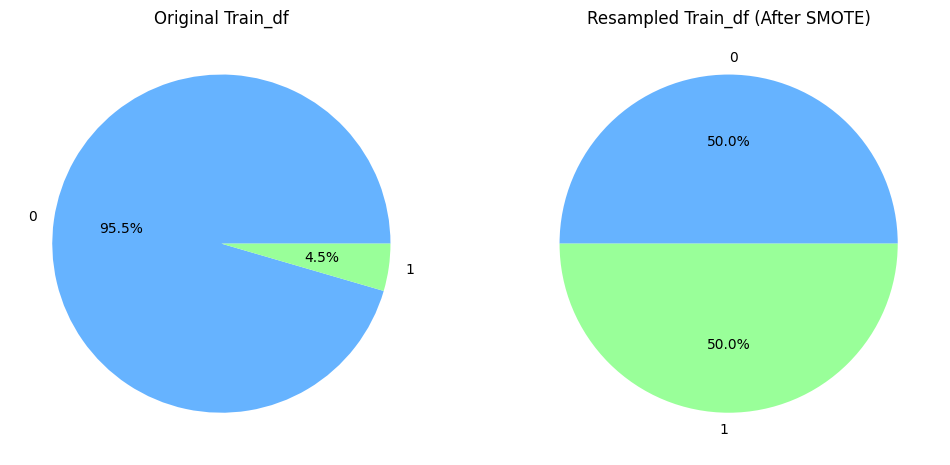

In [ ]:
train_target_dist = pd.Series(Counter(y_train))
train_res_target_dist = pd.Series(Counter(y_train_res))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution before SMOTE
axs[0].pie(train_target_dist, labels=train_target_dist.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
axs[0].set_title('Original Train_df')

# Plot the distribution after SMOTE
axs[1].pie(train_res_target_dist, labels=train_res_target_dist.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
axs[1].set_title('Resampled Train_df (After SMOTE)')

plt.show()

In [ ]:
pipeline_RF_SMOTE = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ))
])

pipeline_RF_SMOTE

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

In [ ]:
pipeline_RF_SMOTE.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07_cat',
                                                   'ps_car_08_cat',
                                                   'ps_car_09_cat',
                                                   'ps_car_10_cat',
                                                   'ps_car_11_cat']),
                                                 ('bin', 'passt...
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

In [ ]:
y_pred_RF = pipeline_RF_SMOTE.predict(X_val)
y_prob_RF = pipeline_RF_SMOTE.predict_proba(X_val)[:, 1]

accuracy_RF = accuracy_score(y_val, y_pred_RF)
roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
precision_RF, recall_RF, _ = precision_recall_curve(y_val, y_prob_RF)
pr_auc_RF = auc(recall_RF, precision_RF)
conf_matrix_RF = confusion_matrix(y_val, y_pred_RF)
report_RF = classification_report(y_val, y_pred_RF)

print("Random Forest Model:")
print("Accuracy:", accuracy_RF)
print("ROC AUC:", roc_auc_RF)
print("PR AUC:", pr_auc_RF)
print("Confusion Matrix:\n", conf_matrix_RF)
print("Classification Report:\n", report_RF)

Random Forest Model:
Accuracy: 0.9541172734970365
ROC AUC: 0.5930367826279637
PR AUC: 0.0621405200686886
Confusion Matrix:
 [[18027    25]
 [  842     2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18052
           1       0.07      0.00      0.00       844

    accuracy                           0.95     18896
   macro avg       0.51      0.50      0.49     18896
weighted avg       0.92      0.95      0.93     18896



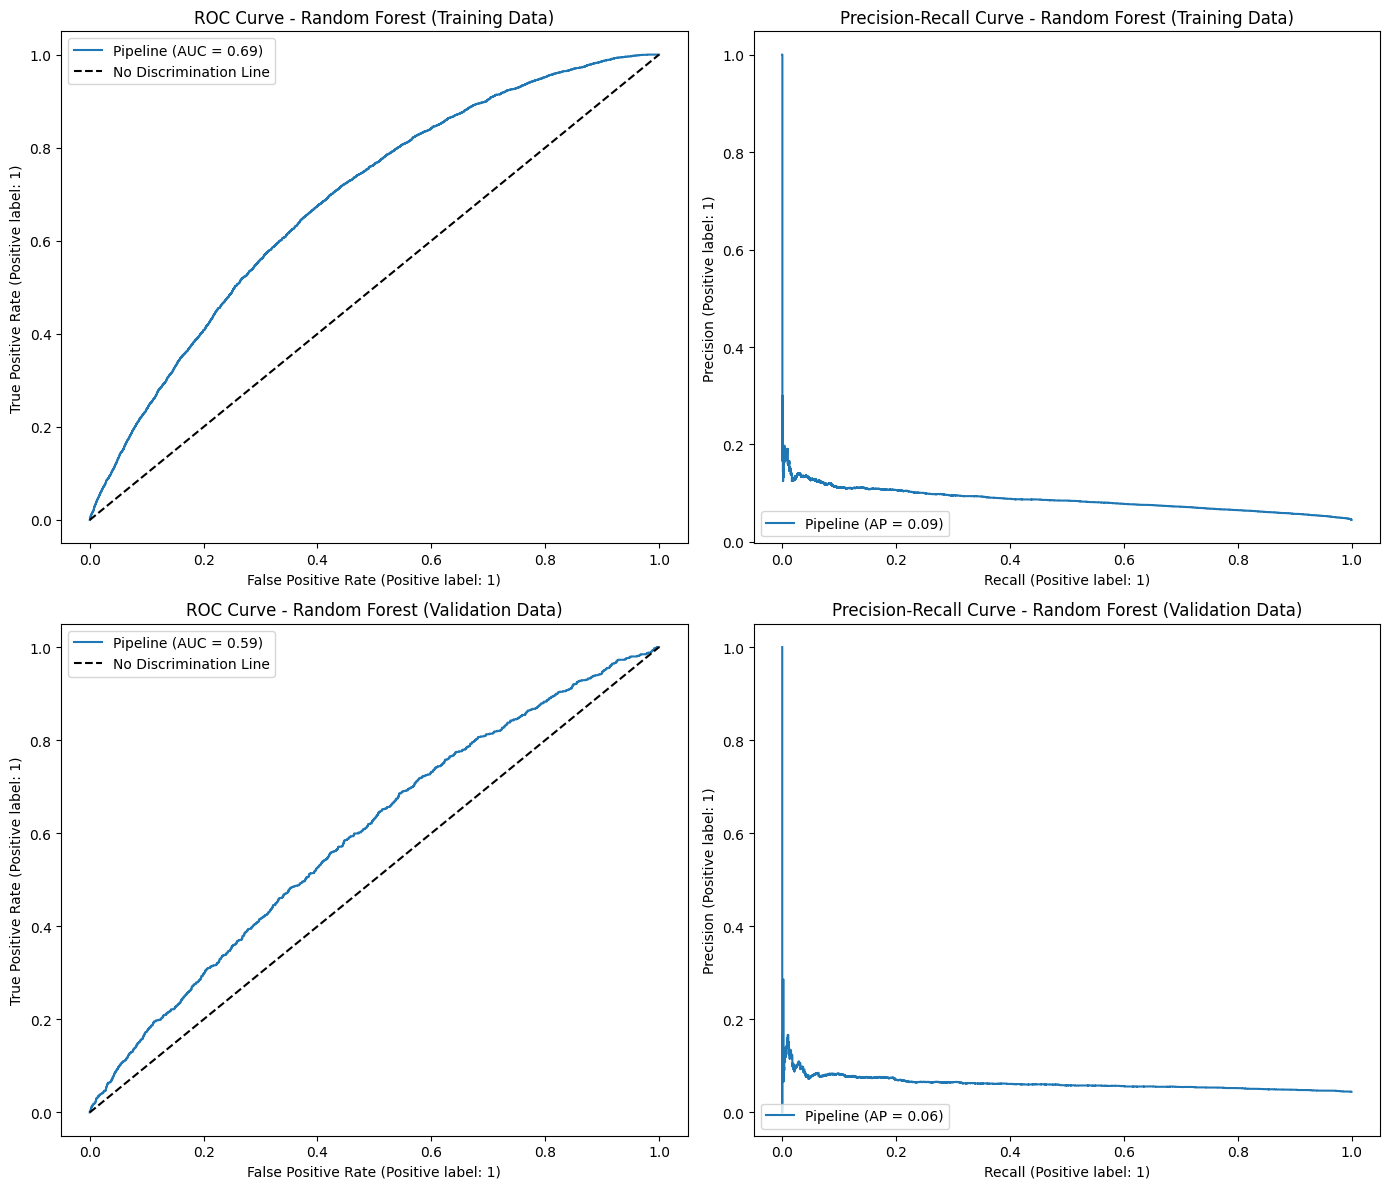

In [ ]:
fig, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(14, 12))

RocCurveDisplay.from_estimator(pipeline_RF_SMOTE, X_train, y_train, ax=ax5)
ax5.set_title("ROC Curve - Random Forest (Training Data)")
ax5.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax5.legend()

PrecisionRecallDisplay.from_estimator(pipeline_RF_SMOTE, X_train, y_train, ax=ax6)
ax6.set_title("Precision-Recall Curve - Random Forest (Training Data)")

RocCurveDisplay.from_estimator(pipeline_RF_SMOTE, X_val, y_val, ax=ax7)
ax7.set_title("ROC Curve - Random Forest (Validation Data)")
ax7.plot([0, 1], [0, 1], 'k--', label='No Discrimination Line')
ax7.legend()

PrecisionRecallDisplay.from_estimator(pipeline_RF_SMOTE, X_val, y_val, ax=ax8)
ax8.set_title("Precision-Recall Curve - Random Forest (Validation Data)")

plt.tight_layout()
plt.show()

Random Forest ist ein Ensemblemethode und daher Rebist gegen inbalanced Data. SMOTE bringt an der Stelle nicht viel Gewinn. Eher schlechter wegen syntetische Data

# Modelling

## Random Forest

In [ ]:
# pip install optuna

In [ ]:
# pip install optuna-dashboard

In [64]:
import logging
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [65]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [84]:
storage = 'sqlite:///optuna_study.db'
study_name = 'random_forest_hyperparameter_optimization'

try:
    optuna.delete_study(
        study_name=study_name,
        storage=storage
    )
    print(f"Existing study '{study_name}' deleted.")
except KeyError:
    print(f"No existing study '{study_name}' found")


Existing study 'random_forest_hyperparameter_optimization' deleted.


In [85]:
storage = 'sqlite:///optuna_study.db'

study = optuna.create_study(
    direction='maximize',
    study_name='random_forest_hyperparameter_optimization',
    storage=storage
)

[I 2024-09-16 20:13:22,193] A new study created in RDB with name: random_forest_hyperparameter_optimization


In [86]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1  
    )

    clf.fit(X_train_best, y_train)

    y_pred_proba = clf.predict_proba(X_val_best)[:, 1]

    auc = roc_auc_score(y_val, y_pred_proba)

    return auc

study.optimize(objective, n_trials=100)

[I 2024-09-16 20:14:01,390] Trial 0 finished with value: 0.6169619658144205 and parameters: {'n_estimators': 481, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6169619658144205.
[I 2024-09-16 20:15:38,210] Trial 1 finished with value: 0.6028564362444109 and parameters: {'n_estimators': 750, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 0 with value: 0.6169619658144205.
[I 2024-09-16 20:18:21,185] Trial 2 finished with value: 0.6168076943488247 and parameters: {'n_estimators': 623, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.6169619658144205.
[I 2024-09-16 20:19:06,195] Trial 3 finished with value: 0.6024430797377072 and parameters: {'n_estimators': 275, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.6169619658144205.
[

In [98]:
import threading
import time
from optuna_dashboard import run_server
from IPython.display import IFrame, display

def start_dashboard():
    run_server(
        storage='sqlite:///optuna_study.db',
        host='localhost',
        port=5006
    )

thread = threading.Thread(target=start_dashboard)
thread.start()

time.sleep(2)  


display(IFrame(src='http://localhost:5006/', width='100%', height='2000px'))


Bottle v0.13.1 server starting up (using WSGIRefServer())...
Listening on http://localhost:5006/
Hit Ctrl-C to quit.



In [87]:
best_params = study.best_params
print("Best hyperparameters found:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Best hyperparameters found:
n_estimators: 301
max_depth: 12
min_samples_split: 5
min_samples_leaf: 16
max_features: log2


In [89]:
# Best Random Forest Modell:

best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_best, y_train)

y_val_pred_proba = best_rf.predict_proba(X_val_best)[:, 1]
test_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"Test AUC score with best hyperparameters: {test_auc}")

Test AUC score with best hyperparameters: 0.6369400777420161


## Support Vector Machine (SVM)

In [ ]:
classifier = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42,
        probability=True
    )

classifier.fit(X_train_best, y_train)

In [ ]:
X_val_best = X_val_v2[selected_features[0]]

#  SVM mit Feature Selection
y_prob_RF = classifier.predict_proba(X_val_best)[:, 1]
roc_auc_RF = roc_auc_score(y_val, y_prob_RF)
print("ROC AUC:", roc_auc_RF)

In [ ]:
#  SVM
y_pred_SVM = pipeline_SVM.predict(X_val)
y_prob_SVM = pipeline_SVM.predict_proba(X_val)[:, 1]

accuracy_SVM = accuracy_score(y_val, y_pred_SVM)
roc_auc_SVM = roc_auc_score(y_val, y_prob_SVM)
precision_SVM, recall_SVM, _ = precision_recall_curve(y_val, y_prob_SVM)
pr_auc_SVM = auc(recall_SVM, precision_SVM)
conf_matrix_SVM = confusion_matrix(y_val, y_pred_SVM)
report_SVM = classification_report(y_val, y_pred_SVM)

print("SVM:")
print("Accuracy:", accuracy_SVM)
print("ROC AUC:", roc_auc_SVM)
print("PR AUC:", pr_auc_SVM)
print("Confusion Matrix:\n", conf_matrix_SVM)
print("Classification Report:\n", report_SVM)

## Neuronales Netz

## Erster Ansatz

In [ ]:
pipeline_NN = Pipeline(steps=[
    ("preprocessor", preprocessor_v2),
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(100,),
        activation ="relu",
        solver="adam",
        max_iter=200,
        random_state=42
    ))
])

pipeline_NN

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer(method='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07...
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier', MLPClassifier(random_state=42))])

In [ ]:
pipeline_NN.fit(X_train_categorical, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomCategoricalImputer(method='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ps_ind_02_cat',
                                                   'ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_02_cat',
                                                   'ps_car_03_cat',
                                                   'ps_car_04_cat',
                                                   'ps_car_05_cat',
                                                   'ps_car_06_cat',
                                                   'ps_car_07...
                                                   'ps_ind_14', 'ps_ind_15',
                                                   'ps_reg_01', 'ps_reg_02',
                                                   'ps_reg_03', 'ps_car_11',
                                                   'ps_car_12', 'ps_car_13',
                                                   'ps_car_14', 'ps_car_15',
                                                   'ps_calc_01', 'ps_calc_02',
                                                   'ps_calc_03', 'ps_calc_04',
                                                   'ps_calc_05', 'ps_calc_06',
                                                   'ps_calc_07', 'ps_calc_08',
                                                   'ps_calc_09', 'ps_calc_10',
                                                   'ps_calc_11', 'ps_calc_12',
                                                   'ps_calc_13',
                                                   'ps_calc_14'])])),
                ('classifier', MLPClassifier(random_state=42))])

In [ ]:
y_pred_NN = pipeline_NN.predict(X_val_categorical)
y_prob_NN = pipeline_NN.predict_proba(X_val_categorical)[:, 1]

roc_auc_NN = roc_auc_score(y_val, y_prob_NN)
print("ROC AUC:", roc_auc_NN)


ROC AUC: 0.582610105016051


Hyperparameter

In [ ]:
# Hyperparameter für MLPClassifier Tuning
hidden_layer_sizes_list = [(100,), (100, 50), (150, 100)]
alpha_list = [0.0001, 0.001]
learning_rate_init_list = [0.001, 0.01]
max_iter_list = [200, 300]

best_roc_auc = 0
best_params = None

# Schleife über alle Kombinationen von MLPClassifier Hyperparametern
for hidden_layer_sizes in hidden_layer_sizes_list:
    for alpha in alpha_list:
        for learning_rate_init in learning_rate_init_list:
            for max_iter in max_iter_list:
                print(f"\nTesting combination: hidden_layer_sizes = {hidden_layer_sizes}, alpha = {alpha}, "
                      f"learning_rate_init = {learning_rate_init}, max_iter = {max_iter}")

                # Finaler MLPClassifier mit aktuellen Hyperparametern
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor_v2),
                    ('classifier', MLPClassifier(
                        hidden_layer_sizes=hidden_layer_sizes,
                        alpha=alpha,
                        learning_rate_init=learning_rate_init,
                        max_iter=max_iter,
                        random_state=42,
                        activation ="relu",
                        solver="adam"
                    ))
                ])

                # Training des Modells auf den Trainingsdaten
                pipeline.fit(X_train_categorical, y_train)

                # Vorhersage auf den Validierungsdaten
                y_pred = pipeline.predict(X_val_categorical)
                y_prob = pipeline.predict_proba(X_val_categorical)[:, 1]

                # Berechnung der ROC AUC auf den Validierungsdaten
                roc_auc = roc_auc_score(y_val, y_prob)
                print(f"ROC AUC Score: {roc_auc}")

                # Speichere die beste Konfiguration
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_params = {
                        'hidden_layer_sizes': hidden_layer_sizes,
                        'alpha': alpha,
                        'learning_rate_init': learning_rate_init,
                        'max_iter': max_iter
                    }

                # Ausgabe des aktuellen besten Modells
                print(f"Current Best ROC AUC: {best_roc_auc}")
                print(f"Best Hyperparameters so far: {best_params}\n")

# Endergebnis ausgeben
print(f"\nBest Hyperparameters: {best_params} with ROC AUC: {best_roc_auc}")



Testing combination: hidden_layer_sizes = (100,), alpha = 0.0001, learning_rate_init = 0.001, max_iter = 200
ROC AUC Score: 0.582610105016051
Current Best ROC AUC: 0.582610105016051
Best Hyperparameters so far: {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 200}


Testing combination: hidden_layer_sizes = (100,), alpha = 0.0001, learning_rate_init = 0.001, max_iter = 300
ROC AUC Score: 0.582610105016051
Current Best ROC AUC: 0.582610105016051
Best Hyperparameters so far: {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 200}


Testing combination: hidden_layer_sizes = (100,), alpha = 0.0001, learning_rate_init = 0.01, max_iter = 200
ROC AUC Score: 0.6276116748798557
Current Best ROC AUC: 0.6276116748798557
Best Hyperparameters so far: {'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 200}


Testing combination: hidden_layer_sizes = (100,), alpha = 0.0001, learning_rat

In [70]:
X_train_best = X_train_best.apply(pd.to_numeric, errors='coerce')
X_val_best = X_val_best.apply(pd.to_numeric, errors='coerce')

print(X_train_best.dtypes)
print(X_val_best.dtypes)


ps_car_13                      float64
ps_ind_17_bin                    int64
ps_reg_03                      float64
ps_ind_03                      float64
ps_reg_01                      float64
ps_car_07_cat_0                float64
ps_ind_06_bin                    int64
ps_ind_05_cat_0                float64
ps_ind_15                      float64
ps_car_01_cat_7                float64
ps_car_03_cat_missing_value    float64
ps_ind_04_cat_missing_value    float64
ps_ind_09_bin                    int64
ps_car_12                      float64
ps_ind_05_cat_6                float64
ps_car_01_cat_missing_value    float64
ps_car_09_cat_1                float64
ps_car_03_cat_1                float64
ps_ind_05_cat_missing_value    float64
ps_calc_08                     float64
ps_reg_02                      float64
ps_ind_07_bin                    int64
ps_car_02_cat_0                float64
ps_ind_05_cat_2                float64
ps_ind_02_cat_missing_value    float64
ps_car_15                

Best Hyperparameters: {'hidden_layer_sizes': (150, 100), 'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 200} with ROC AUC: 0.6310525955029178

## Keras

In [154]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt


In [155]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        
        # Hyperparameter: Kernel-Initializer
        kernel_initializer = hp.Choice('kernel_initializer', ['glorot_uniform', 'he_uniform', 'lecun_normal'])
        
        # Hyperparameter: Anzahl der versteckten Schichten
        for i in range(hp.Int('num_layers', 1, 3)):
            # Hyperparameter: Anzahl der Neuronen
            units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
            # Hyperparameter: Aktivierungsfunktion
            activation = hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid'])
            model.add(layers.Dense(
                units=units,
                activation=activation,
                kernel_initializer=kernel_initializer
            ))
            # Hyperparameter: Dropout
            if hp.Boolean('dropout_' + str(i)):
                rate = hp.Float('dropout_rate_' + str(i), min_value=0.1, max_value=0.5, step=0.1)
                model.add(layers.Dropout(rate))
        
        # Ausgabeschicht
        num_classes = len(np.unique(y_train))  # Anzahl der Klassen aus den eindeutigen Labels
        model.add(layers.Dense(
            num_classes,
            activation='softmax',
            kernel_initializer=kernel_initializer
        ))
        
        # Hyperparameter: Optimizer und Lernrate
        optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        
        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'sgd':
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',  # Verwenden von 'sparse_categorical_crossentropy' für Integer-Labels
            metrics=['accuracy']
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        # Hyperparameter: Batch-Größe
        batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)
        return model.fit(
            *args,
            batch_size=batch_size,
            **kwargs
        )


In [156]:
hypermodel = MyHyperModel()

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)



Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json


In [157]:
tuner.search(
    X_train_best, y_train,
    epochs=50,
    validation_data=(X_val_best, y_val),
    callbacks=[stop_early]
)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
3                 |4                 |num_layers
192               |352               |units_0
tanh              |sigmoid           |activation_0
True              |False             |batch_norm_0
False             |False             |dropout_0
rmsprop           |rmsprop           |optimizer
0.0091609         |0.00042267        |learning_rate_adam
480               |32                |units_1
sigmoid           |relu              |activation_1
False             |False             |batch_norm_1
False             |False             |dropout_1
448               |32                |units_2
tanh              |relu              |activation_2
False             |False             |batch_norm_2
False             |False             |dropout_2
64                |32                |units_3
relu              |relu              |activation_3
False             |False             |batch_norm_3
False             |False      

Traceback (most recent call last):
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dennis\AppData\Local\Temp\ipykernel_15572\794400814.py", line 53, in fit
    return model.fit(
           ^^^^^^^^^^
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\optree\ops.py", line 521, in tree_map
    return treespec.unflatten(flat_results)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid dtype: category
